# The Full Production Notebook

This is the notebook showing pretty much every step taken in this analysis, except for anything that needed to be exported for better use. Below is the directory of major sections so that you can easily jump back and forth.

- [Functions for Processing and Plotting](#Functions-Used-Within)
- [Processing OGLE](#OGLE-III-Catalog-of-Variable-Stars)
- [Data from SDSS VAGC and LRGS](#SDSS-Value-added-Galaxy-Catalog-&-Luminous-Red-Giant-Survey)
- [Completeness and Contamination Fractions](#Calculating-Completeness-and-Contamination-Fractions)
- [Accounting for YSOs using the Taurus Field](#Accounting-for-YSOs-using-the-Taurus-Field)
- [Test for RGB stars](#Test-for-RGB-stars-in-JKW1-3-Space)
- [The Distribution of Galactic AGB candidates](#The-Distribution-of-Galactic-AGB-candidates)
- [O-rich and C-rich Boundaries](#Define-Boundary-Lines-for-O-rich-and-C-rich-AGB-Stars)
- [Absolute Magnitude Estimation](#Linear-Regression-to-Estimate-Absolute-Magnitudes)
- [Saving Absolute Magnitudes for Candidates](#Calculate-and-Save-Absolute-Magnitudes)
- [Results of Dust Extinction Calculation](#The-Results-of-the-Dust-Extinction-Calculation)
- [Density Distributions of AGB Candidates](#Plot-out-Z-histograms-binned-in-R-and-vice-versa)
- [Modeling Disk Scale Heights](#Calculate-the-Scale-Heights-of-given-R-bins)

In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.ticker import NullFormatter
%matplotlib inline
from thesiscode.quality import *
from thesiscode.plotting import *
from scipy.stats import linregress, binned_statistic_2d

In [2]:
font = {'family' : 'normal',
        'size'   : 12,
        'weight' : 'heavy'}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10)
matplotlib.rcParams["ps.useafm"] = True
matplotlib.rcParams["pdf.use14corefonts"] = True
matplotlib.rcParams["text.usetex"] = True

fig_dir = "/Users/Nick/Documents/thesis_materials/paper1/figs/"

## Functions Used Within
[Return to Top](#The-Full-Production-Notebook)

In [3]:
def three_cell_plot(x1, x2, x3, y1, y2, y3, xlabel=None, xlims=None, ylabel=None,
                    ylims=None, txt1=None, txt2=None, txt3=None, inverted=False,
                    outfile=None, hzline=None, vertline=None):
    colors = ["b","r","g","y","purple","orange","black"]
    
    fig = plt.figure(figsize=(6,6))
    fig.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1, wspace=0, hspace=0)

    ax = plt.subplot(221)
    for ii in range(len(x1)):
        ax.scatter(x1[ii], y1[ii], c=colors[ii], s=1, edgecolor="None")
    if txt1:
        ax.text(0.9, 0.9, txt1, transform=ax.transAxes, horizontalalignment="right")
    if hzline:
        ax.plot([xlims[0], xlims[1]], [hzline, hzline], linestyle="--", color='k')
    if vertline:
        ax.plot([vertline, vertline], [ylims[0], ylims[1]], linestyle="--", color='k')
    ax.set_xlim(xlims[0], xlims[1])
    ax.set_ylim(ylims[0], ylims[1])
    ax.set_ylabel(ylabel)
    if inverted:
        ax.invert_yaxis()
    ax.get_xaxis().set_ticklabels([])
    ax.minorticks_on()

    ax = plt.subplot(223)
    for ii in range(len(x2)):
        ax.scatter(x2[ii], y2[ii], c=colors[ii], s=1, edgecolor="None")
    if txt2:
        ax.text(0.9, 0.9, txt2, transform=ax.transAxes, horizontalalignment="right")
    if hzline:
        ax.plot([xlims[0], xlims[1]], [hzline, hzline], linestyle="--", color='k')
    if vertline:
        ax.plot([vertline, vertline], [ylims[0], ylims[1]], linestyle="--", color='k')
    ax.set_xlim(xlims[0], xlims[1])
    ax.set_ylim(ylims[0], ylims[1])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if inverted:
        ax.invert_yaxis()
    ax.minorticks_on()

    ax = plt.subplot(224)
    for ii in range(len(x3)):
        ax.scatter(x3[ii], y3[ii], c=colors[ii], s=1, edgecolor="None")
    if txt3:
        ax.text(0.9, 0.9, txt3, transform=ax.transAxes, horizontalalignment="right")
    if hzline:
        ax.plot([xlims[0], xlims[1]], [hzline, hzline], linestyle="--", color='k')
    if vertline:
        ax.plot([vertline, vertline], [ylims[0], ylims[1]], linestyle="--", color='k')
    ax.set_xlim(xlims[0], xlims[1])
    ax.set_ylim(ylims[0], ylims[1])
    ax.set_xlabel(xlabel)
    ax.get_yaxis().set_ticklabels([])
    if inverted:
        ax.invert_yaxis()
    ax.minorticks_on()
    if outfile:
        plt.savefig(outfile)
    
    plt.show()

In [4]:
def two_cell_comparison(df1, df2, xcol, ycol,
                        xlabel, ylabel, xlim = [-0.2, 2.7], ylim = [-0.5, 2.0],
                        hzline = 0.2, slant=[(0.75, -0.33), (-1.,1.5)],
                        meet=1.3, outfile=None):
    
    adjust={"left": 0.09, "right":0.87, "top":0.97, "bottom":0.1, "hspace":0.35, "wspace":0}
    fig = plt.figure(figsize=(8,4))
    fig.subplots_adjust(left=adjust["left"], right=adjust["right"], top=adjust["top"], bottom=adjust["bottom"], hspace=adjust["hspace"], wspace=adjust["wspace"])

    df1 = agb_cuts(photo_cuts(df1))
    df2 = agb_cuts(photo_cuts(df2))
    
    ax1 = fig.add_subplot(121)

    ax1.scatter(df1[xcol], df1[ycol], s=10, c="None", edgecolor="k", marker="o")
    ax1.scatter(df2[xcol], df2[ycol], s=10, c="r", marker="x")

    for line in slant:
        x = np.linspace(xlim[0], xlim[1],10)
        y = line[0]*x + line[1]
        ax1.plot(x, y, color="#00FF00", linestyle="--")

    if hzline:
        ax1.plot([xlim[0], xlim[1]], [hzline, hzline], color="#00FF00", linestyle="--")
        ax1.fill_between([1.075, meet], [slant[1][0]*1.075 + slant[1][1], slant[1][0]*meet + slant[1][1]], [slant[0][0]*1.075 + slant[0][1], slant[0][0]*meet + slant[0][1]], color='k', alpha=0.5)    
        ax1.fill_between([meet, xlim[1]], [hzline, hzline], [slant[0][0]*meet + slant[0][1], slant[0][0]*xlim[1] + slant[0][1]], color='k', alpha=0.5)    

    ax1.set_xlabel(xlabel)
    ax1.set_xlim(xlim[0], xlim[1])
    ax1.set_ylabel(ylabel)
    ax1.set_ylim(ylim[0], ylim[1])
    ax1.minorticks_on()
    
    df1 = remove_ysos(df1)
    df2 = remove_ysos(df2)

    ax = fig.add_subplot(122)

    ax.scatter(df1[xcol], df1[ycol], s=10, c="None", edgecolor="k", marker="o")
    ax.scatter(df2[xcol], df2[ycol], s=10, c="r", marker="x")

    ax.set_xlabel(xlabel)
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    ax.set_yticklabels([])
    ax.minorticks_on()

    if outfile:
        plt.savefig(outfile)

    plt.show()

In [5]:
def two_cell_plot(x1_arr, x2_arr, y1_arr, y2_arr, xlabels_arr=None, ylabels_arr=None, orientation="vertical", 
                  hist=False, xlim_arr=None, ylim_arr=None, dx=0.1, dy=0.1, cmap=plt.cm.gnuplot, 
                  cbar_title=None, vmin=0, vmax=10, multi=False, outfile=None):
    colors = ["k","b","r","g","purple","y","orange","black"]

    if orientation == "vertical":
        fig = plt.figure(figsize=(3,8))
    else:
        fig = plt.figure(figsize=(8,3))
        
    if hist:
        fig.subplots_adjust(left=0.09, right=0.85, top=0.97, bottom=0.1)
    else:
        fig.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1)

    if orientation == "vertical":        
        ax1 = plt.subplot(211)
        ax2 = plt.subplot(212)
    else:
        ax1 = plt.subplot(121)
        ax2 = plt.subplot(122)
        
    if hist:
        dx = dx
        dy = dy

        if xlims_arr:
            xbins1 = np.arange(xlims_arr[0][0], xlims_arr[0][1] + dx, dx)
            xbins2 = np.arange(xlims_arr[1][0], xlims_arr[1][1] + dx, dx)
        else:
            xbins1 = np.arange(min(x1_arr), max(x1_arr) + dx, dx)
            xbins2 = np.arange(min(x2_arr), max(x2_arr) + dx, dx)
            
        if ylims_arr:
            ybins1 = np.arange(ylims_arr[0][0], ylims_arr[0][1] + dy, dy)
            ybins2 = np.arange(ylims_arr[1][0], ylims_arr[1][1] + dy, dy)
        else:
            ybins1 = np.arange(min(y1_arr), max(y1_arr) + dy, dy)
            ybins2 = np.arange(min(y2_arr), max(y2_arr) + dy, dy)

        H, xed, yed = np.histogram2d(x1_arr, y1_arr, bins=(xbins1, ybins1))
        extent = [xed[0], xed[-1], yed[0], yed[-1]]

        imap = ax1.imshow(np.log10(H.T), extent=extent, aspect="auto",
                         interpolation="nearest", origin="lower", cmap=cmap,
                         vmin=vmin, vmax=vmax)

        H, xed, yed = np.histogram2d(x2_arr, y2_arr, bins=(xbins2, ybins2))
        extent = [xed[0], xed[-1], yed[0], yed[-1]]

        ax2.imshow(np.log10(H.T), extent=extent, aspect="auto",
                         interpolation="nearest", origin="lower", cmap=cmap,
                         vmin=vmin, vmax=vmax)

        cax = fig.add_axes([0.86, 0.1, 0.04, 0.87]) 
        cbar = plt.colorbar(imap, cax = cax)
        cbar.ax.set_ylabel(cbar_title, fontsize=12)

    else:
        if multi:
            for ii in range(len(x1_arr)):
                ax1.scatter(x1_arr[ii], y1_arr[ii], s=2, c=colors[ii], edgecolor="None")
                
            for ii in range(len(x2_arr)):
                ax2.scatter(x2_arr[ii], y2_arr[ii], s=2, c=colors[ii], edgecolor="None")
        else:
            ax1.scatter(x1_arr, y1_arr, s=2, c='k', edgecolor="None")
            ax2.scatter(x2_arr, y2_arr, s=2, c='k', edgecolor="None")


    if xlim_arr:
        ax1.set_xlim(xlim_arr[0][0], xlim_arr[0][1])
        ax2.set_xlim(xlim_arr[1][0], xlim_arr[1][1])
    if xlabels_arr:
        ax1.set_xlabel(xlabels_arr[0], fontsize=10)
        ax2.set_xlabel(xlabels_arr[1], fontsize=10)
        
    if ylim_arr:
        ax1.set_ylim(ylim_arr[0][0], ylim_arr[0][1])
        ax2.set_ylim(ylim_arr[1][0], ylim_arr[1][1])
    if ylabels_arr:
        ax1.set_ylabel(ylabels_arr[0], fontsize=10)
        ax2.set_ylabel(ylabels_arr[1], fontsize=10)

    ax1.minorticks_on()
    ax2.minorticks_on()

    if outfile:
        plt.savefig(outfile)
    plt.show()

In [6]:
def plot_comparison(df1, df2, cuts=None, vmin=1E-2, cmap=plt.cm.gnuplot2,
                    outfile=None, binsize=0.1, interpolation="nearest",
                    figsize=(8, 4.5), w23hi=None, w23lo=None, jklim=None,
                    upper=None):

    if type(cuts) != type(None):
        df1 = df1[cuts]
    
    dx = binsize
    dy = binsize
    
    xbins = np.arange(275, 286+dx, dx)
    ybins = np.arange(-39, -27+dy, dy)
    H1, xedges, yedges = np.histogram2d(df1.glon, df1.glat, bins=(xbins, ybins))
    H2, xedges, yedges = np.histogram2d(df2.glon, df2.glat, bins=(xbins, ybins))
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    
    fig = plt.figure(figsize=figsize)
    fig.subplots_adjust(wspace=0.25, hspace=0.25, left=0.09, right=0.85, top=0.97, bottom=0.1)
    ax = plt.subplot2grid((2,2),(0,0),colspan=2)

    imap = ax.imshow((H1/H2).T, extent=extent, aspect="auto", interpolation=interpolation, cmap=cmap, origin="lower", vmin=vmin, vmax=1.0)
    completeness_string = u"Completeness Fraction: %.4f" % (len(df1)/float(len(df2)))
    ax.text(0.9,0.9, completeness_string, transform=ax.transAxes, horizontalalignment="right")
        
    ax.set_xlim(275.5, 285.5)
    ax.set_xlabel("gal $l$ (deg)")
    ax.set_ylim(-40, -25)
    ax.set_ylabel("gal $b$ (deg)")
    ax.minorticks_on()

    
    ax = plt.subplot2grid((2,2),(1,0))
    xcolor1 = df1.col23
    xcolor2 = df2.col23
    ycolor1 = df1.coljk
    ycolor2 = df2.coljk
    dx = dy = 0.1
    
    xbins = np.arange(-4, 5.+dx, dx)
    ybins = np.arange(-4, 5.+dy, dy)

    H1, xedges, yedges = np.histogram2d(xcolor1, ycolor1, bins=(xbins, ybins))
    H2, xedges, yedges = np.histogram2d(xcolor2, ycolor2, bins=(xbins, ybins))
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    ax.imshow((H1/H2).T, extent=extent, aspect="auto", interpolation=interpolation, cmap=cmap, origin="lower", vmin=vmin, vmax=1.0)

    if jklim:
        ax.plot([-1,4],[jklim,jklim],linestyle="--",color='white', linewidth=2)
    if w23hi:
        ax.plot([w23hi,w23hi],[-2,6],linestyle="--",color='k', linewidth=2)
    if w23lo:
        print w23lo
        ax.plot([w23lo,w23lo],[-2,6],linestyle="--",color='k', linewidth=2)

    ax.set_xlim(-0.5, 3.9)
    ax.set_xlabel("W2 - W3")
    ax.set_ylabel("J - K$_s$")
    ax.set_xticks(np.arange(0, 4.+1., 1.))
    ax.set_yticks(np.arange(0, 4.+1., 1.))
    ax.set_ylim(0.5, 4.4)
    ax.minorticks_on()

    ax = plt.subplot2grid((2,2),(1,1))
    xcolor1 = df1.col23
    xcolor2 = df2.col23
    ycolor1 = df1.col12
    ycolor2 = df2.col12
    dx = 0.1
    dy = 0.1
    
    xbins = np.arange(-0.5, 3.9+dx, dx)
    ybins = np.arange(-0.5, 3.9+dy, dy)
    
    H1, xedges, yedges = np.histogram2d(xcolor1, ycolor1, bins=(xbins, ybins))
    H2, xedges, yedges = np.histogram2d(xcolor2, ycolor2, bins=(xbins, ybins))
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    ax.imshow((H1/H2).T, extent=extent, aspect="auto", interpolation=interpolation, cmap=cmap, origin="lower", vmin=vmin, vmax=1.0)
    if w23hi:
        ax.plot([w23hi,w23hi],[-2,6],linestyle="--",color='k', linewidth=2)
    if w23lo:
        ax.plot([w23lo,w23lo],[-2,6],linestyle="--",color='k', linewidth=2)
    if upper:
        m = upper[0]
        b = upper[1]
        ax.plot(xbins, xbins*m + b, linestyle="--", color='k', linewidth=2)
        
    ax.set_xlim(-0.5, 3.9)
    ax.set_xlabel("W2-W3")
    ax.set_ylim(-0.5, 1.9)
    ax.set_xticks(np.arange(0, 4.+1., 1.))
#     ax.set_yticks(np.arange(0, 4.+1., 1.))
    ax.set_ylabel("W1-W2")
    ax.minorticks_on()

    cax = fig.add_axes([0.86, 0.1, 0.04, 0.87]) 
    cbar = plt.colorbar(imap, cax = cax, ticks=np.arange(vmin, 1.0+0.1, 0.1))

    cbar.ax.set_ylabel("Completeness Fraction", fontsize=12)
    
    if outfile:
        plt.savefig(outfile)

    plt.show()

In [7]:
def color_and_map_candidates(infile, vmin=0, vmax=5, cmap=plt.cm.gnuplot2, outfile=None,
                  dx_map=2, dy_map=2, interpolation="nearest",
                  figsize=(8, 4.5), xlims_map=None, ylims_map=None,
                  xlims_color=[[0.0, 2.5], [0.0, 2.5]],
                  ylims_color=[[0.5, 3.5], [-0.5, 2.0]]):
    
    df = standardize(pd.read_csv(infile, sep=","), rgbs=True)
    dx = dx_map
    dy = dy_map
    
    if xlims_map:
        xbins = np.arange(xlims_map[0], xlims_map[1]+dx, dx)
    else:
        xbins = np.arange(275, 286+dx, dx)
        
    if ylims_map:
        ybins = np.arange(ylims_map[0], ylims_map[1]+dy, dy)
    else:
        ybins = np.arange(-39, -27+dy, dy)
    
    H, xedges, yedges = np.histogram2d(df.glon, df.glat,
                                       bins=(xbins, ybins))
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    
    fig = plt.figure(figsize=figsize)
    fig.subplots_adjust(wspace=0.25, hspace=0.3, left=0.09,
                        right=0.85, top=0.97, bottom=0.1)
    ax = plt.subplot2grid((2,2), (0,0), colspan=2)

    imap = ax.imshow(np.log10(H.T), extent=extent, aspect="auto",
                     interpolation=interpolation, cmap=cmap,
                     origin="lower", vmin=vmin, vmax=vmax)
        
    ax.set_xlim(xbins[0], xbins[-1])
    ax.set_ylim(ybins[0], ybins[-1])
    ax.set_xlabel("gal $l$ (deg)")
    ax.set_ylabel("gal $b$ (deg)")
    ax.minorticks_on()

    
    ax = plt.subplot2grid((2,2),(1,0))
    xcolor = df.col23
    ycolor = df.colk1
    
    dx = dy = 0.1
    
    xbins = np.arange(xlims_color[0][0], xlims_color[0][1]+dx, dx)
    ybins = np.arange(ylims_color[0][0], ylims_color[0][1]+dy, dy)

    H, xedges, yedges = np.histogram2d(xcolor, ycolor,
                                        bins=(xbins, ybins))
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    ax.imshow(np.log10(H).T, extent=extent, aspect="auto",
              interpolation=interpolation, cmap=cmap, origin="lower",
              vmin=vmin, vmax=vmax)
    
    ax.set_xlim(xbins[0], xbins[-1])
    ax.set_xlabel("$W2 - W3$")
    ax.set_ylim(ybins[0], ybins[-1])
    ax.set_ylabel("$K_s - W1$")
    ax.minorticks_on()

    ax = plt.subplot2grid((2,2),(1,1))
    xcolor = df.col23
    ycolor = df.col12
    dx = 0.1
    dy = 0.05
    
    xbins = np.arange(xlims_color[1][0], xlims_color[1][1]+dx, dx)
    ybins = np.arange(ylims_color[1][0], ylims_color[1][1]+dy, dy)
    
    H, xedges, yedges = np.histogram2d(xcolor, ycolor, bins=(xbins, ybins))
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    ax.imshow(np.log10(H).T, extent=extent, aspect="auto",
              interpolation=interpolation, cmap=cmap, origin="lower",
              vmin=vmin, vmax=vmax)
    ax.text(0.1, 0.9, "{0} stars".format(len(xcolor)), transform=ax.transAxes, 
            horizontalalignment="left")
        
    ax.set_xlim(xbins[0], xbins[-1])
    ax.set_xlabel("$W2-W3$")
    ax.set_ylim(ybins[0], ybins[-1])
    ax.set_ylabel("$W1-W2$")
    ax.minorticks_on()

    cax = fig.add_axes([0.86, 0.1, 0.04, 0.87]) 
    cbar = plt.colorbar(imap, cax = cax, ticks=np.linspace(vmin, vmax, 11))
    cbar.ax.set_ylabel("log$_{10}$(N) stars", fontsize=12)
    
    if outfile:
        plt.savefig(outfile)

    plt.show()

In [8]:
def galactic_plot(xvals, yvals, xlims=(-179, 179), ylims=(-89, 89),
                 hist=False, cbar=False, outfile=None, dx=1., dy=1., multi=False, cmap=plt.cm.gnuplot):

    colors = ["b","r","g","y","purple","orange","black"]

    fig = plt.figure(figsize=(6,6))
    if hist:
        fig.subplots_adjust(left=0.09, right=0.85, top=0.97, bottom=0.1)
    else:
        fig.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1, wspace=0, hspace=0)
        
    ax = plt.subplot(111)
    if hist:
        dx = dx
        dy = dy
        xbins = np.arange(xlims[0], xlims[-1] + dx, dx)
        ybins = np.arange(ylims[0], ylims[-1] + dy, dy)
        
        H, xed, yed = np.histogram2d(xvals, yvals, bins=(xbins, ybins))
        extent = [xed[0], xed[-1], yed[0], yed[-1]]
        
        imap = ax.imshow(np.log10(H.T), extent=extent, aspect="auto",
                  interpolation="nearest", origin="lower", cmap=cmap)
        
        if cbar:
            cax = fig.add_axes([0.86, 0.1, 0.04, 0.87]) 
            cbar = plt.colorbar(imap, cax = cax)
            cbar.ax.set_ylabel("$N_{stars}$ deg$^{-2}$", fontsize=12)

    else:
        if multi:
            for ii in range(len(xvals)):
                ax.scatter(xvals[ii], yvals[ii], s=2, edgecolor="None", c=colors[ii])
                
        else:
            ax.scatter(xvals, yvals, s=2, edgecolor="None", c='k')
    
    ax.set_xlim(xlims[0], xlims[1])
    ax.set_ylim(ylims[0], ylims[1])
    ax.set_xlabel("gal $l$")
    ax.set_ylabel("gal $b$")
    ax.minorticks_on()
    
    if outfile:
        plt.savefig(outfile)
    plt.show()

In [9]:
def overplot_distr(df_bkg, df_top, figsize=(6,6),
                   adjust={"left": 0.11, "right":0.82, "top":0.97, "bottom":0.12, "hspace":0.35, "wspace":0.2}, 
                   galactic=False, size=10, savefig=None, colorbar=False):
    fig = plt.figure(figsize=figsize)
    fig.subplots_adjust(left=adjust["left"], right=adjust["right"], top=adjust["top"], bottom=adjust["bottom"], hspace=adjust["hspace"], wspace=adjust["wspace"])
    
    if galactic:
        xlim = [np.round(np.min(df_bkg.glon), 1), np.round(np.max(df_bkg.glon), 1)]
        ylim = [np.round(np.min(df_bkg.glat), 1), np.round(np.max(df_bkg.glat), 1)]

        xbins = np.arange(xlim[0], xlim[1]+0.25, 0.25)
        ybins = np.arange(ylim[0], ylim[1]+0.25, 0.25)
        H_bkg, xed, yed = np.histogram2d(df_bkg.glon, df_bkg.glat, bins=(xbins, ybins))
        extent = [xed[0], xed[-1], yed[0], yed[-1]]

        ax1 = plt.subplot(111)    
        imap = ax1.imshow(np.log10(H_bkg.T), aspect="auto", extent=extent, interpolation="nearest", origin="lower", cmap=plt.cm.Greys_r)
        ax1.scatter(df_top.glon, df_top.glat, s=size, c='r', marker="x")

        if colorbar:
            cax = fig.add_axes([0.86, 0.1, 0.04, 0.87]) 
            cbar = plt.colorbar(imap, cax = cax)
            cbar.ax.set_ylabel("log$_{10}$ N objects", fontsize=12)

        #============ formatting

        ax1.set_xlabel("gal l (deg)")
        ax1.set_xlim(xlim[0], xlim[1])
        ax1.set_ylabel("gal b (deg)")
        ax1.set_ylim(ylim[0], ylim[1])
        ax1.minorticks_on()    
        
    else:
        xlim = [np.round(np.min(df_bkg.ra), 1), np.round(np.max(df_bkg.ra), 1)]
        ylim = [np.round(np.min(df_bkg.decl), 1), np.round(np.max(df_bkg.decl), 1)]

        xbins = np.arange(xlim[0], xlim[1]+0.25, 0.25)
        ybins = np.arange(ylim[0], ylim[1]+0.25, 0.25)
        H_bkg, xed, yed = np.histogram2d(df_bkg.ra, df_bkg.decl, bins=(xbins, ybins))
        extent = [xed[0], xed[-1], yed[0], yed[-1]]

        ax1 = plt.subplot(111)    
        imap = ax1.imshow(np.log10(H_bkg.T), aspect="auto", extent=extent, interpolation="nearest", origin="lower", cmap=plt.cm.Greys_r)
        ax1.scatter(df_top.ra, df_top.decl, s=size, c='r', marker="x")

        if colorbar:
            cax = fig.add_axes([0.83, 0.12, 0.04, 0.85]) 
            cbar = plt.colorbar(imap, cax = cax)
            cbar.ax.set_ylabel("log$_{10}$ N objects", fontsize=10)


        #============ formatting

        ax1.set_xlabel("RA (deg)")
        ax1.set_xlim(xlim[0], xlim[1])
        ax1.set_ylabel("Dec (deg)")
        ax1.set_ylim(ylim[0], ylim[1])
        ax1.minorticks_on()


    if savefig:
        plt.savefig("../figures/"+savefig)
    plt.show()

In [10]:
def compare_color_color(df1, df2, x_color, y_color, xtit=None, ytit=None, figsize=(6,6), adjust={"left": 0.09, "right":0.87, "top":0.97, "bottom":0.1, "hspace":0.35, "wspace":0.2}, color1="k", color2="r",
                    xbounds=False, ybounds=False, hzline=None, slant=None, vline=None, savefig=None):
    fig = plt.figure(figsize=figsize)
    fig.subplots_adjust(left=adjust["left"], right=adjust["right"], top=adjust["top"], bottom=adjust["bottom"], hspace=adjust["hspace"], wspace=adjust["wspace"])
    
    if xbounds == False:
        xlim = [np.round(np.min(df1[x_color]), 1), np.round(np.max(df1[x_color]), 1)]
    else:
        xlim = [xbounds[0], xbounds[1]]
        
    if ybounds == False:
        ylim = [np.round(np.min(df1[y_color]), 1), np.round(np.max(df1[y_color]), 1)]
    else:
        ylim = [ybounds[0], ybounds[1]]
    
    ax = fig.add_subplot(111)
        
    ax.scatter(df1[x_color], df1[y_color], s=10, c="None", edgecolor=color1, marker="o")
    ax.scatter(df2[x_color], df2[y_color], s=10, c=color2, marker="x")
    
    if hzline:
        ax.plot([xlim[0], xlim[1]], [hzline,hzline], color="#00FF00", linestyle="--")
    if slant:
        x = np.linspace(xlim[0],xlim[1],10)
        for line in slant:
            y = line[0]*x + line[1]
            ax.plot(x, y, color="#00FF00", linestyle="--")
    if vline:
        ax.plot([vline,vline], [ylim[0], ylim[1]], color="#00FF00", linestyle="--")
        
    ax.set_xlabel(xtit)
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylabel(ytit)
    ax.set_ylim(ylim[0], ylim[1])
    ax.minorticks_on()
    
    if savefig:
        plt.savefig("../figures/"+savefig)

    plt.show()

In [11]:
def read_gator(infile):
    readin = open(infile,'r').readlines()
    data = readin[82:]

    columns = readin[78].split('|')
    colnames = []

    data_dict = {}

    for ii in range(1,len(columns)-1):
        the_name = columns[ii].strip()
        colnames.append(the_name)
        data_dict[the_name] = []

    for ii in range(len(data)):
        line = data[ii].split()
        for jj in range(len(colnames)):
            data_dict[colnames[jj]].append(line[jj])

    df = pd.DataFrame(data_dict)
    df = df.replace("null", np.nan)
    
    rename_these = {
        "designation":"wisename","cc_flags":"ccflag", 
        "dec":"decl","ext_flg":"extflg","w1mpro":"w1", 
        "w2mpro":"w2", "w3mpro":"w3", "w4mpro":"w4",
        "w1sigmpro":"w1err", "w2sigmpro":"w2err", 
        "w3sigmpro":"w3err", "w4sigmpro":"w4err",
        "j_m_2mass":"jmag", "h_m_2mass":"hmag", 
        "k_m_2mass":"kmag", "j_msig_2mass":"jerr", 
        "h_msig_2mass":"herr", "k_msig_2mass":"kerr",
        "n_2mass":"n2mass", "r_2mass":"r2mass", 
        "var_flg":"varflg"
        }
    df.rename(columns=rename_these, inplace=True)

    retype_these = "decl,ra,w1,w2,w3,w4,w1err,w2err,w3err,w4err,w1snr,w2snr,w3snr,w4snr,jmag,hmag,kmag,jerr,herr,kerr,n2mass,r2mass,extflg,glon,glat,sigra,sigdec,sigradec"
    retype_these = retype_these.split(",")
    df[retype_these] = df[retype_these].astype(float)
    
    df = add_colors(df)
    
    return df

In [12]:
def add_colors_ogle(df):
    ## Pack the dataframe with necessary colors
    df["coljh"] = df.jmag - df.hmag
    df["coljk"] = df.jmag - df.kmag
    df["colhk"] = df.hmag - df.kmag
    df["colvi"] = df.V - df.I
    
    df.glon = df[df.glon > 180].glon - 360
    df = df[df.glon < -70]
    
    return df

In [13]:
def add_colors(df):
    df["coljh"] = df.jmag - df.hmag
    df["coljk"] = df.jmag - df.kmag
    df["colj1"] = df.jmag - df.w1
    df["colj2"] = df.jmag - df.w2
    df["colj3"] = df.jmag - df.w3
    df["colhk"] = df.hmag - df.kmag
    df["colh1"] = df.hmag - df.w1
    df["colh2"] = df.hmag - df.w2
    df["colh3"] = df.hmag - df.w3
    df["colk1"] = df.kmag - df.w1
    df["colk2"] = df.kmag - df.w2
    df["colk3"] = df.kmag - df.w3
    df["col12"] = df.w1 - df.w2
    df["col13"] = df.w1 - df.w3
    df["col23"] = df.w2 - df.w3

    return df

In [14]:
def add_colors_multisurvey(df):
    ## Pack the dataframe with necessary colors
    df["coljh"] = df.wjmag - df.whmag
    df["coljk"] = df.wjmag - df.wkmag
    df["colj1"] = df.wjmag - df.w1
    df["colj2"] = df.wjmag - df.w2
    df["colj3"] = df.wjmag - df.w3
    df["colj4"] = df.wjmag - df.w4

    df["colhk"] = df.whmag - df.wkmag
    df["colh1"] = df.whmag - df.w1
    df["colh2"] = df.whmag - df.w2
    df["colh3"] = df.whmag - df.w3
    df["colh4"] = df.whmag - df.w4

    df["colk1"] = df.wkmag - df.w1
    df["colk2"] = df.wkmag - df.w2
    df["colk3"] = df.wkmag - df.w3
    df["colk4"] = df.wkmag - df.w4

    df["col12"] = df.w1 - df.w2
    df["col13"] = df.w1 - df.w3
    df["col14"] = df.w1 - df.w4
    df["col23"] = df.w2 - df.w3
    df["col24"] = df.w2 - df.w4
    df["col34"] = df.w3 - df.w4

    df.wglon = df[df.wglon > 180].wglon - 360
    df = df[df.wglon < -70]

    return df

In [15]:
def photo_cuts(df):
    sat = {"w1":2.0, "w2":1.5, "w3":-3.0, "k":8.5}
    fnt = {"w1":16.83, "w2":15.6, "w3":11.32, "k":15.5}
    snr = 3
    
    cuts = (df.w1 > sat["w1"]) & (df.w2 > sat["w2"]) & (df.w3 > sat["w3"]) & (df.kmag > sat["k"]) & (df.w1 < fnt["w1"]) & (df.w2 < fnt["w2"]) & (df.w3 < fnt["w3"]) & (df.kmag < fnt["k"]) & (df.w1snr > snr) & (df.w2snr > snr) & (df.w3snr > snr) & (df.ccflag.map(lambda flag: str(flag).startswith("000")))

    return df[cuts]

In [16]:
def agb_cuts(df):
    cuts = (df.coljk > 1.1) & (df.col23 < 2.5) & (df.col23 > 0.2) & (df.col12 < 0.8 * df.col23 + 0.28)
    
    return df[cuts]

In [17]:
def remove_ysos(df):
    cuts = (df.col12 < 0.2) | (df.col12 > 0.75*df.col23 - 0.33) | (df.col12 < -1. * df.col23 + 1.5)
    
    return df[cuts]

In [18]:
def remove_rgbs(df):
    cuts = (df.col23 > 0.8) & (df.coljk < 1.35)
    return df[~cuts]
#     cuts = (df.col23 > 0.9) & (df.colk1 < 0.05*df.col23 + 0.2)
#     return df[~cuts]
#     cuts = (df.colk1 > 0.05*df.col23 + 0.2)
#     return df[cuts]

In [19]:
def remove_excess(df):
    #cuts = (df.col23 > 0.3) & (df.col12 > -0.1)
    cuts = df.col12 > -0.04
    
    return df[cuts]

In [20]:
def standardize(df, rgbs=False):
    if rgbs:
        df = remove_excess(remove_rgbs(remove_ysos(agb_cuts(photo_cuts(add_colors(df))))))
    else:
        df = remove_excess(remove_ysos(agb_cuts(photo_cuts(add_colors(df)))))
    df.glon[df.glon > 180] = df.glon[df.glon > 180] - 360
    
    return df

In [21]:
class single_pop_table:
    def __init__(self, df, table_title, cut_titles=None, cut_array=None):
        self.original = df
        self.original_number = len(df)
        self.cuts = []
        self.has_keys = False
        self.compounded_titles = False
        self.table_title = table_title
        if cut_titles:
            self.has_keys = True
            for ii in range(len(cut_titles)):
                self.cuts.append([cut_titles[ii], cut_array[ii]]) 
        
    def add_cut(self, new_cut_title, new_cut):
        self.has_keys = True
        self.cuts.append([new_cut_title, new_cut]) 
        
    def list_cuts(self):
        outstr = self.table_title + "\n"
        outstr += "=========================================================\n"
        outstr += "Original:\t\t\t{0}\n".format(self.original_number)
        
        if self.has_keys:
            for ii in range(len(self.cuts)):
                outstr += "+ {0}:\t\t{1}\n".format(self.cuts[ii][0], sum(self.cuts[ii][1]))

        outstr += "=========================================================\n"
        print outstr
            
    def compound_cuts(self):
        all_cuts = self.cuts
        compounded_titles = [all_cuts[0][0]]
        compounded_sequence = [all_cuts[0][1]]
        
        for ii in range(1, len(all_cuts)):
            compounded_sequence.append(compounded_sequence[ii-1] &
                                      all_cuts[ii][1])
            compounded_titles.append(all_cuts[ii][0])
                
        self.compounded_sequence = compounded_sequence
        self.compounded_titles = compounded_titles
        
    def list_compounded_cuts(self):
        if self.compounded_titles:
            titles = self.compounded_titles
            results = self.compounded_sequence
            
        else:
            self.compound_cuts()
            titles = self.compounded_titles
            results = self.compounded_sequence

        outstr = self.table_title + "\n"
        outstr += "=========================================================\n"
        outstr += "Cut\t\t\t\tCount\t% Retention\n"
        outstr += "---------------------------------------------------------\n"
        outstr += "Original:\t\t\t{0}\t100.00\n".format(self.original_number)

        for ii in range(len(titles)):
            outstr += "+ {0}:\t\t{1}\t{2}\n".format(titles[ii], sum(results[ii]), sum(results[ii])/float(self.original_number) * 100)

        outstr += "=========================================================\n"
        print outstr

    def get_compounded_cuts(self):
        if self.compounded_titles:
            cuts = self.compounded_sequence[-1]
        
        else:
            self.compound_cuts()
            cuts = self.compounded_sequence[-1]
            
        return self.original[cuts]
        
#     def cuts_as_latex(self):
        

In [156]:
def add_ellipse(ax, center, maj_axis, min_axis, **kwargs):
    ell = Ellipse(center, 2*maj_axis, 2*min_axis, **kwargs)
    ax.add_artist(ell)


## OGLE-III Catalog of Variable Stars
[Return to Top](#The-Full-Production-Notebook)

- Added Weisenheit $I$ magnitudes, defined as
$$W_I = I-1.55(V-I)$$

In [22]:
ogle_2mass = add_colors_ogle(pd.read_csv("../samples/ogle_2mass_original.dat"))
ogle_wise = add_colors_multisurvey(pd.read_csv("../samples/ogle_2mass_allwise_alldata.dat", sep=","))


In [23]:
miras = ogle_2mass.Type == "Mira"
osargs = ogle_2mass.Type == "OSARG"
srvs = ogle_2mass.Type == "SRV"
orich = ogle_2mass.Spectr == "O-rich"
crich = ogle_2mass.Spectr == "C-rich"

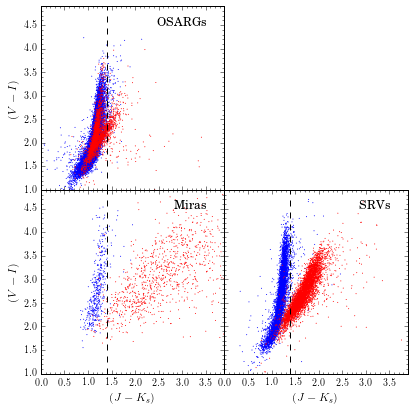

In [24]:
three_cell_plot((ogle_2mass[osargs & orich].coljk, ogle_2mass[osargs & crich].coljk), 
                (ogle_2mass[miras & orich].coljk, ogle_2mass[miras & crich].coljk),
                (ogle_2mass[srvs & orich].coljk, ogle_2mass[srvs & crich].coljk), 
                (ogle_2mass[osargs & orich].colvi, ogle_2mass[osargs & crich].colvi),
                (ogle_2mass[miras & orich].colvi, ogle_2mass[miras & crich].colvi), 
                (ogle_2mass[srvs & orich].colvi, ogle_2mass[srvs & crich].colvi),
                xlabel="$(J-K_s)$", ylabel="$(V-I)$", xlims=[0.0, 3.9],
                ylims=[1.0, 4.9], txt1="OSARGs", txt2="Miras", txt3="SRVs",
                vertline=1.4)

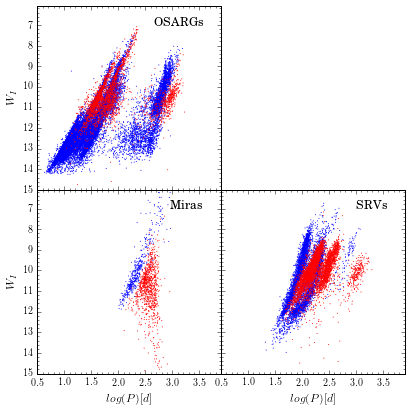

In [25]:
three_cell_plot((np.log10(ogle_2mass[osargs & orich].P_1), np.log10(ogle_2mass[osargs & crich].P_1)), 
                (np.log10(ogle_2mass[miras & orich].P_1), np.log10(ogle_2mass[miras & crich].P_1)),
                (np.log10(ogle_2mass[srvs & orich].P_1), np.log10(ogle_2mass[srvs & crich].P_1)), 
                (ogle_2mass[osargs & orich].W_I, ogle_2mass[osargs & crich].W_I),
                (ogle_2mass[miras & orich].W_I, ogle_2mass[miras & crich].W_I), 
                (ogle_2mass[srvs & orich].W_I, ogle_2mass[srvs & crich].W_I),
                xlabel="$log(P)[d]$", ylabel="$W_I$", xlims=[0.5, 3.9],
                ylims=[6.1, 15], txt1="OSARGs", txt2="Miras", txt3="SRVs", inverted=True)

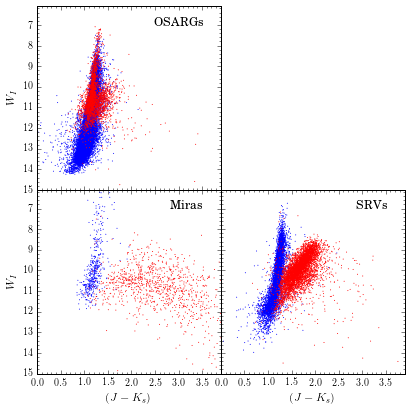

In [26]:
three_cell_plot((ogle_2mass[osargs & orich].coljk, ogle_2mass[osargs & crich].coljk), 
                (ogle_2mass[miras & orich].coljk, ogle_2mass[miras & crich].coljk),
                (ogle_2mass[srvs & orich].coljk, ogle_2mass[srvs & crich].coljk), 
                (ogle_2mass[osargs & orich].W_I, ogle_2mass[osargs & crich].W_I),
                (ogle_2mass[miras & orich].W_I, ogle_2mass[miras & crich].W_I), 
                (ogle_2mass[srvs & orich].W_I, ogle_2mass[srvs & crich].W_I),
                xlabel="$(J-K_s)$", ylabel="$W_I$", xlims=[0.0, 3.9],
                ylims=[6.1, 15], txt1="OSARGs", txt2="Miras", txt3="SRVs", inverted=True)

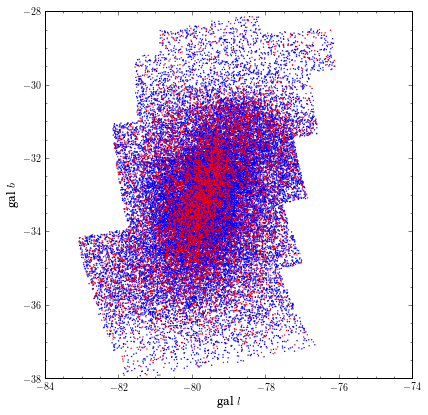

In [27]:
galactic_plot([ogle_2mass[orich].glon, ogle_2mass[crich].glon], 
              [ogle_2mass[orich].glat, ogle_2mass[crich].glat], multi=True,
              xlims=[-84, -74], ylims=[-38, -28])

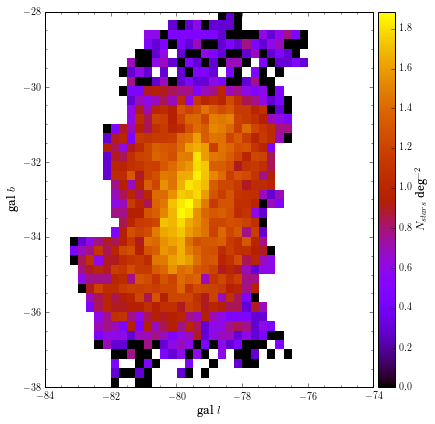

In [28]:
galactic_plot(ogle_2mass[crich].glon, 
              ogle_2mass[crich].glat,
              xlims=[-84, -74], ylims=[-38, -28], hist=True, cbar=True, dx=0.25, dy=0.25)

In [29]:
lmc_table = single_pop_table(ogle_2mass, "OGLE-2MASS AGB Stars")

In [30]:
lmc_table.add_cut("I-mag Sat. Limit", ogle_2mass.I > 12.5)
lmc_table.add_cut("K-mag Faint Limit", ogle_2mass.kmag < 15.5)
lmc_table.add_cut("J-mag Sat. Limit", ogle_2mass.jmag > 1.)
lmc_table.add_cut("K-mag Faint Limit", ogle_2mass.jmag > 8.5)
lmc_table.list_compounded_cuts()

OGLE-2MASS AGB Stars
Cut				Count	% Retention
---------------------------------------------------------
Original:			46431	100.00
+ I-mag Sat. Limit:		46393	99.9181581271
+ K-mag Faint Limit:		46393	99.9181581271
+ J-mag Sat. Limit:		46393	99.9181581271
+ K-mag Faint Limit:		46393	99.9181581271



In [31]:
lmc_wise_table = single_pop_table(ogle_wise, 'OGLE-WISE Matches < 3"')

In [32]:
lmc_wise_table.add_cut("2MASS counterparts", ogle_wise.n2mass == 1)
lmc_wise_table.add_cut("I-mag faint limit", ogle_wise.I > 12.5)
lmc_wise_table.add_cut("W1-W3 sat. limits", (ogle_wise.w1 > 2.) & (ogle_wise.w2 > 1.5) & (ogle_wise.w3 > -3))
lmc_wise_table.add_cut("K saturation limit", ogle_wise.kmag > 8.5)
lmc_wise_table.add_cut("W1 faint limit", ogle_wise.w1 < 16.83)
lmc_wise_table.add_cut("W2 faint limit", ogle_wise.w2 < 15.6)
lmc_wise_table.add_cut("W3 faint limit", ogle_wise.w3 < 11.32)
lmc_wise_table.add_cut("K faint limit", ogle_wise.kmag < 15.5)
lmc_wise_table.add_cut("W1-W3 SNR > 3", (ogle_wise.w1snr > 3) & (ogle_wise.w2snr > 3) & (ogle_wise.w3snr > 3))
lmc_wise_table.add_cut("CC [W1/2/3] = 0", ogle_wise.ccflag.map(lambda flag: flag.startswith("000")))
lmc_wise_table.list_compounded_cuts()

OGLE-WISE Matches < 3"
Cut				Count	% Retention
---------------------------------------------------------
Original:			44013	100.00
+ 2MASS counterparts:		43247	98.2596051167
+ I-mag faint limit:		43209	98.1732669893
+ W1-W3 sat. limits:		43209	98.1732669893
+ K saturation limit:		43201	98.1550905414
+ W1 faint limit:		43201	98.1550905414
+ W2 faint limit:		43200	98.1528184854
+ W3 faint limit:		19358	43.9824597278
+ K faint limit:		19358	43.9824597278
+ W1-W3 SNR > 3:		18995	43.1577034058
+ CC [W1/2/3] = 0:		8454	19.2079612842



In [33]:
mira = ogle_wise.Type == "Mira"
osarg = ogle_wise.Type == "OSARG"
srv = ogle_wise.Type == "SRV"

mira_table = single_pop_table(ogle_wise[mira], 'OGLE-WISE Miras')
osarg_table = single_pop_table(ogle_wise[osarg], 'OGLE-WISE OSARGs')
srv_table = single_pop_table(ogle_wise[srv], 'OGLE-WISE SRVs')

mira_table.add_cut("2MASS counterparts", ogle_wise[mira].n2mass == 1)
mira_table.add_cut("I-mag faint limit", ogle_wise[mira].I > 12.5)
mira_table.add_cut("W1-W3 sat. limits", (ogle_wise[mira].w1 > 2.) & (ogle_wise[mira].w2 > 1.5) & (ogle_wise[mira].w3 > -3))
mira_table.add_cut("K saturation limit", ogle_wise[mira].kmag > 8.5)
mira_table.add_cut("W1 faint limit", ogle_wise[mira].w1 < 16.83)
mira_table.add_cut("W2 faint limit", ogle_wise[mira].w2 < 15.6)
mira_table.add_cut("W3 faint limit", ogle_wise[mira].w3 < 11.32)
mira_table.add_cut("K faint limit", ogle_wise[mira].kmag < 15.5)
mira_table.add_cut("W1-W3 SNR > 3", (ogle_wise[mira].w1snr > 3) & (ogle_wise[mira].w2snr > 3) & (ogle_wise[mira].w3snr > 3))
mira_table.add_cut("CC [W1/2/3] = 0", ogle_wise[mira].ccflag.map(lambda flag: flag.startswith("000")))
mira_table.list_compounded_cuts()

osarg_table.add_cut("2MASS counterparts", ogle_wise[osarg].n2mass == 1)
osarg_table.add_cut("I-mag faint limit", ogle_wise[osarg].I > 12.5)
osarg_table.add_cut("W1-W3 sat. limits", (ogle_wise[osarg].w1 > 2.) & (ogle_wise.w2 > 1.5) & (ogle_wise.w3 > -3))
osarg_table.add_cut("K saturation limit", ogle_wise[osarg].kmag > 8.5)
osarg_table.add_cut("W1 faint limit", ogle_wise[osarg].w1 < 16.83)
osarg_table.add_cut("W2 faint limit", ogle_wise[osarg].w2 < 15.6)
osarg_table.add_cut("W3 faint limit", ogle_wise[osarg].w3 < 11.32)
osarg_table.add_cut("K faint limit", ogle_wise[osarg].kmag < 15.5)
osarg_table.add_cut("W1-W3 SNR > 3", (ogle_wise[osarg].w1snr > 3) & (ogle_wise.w2snr > 3) & (ogle_wise.w3snr > 3))
osarg_table.add_cut("CC [W1/2/3] = 0", ogle_wise[osarg].ccflag.map(lambda flag: flag.startswith("000")))
osarg_table.list_compounded_cuts()

srv_table.add_cut("2MASS counterparts", ogle_wise[srv].n2mass == 1)
srv_table.add_cut("I-mag faint limit", ogle_wise[srv].I > 12.5)
srv_table.add_cut("W1-W3 sat. limits", (ogle_wise[srv].w1 > 2.) & (ogle_wise[srv].w2 > 1.5) & (ogle_wise[srv].w3 > -3))
srv_table.add_cut("K saturation limit", ogle_wise[srv].kmag > 8.5)
srv_table.add_cut("W1 faint limit", ogle_wise[srv].w1 < 16.83)
srv_table.add_cut("W2 faint limit", ogle_wise[srv].w2 < 15.6)
srv_table.add_cut("W3 faint limit", ogle_wise[srv].w3 < 11.32)
srv_table.add_cut("K faint limit", ogle_wise[srv].kmag < 15.5)
srv_table.add_cut("W1-W3 SNR > 3", (ogle_wise[srv].w1snr > 3) & (ogle_wise[srv].w2snr > 3) & (ogle_wise[srv].w3snr > 3))
srv_table.add_cut("CC [W1/2/3] = 0", ogle_wise[srv].ccflag.map(lambda flag: flag.startswith("000")))
srv_table.list_compounded_cuts()


OGLE-WISE Miras
Cut				Count	% Retention
---------------------------------------------------------
Original:			1648	100.00
+ 2MASS counterparts:		1633	99.0898058252
+ I-mag faint limit:		1629	98.8470873786
+ W1-W3 sat. limits:		1629	98.8470873786
+ K saturation limit:		1621	98.3616504854
+ W1 faint limit:		1621	98.3616504854
+ W2 faint limit:		1621	98.3616504854
+ W3 faint limit:		1592	96.6019417476
+ K faint limit:		1592	96.6019417476
+ W1-W3 SNR > 3:		1590	96.4805825243
+ CC [W1/2/3] = 0:		745	45.2063106796

OGLE-WISE OSARGs
Cut				Count	% Retention
---------------------------------------------------------
Original:			31431	100.00
+ 2MASS counterparts:		30756	97.8524386752
+ I-mag faint limit:		30740	97.8015335179
+ W1-W3 sat. limits:		30740	97.8015335179
+ K saturation limit:		30740	97.8015335179
+ W1 faint limit:		30740	97.8015335179
+ W2 faint limit:		30739	97.7983519455
+ W3 faint limit:		9160	29.1432025707
+ K faint limit:		9160	29.1432025707
+ W1-W3 SNR > 3:		8853	28.1664598645

In [34]:
rgbs = add_colors(add_colors_ogle(pd.read_csv("../contaminants/lmcrgbs_allwise_allmags.dat")))
rgbs["W_I"] = rgbs.I - 1.55*(rgbs.V - rgbs.I)

In [35]:
lmc_rgbs_table = single_pop_table(rgbs, 'OGLE RGBs Matches < 3"')

In [36]:
lmc_rgbs_table.add_cut("I-mag faint limit", rgbs.I > 12.5)
lmc_rgbs_table.add_cut("2MASS counterparts", rgbs.n2mass == 1)
lmc_rgbs_table.add_cut("W1-W3 sat. limits", (rgbs.w1 > 2.) & (rgbs.w2 > 1.5) & (rgbs.w3 > -3))
lmc_rgbs_table.add_cut("K saturation limit", rgbs.kmag > 8.5)
lmc_rgbs_table.add_cut("W1 faint limit", rgbs.w1 < 16.83)
lmc_rgbs_table.add_cut("W2 faint limit", rgbs.w2 < 15.6)
lmc_rgbs_table.add_cut("W3 faint limit", rgbs.w3 < 11.32)
lmc_rgbs_table.add_cut("K faint limit", rgbs.kmag < 15.5)
lmc_rgbs_table.add_cut("W1-W3 SNR > 3", (rgbs.w1snr > 3) & (rgbs.w2snr > 3) & (rgbs.w3snr > 3))
lmc_rgbs_table.add_cut("CC [W1/2/3] = 0", rgbs.ccflag.map(lambda flag: flag.startswith("000")))
lmc_rgbs_table.list_compounded_cuts()

OGLE RGBs Matches < 3"
Cut				Count	% Retention
---------------------------------------------------------
Original:			40764	100.00
+ I-mag faint limit:		40764	100.0
+ 2MASS counterparts:		40764	100.0
+ W1-W3 sat. limits:		40763	99.9975468551
+ K saturation limit:		40763	99.9975468551
+ W1 faint limit:		40763	99.9975468551
+ W2 faint limit:		40760	99.9901874203
+ W3 faint limit:		5170	12.6827592974
+ K faint limit:		5170	12.6827592974
+ W1-W3 SNR > 3:		4727	11.5960160926
+ CC [W1/2/3] = 0:		1599	3.92257874595



In [37]:
rgbs_df = lmc_rgbs_table.get_compounded_cuts()

## SDSS Value-added Galaxy Catalog & Luminous Red Giant Survey
[Return to Top](#The-Full-Production-Notebook)

In [38]:
vagc = add_colors(pd.read_csv("../contaminants/vagc_allwise_allmags.dat", sep="\t"))
lrgs = add_colors(pd.read_csv("../contaminants/lrg_allwise_allmags.dat", sep="\t"))

qso = vagc.CLASS == "QSO"
agn = (vagc.SUBCLASS == "AGN") | (vagc.SUBCLASS == " BROADLINE")
sfgal = (vagc.SUBCLASS == "STARFORMING") | (vagc.SUBCLASS == " BROADLINE")
sbgal = (vagc.SUBCLASS == "STARBURST") | (vagc.SUBCLASS == " BROADLINE")

vagc_cuts_table = single_pop_table(vagc, "Value-added Galaxy Catalog Objects Total matched to WISE")
qso_table = single_pop_table(vagc[qso], "VAGC QSOs matched to WISE")
agn_table = single_pop_table(vagc[agn], "VAGC AGN matched to WISE")
sfgal_table = single_pop_table(vagc[sfgal], "VAGC SFGal matched to WISE")
sbgal_table = single_pop_table(vagc[sbgal], "VAGC SBGal matched to WISE")
lrgs_table = single_pop_table(lrgs, "LRG Sample matched to WISE")

In [39]:
# vagc_cuts_table.original_number = 441707
vagc_cuts_table.add_cut("N=1 matches to 2MASS", vagc.n2mass == 1)
vagc_cuts_table.add_cut("WISE saturation lims", (vagc.w1 > 2.) & (vagc.w2 > 1.5) & (vagc.w3 > -3))
vagc_cuts_table.add_cut("WISE saturation w/ K", vagc.kmag > 8.5)
vagc_cuts_table.add_cut("WISE W1 faint limit", vagc.w1 < 16.83)
vagc_cuts_table.add_cut("WISE W2 faint limit", vagc.w2 < 15.6)
vagc_cuts_table.add_cut("WISE W3 faint limit", vagc.w3 < 11.32)
vagc_cuts_table.add_cut("2MASS K faint limit", vagc.kmag < 15.5)
vagc_cuts_table.add_cut("WISE W1/2/3 SNR > 3", (vagc.w1snr > 3) & (vagc.w2snr > 3) & (vagc.w3snr > 3))
vagc_cuts_table.add_cut("W1/2/3 CC flag = 0", vagc.ccflag.map(lambda flag: flag.startswith("000")))

In [40]:
# qso_table.original_number = 122550
qso_table.add_cut("N=1 matches to 2MASS", vagc[qso].n2mass == 1)
qso_table.add_cut("WISE saturation lims", (vagc[qso].w1 > 2.) & (vagc[qso].w2 > 1.5) & (vagc[qso].w3 > -3))
qso_table.add_cut("WISE saturation w/ K", vagc[qso].kmag > 8.5)
qso_table.add_cut("WISE W1 faint limit", vagc[qso].w1 < 16.83)
qso_table.add_cut("WISE W2 faint limit", vagc[qso].w2 < 15.6)
qso_table.add_cut("WISE W3 faint limit", vagc[qso].w3 < 11.32)
qso_table.add_cut("2MASS K faint limit", vagc[qso].kmag < 15.5)
qso_table.add_cut("WISE W1/2/3 SNR > 3", (vagc[qso].w1snr > 3) & (vagc[qso].w2snr > 3) & (vagc[qso].w3snr > 3))
qso_table.add_cut("W1/2/3 CC flag = 0", vagc[qso].ccflag.map(lambda flag: flag.startswith("000")))

In [41]:
# agn_table.original_number = 19184
agn_table.add_cut("N=1 matches to 2MASS", vagc[agn].n2mass == 1)
agn_table.add_cut("WISE saturation lims", (vagc[agn].w1 > 2.) & (vagc[agn].w2 > 1.5) & (vagc[agn].w3 > -3))
agn_table.add_cut("WISE saturation w/ K", vagc[agn].kmag > 8.5)
agn_table.add_cut("WISE W1 faint limit", vagc[agn].w1 < 16.83)
agn_table.add_cut("WISE W2 faint limit", vagc[agn].w2 < 15.6)
agn_table.add_cut("WISE W3 faint limit", vagc[agn].w3 < 11.32)
agn_table.add_cut("2MASS K faint limit", vagc[agn].kmag < 15.5)
agn_table.add_cut("WISE W1/2/3 SNR > 3", (vagc[agn].w1snr > 3) & (vagc[agn].w2snr > 3) & (vagc[agn].w3snr > 3))
agn_table.add_cut("W1/2/3 CC flag = 0", vagc[agn].ccflag.map(lambda flag: flag.startswith("000")))

In [42]:
# sfgal_table.original_number = 232845
sfgal_table.add_cut("N=1 matches to 2MASS", vagc[sfgal].n2mass == 1)
sfgal_table.add_cut("WISE saturation lims", (vagc[sfgal].w1 > 2.) & (vagc[sfgal].w2 > 1.5) & (vagc[sfgal].w3 > -3))
sfgal_table.add_cut("WISE saturation w/ K", vagc[sfgal].kmag > 8.5)
sfgal_table.add_cut("WISE W1 faint limit", vagc[sfgal].w1 < 16.83)
sfgal_table.add_cut("WISE W2 faint limit", vagc[sfgal].w2 < 15.6)
sfgal_table.add_cut("WISE W3 faint limit", vagc[sfgal].w3 < 11.32)
sfgal_table.add_cut("2MASS K faint limit", vagc[sfgal].kmag < 15.5)
sfgal_table.add_cut("WISE W1/2/3 SNR > 3", (vagc[sfgal].w1snr > 3) & (vagc[sfgal].w2snr > 3) & (vagc[sfgal].w3snr > 3))
sfgal_table.add_cut("W1/2/3 CC flag = 0", vagc[sfgal].ccflag.map(lambda flag: flag.startswith("000")))

In [43]:
# sbgal_table.original_number = 67128
sbgal_table.add_cut("N=1 matches to 2MASS", vagc[sbgal].n2mass == 1)
sbgal_table.add_cut("WISE saturation lims", (vagc[sbgal].w1 > 2.) & (vagc[sbgal].w2 > 1.5) & (vagc[sbgal].w3 > -3))
sbgal_table.add_cut("WISE saturation w/ K", vagc[sbgal].kmag > 8.5)
sbgal_table.add_cut("WISE W1 faint limit", vagc[sbgal].w1 < 16.83)
sbgal_table.add_cut("WISE W2 faint limit", vagc[sbgal].w2 < 15.6)
sbgal_table.add_cut("WISE W3 faint limit", vagc[sbgal].w3 < 11.32)
sbgal_table.add_cut("2MASS K faint limit", vagc[sbgal].kmag < 15.5)
sbgal_table.add_cut("WISE W1/2/3 SNR > 3", (vagc[sbgal].w1snr > 3) & (vagc[sbgal].w2snr > 3) & (vagc[sbgal].w3snr > 3))
sbgal_table.add_cut("W1/2/3 CC flag = 0", vagc[sbgal].ccflag.map(lambda flag: flag.startswith("000")))

In [44]:
# lrgs_cuts_table.original_number = 105631
lrgs_table.add_cut("N=1 matches to 2MASS", lrgs.n2mass == 1)
lrgs_table.add_cut("WISE saturation lims", (lrgs.w1 > 2.) & (lrgs.w2 > 1.5) & (lrgs.w3 > -3))
lrgs_table.add_cut("WISE saturation w/ K", lrgs.kmag > 8.5)
lrgs_table.add_cut("WISE W1 faint limit", lrgs.w1 < 16.83)
lrgs_table.add_cut("WISE W2 faint limit", lrgs.w2 < 15.6)
lrgs_table.add_cut("WISE W3 faint limit", lrgs.w3 < 11.32)
lrgs_table.add_cut("2MASS K faint limit", lrgs.kmag < 15.5)
lrgs_table.add_cut("WISE W1/2/3 SNR > 3", (lrgs.w1snr > 3) & (lrgs.w2snr > 3) & (lrgs.w3snr > 3))
lrgs_table.add_cut("W1/2/3 CC flag = 0", lrgs.ccflag.map(lambda flag: flag.startswith("000")))

In [45]:
vagc_cuts_table.list_compounded_cuts()
qso_table.list_compounded_cuts()
agn_table.list_compounded_cuts()
sfgal_table.list_compounded_cuts()
sbgal_table.list_compounded_cuts()
lrgs_table.list_compounded_cuts()

Value-added Galaxy Catalog Objects Total matched to WISE
Cut				Count	% Retention
---------------------------------------------------------
Original:			317626	100.00
+ N=1 matches to 2MASS:		251102	79.0558707411
+ WISE saturation lims:		251059	79.0423328065
+ WISE saturation w/ K:		250041	78.7218300769
+ WISE W1 faint limit:		250041	78.7218300769
+ WISE W2 faint limit:		249708	78.616989793
+ WISE W3 faint limit:		242005	76.1918104941
+ 2MASS K faint limit:		230437	72.5497912639
+ WISE W1/2/3 SNR > 3:		229601	72.2865886294
+ W1/2/3 CC flag = 0:		212021	66.7517772475

VAGC QSOs matched to WISE
Cut				Count	% Retention
---------------------------------------------------------
Original:			19045	100.00
+ N=1 matches to 2MASS:		6902	36.2404830664
+ WISE saturation lims:		6901	36.2352323444
+ WISE saturation w/ K:		6900	36.2299816225
+ WISE W1 faint limit:		6900	36.2299816225
+ WISE W2 faint limit:		6891	36.1827251247
+ WISE W3 faint limit:		6728	35.3268574429
+ 2MASS K faint limit:		5283	27.

In [46]:
ogle_wise_df = lmc_wise_table.get_compounded_cuts()
qso_df = qso_table.get_compounded_cuts()
agn_df = agn_table.get_compounded_cuts()
sfgal_df = sfgal_table.get_compounded_cuts()
sbgal_df = sbgal_table.get_compounded_cuts()
lrgs_df = lrgs_table.get_compounded_cuts()

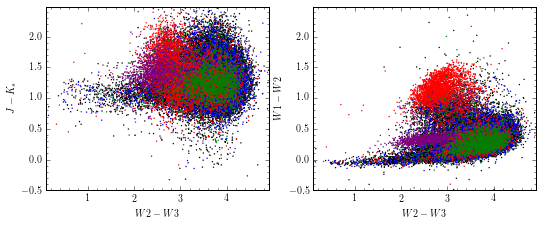

In [47]:
two_cell_plot((sfgal_df.col23, sbgal_df.col23, qso_df.col23, agn_df.col23, lrgs_df.col23),
              (sfgal_df.col23, sbgal_df.col23, qso_df.col23, agn_df.col23, lrgs_df.col23),
              (sfgal_df.coljk, sbgal_df.coljk, qso_df.coljk, agn_df.coljk, lrgs_df.coljk),
              (sfgal_df.col12, sbgal_df.col12, qso_df.col12, agn_df.col12, lrgs_df.col12),
              xlabels_arr=["$W2-W3$", "$W2-W3$"], ylabels_arr=["$J-K_s$","$W1-W2$"],
              orientation="horizontal", xlim_arr=[[0.1, 4.9], [0.1, 4.9]],
              ylim_arr=[[-0.5, 2.49],[-0.5, 2.49]], multi=True)

In [48]:
locus = add_colors(pd.read_csv("../contaminants/allwise_lmc_locus.dat", sep=","))
locus_table = single_pop_table(locus, "Stars from the LMC Stellar Locus")
# locus_cuts_table.original_number = 25,254
locus_table.add_cut("WISE saturation w/ K", locus.kmag > 8.5)
locus_table.add_cut("WISE W1 faint limit", locus.w1 < 16.83)
locus_table.add_cut("WISE W2 faint limit", locus.w2 < 15.6)
locus_table.add_cut("WISE W3 faint limit", locus.w3 < 11.32)
locus_table.add_cut("2MASS K faint limit", locus.kmag < 15.5)
locus_table.add_cut("WISE W1/2/3 SNR > 3", (locus.w1snr > 3) & (locus.w2snr > 3) & (locus.w3snr > 3))
locus_table.add_cut("W1/2/3 CC flag = 0", locus.ccflag.map(lambda flag: flag.startswith("000")))

In [49]:
locus_table.list_compounded_cuts()
locus_df = locus_table.get_compounded_cuts()

Stars from the LMC Stellar Locus
Cut				Count	% Retention
---------------------------------------------------------
Original:			25254	100.00
+ WISE saturation w/ K:		25156	99.6119426625
+ WISE W1 faint limit:		25154	99.604023125
+ WISE W2 faint limit:		24382	96.5470816504
+ WISE W3 faint limit:		3154	12.4891106359
+ 2MASS K faint limit:		3070	12.156490061
+ WISE W1/2/3 SNR > 3:		3056	12.1010532985
+ W1/2/3 CC flag = 0:		3056	12.1010532985



In [50]:
jrad_locus = pd.read_csv("../contaminants/davenport14_full_locus.txt", sep=",")
jrad_locus = jrad_locus[jrad_locus.col12 >= -0.01]
jrad_locus.sort(columns="col12", inplace=True)
jrad_locus.reset_index(inplace=True)

/Users/Nick/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


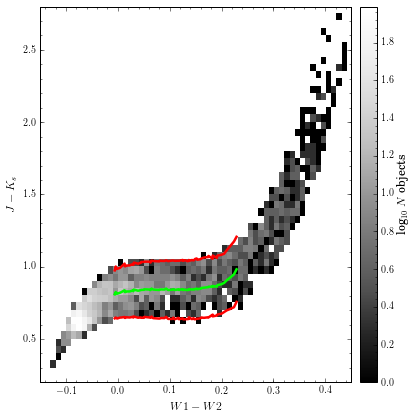

In [51]:
fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(wspace=0.25, hspace=0.25, left=0.12,
                    right=0.84, top=0.97, bottom=0.1)
ax = plt.subplot(111)
# ax.scatter(locus_df.col12, locus_df.coljk, s=5, edgecolor=None, c='k')
dx = 0.01
dy = 0.05
bins = (np.arange(-0.2, 0.5 + dx, dx), np.arange(0, 3+dy, dy))
H, xed, yed = np.histogram2d(locus_df.col12, locus_df.coljk, bins=bins)
extent = [xed[0], xed[-1], yed[0], yed[-1]]
imap = ax.imshow(np.log10(H.T), extent=extent, origin="lower", aspect="auto",
          interpolation="nearest", cmap=plt.cm.Greys_r)

cax = fig.add_axes([0.86, 0.1, 0.04, 0.87]) 
cbar = plt.colorbar(imap, cax = cax)
cbar.ax.set_ylabel("log$_{10}$ $N$ objects", fontsize=12)
cbar.ax.minorticks_on()

ax.plot(jrad_locus.col12, jrad_locus.coljk, color='#00FF00', linewidth=2.5)
ax.plot(jrad_locus.col12, jrad_locus.coljk + jrad_locus.sigjk*3, color='r', linewidth=2.5)
ax.plot(jrad_locus.col12, jrad_locus.coljk - jrad_locus.sigjk*3, color='r', linewidth=2.5)
ax.set_xlabel("$W1-W2$")
ax.set_xlim(-0.15, 0.45)
ax.set_ylabel("$J-K_s$")
ax.set_ylim(0.2, 2.8)
ax.minorticks_on()
plt.savefig(fig_dir + "lmc_locus_3sig.png")
plt.show()

## Calculating Completeness and Contamination Fractions
[Return to Top](#The-Full-Production-Notebook)

In [52]:
# Conversion factor for SDSS objects. SDSS DR7 photometry surveyed an area of
# 10,417 sq. degrees. The LMC is 76.5 square degrees in area. Need to convert
# from number density from the SDSS footprint to estimated numbers in the LMC
area_conv = 76.5/10417

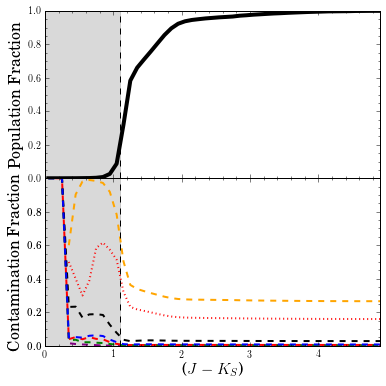

OGLE AGBs retained (%) 91.29 (7718)

Stellar Locus contamination (%) 4.86 (394)
RGB contamination (%) 9.65 (824)
LRG contamination (%) 0.08 (998)
QSO contamination (%) 0.25 (3915)
AGN contamination (%) 0.13 (1730)
SF Gal contamination (%) 0.56 (24092)
SB Gal contamination (%) 0.33 (6157)


In [53]:
bins = np.arange(0, 5+0.1, 0.1)
jklim = 1.1

H_loc, edges = np.histogram(locus_df.coljk, bins=bins)
H_ow, edges = np.histogram(ogle_wise_df.coljk, bins=bins)
H_lrg, edges = np.histogram(lrgs_df.coljk, bins=bins)
H_rgb, edges = np.histogram(rgbs_df.coljk, bins=bins) # RGBs
# H_yso, edges = np.histogram(ysos[ysoscut].coljk, bins=bins)
H1, edges = np.histogram(qso_df.coljk, bins=bins) # QSO
H2, edges = np.histogram(agn_df.coljk, bins=bins) # AGN
H3, edges = np.histogram(sfgal_df.coljk, bins=bins) # SF
H4, edges = np.histogram(sbgal_df.coljk, bins=bins) # SB

dx = (edges[1]-edges[0])/2.

fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(hspace=0)
ax1 = fig.add_subplot(211)
ax1.plot(edges[:-1]+dx, H_ow.cumsum()/float(H_ow.sum()), color="k", linewidth=4)
ax1.plot([jklim, jklim], [0,1.0], color='k', linestyle="--")
ax1.fill_between([bins[0], jklim], [0,0], [1.0,1.0], color='k', alpha=0.15)

ax2 = fig.add_subplot(212)
ax2.plot(edges[:-1]+dx, H_loc.cumsum()/(H_loc.cumsum(dtype=float) + H_ow.cumsum()), color="orange", linewidth=2, linestyle="--")
ax2.plot(edges[:-1]+dx, H_rgb.cumsum()/(H_rgb.cumsum(dtype=float) + H_ow.cumsum()), color="r", linewidth=2, linestyle=":")
ax2.plot(edges[:-1]+dx, H_lrg.cumsum()*area_conv/(H_lrg.cumsum(dtype=float)*area_conv + H_ow.cumsum()), color="purple", linewidth=2, linestyle="--")
# ax2.plot(edges[:-1]+dx, H_yso.cumsum()/float(H_yso.sum()), color="r", linestyle=":")
ax2.plot(edges[:-1]+dx, H1.cumsum()*area_conv/(H1.cumsum(dtype=float)*area_conv + H_ow.cumsum()), color="r", linewidth=2, linestyle="--")
ax2.plot(edges[:-1]+dx, H2.cumsum()*area_conv/(H2.cumsum(dtype=float)*area_conv + H_ow.cumsum()), color="g", linewidth=2, linestyle="--")
ax2.plot(edges[:-1]+dx, H3.cumsum()*area_conv/(H3.cumsum(dtype=float)*area_conv + H_ow.cumsum()), color="k", linewidth=2, linestyle="--")
ax2.plot(edges[:-1]+dx, H4.cumsum()*area_conv/(H4.cumsum(dtype=float)*area_conv + H_ow.cumsum()), color="b", linewidth=2, linestyle="--")
ax2.plot([jklim, jklim], [0,1.0], color='k', linestyle="--")
ax2.fill_between([bins[0], jklim], [0,0], [1.0,1.0], color='k', alpha=0.15)

# ============ Labels and such

ax1.minorticks_on()
ax1.set_xlim(bins[0], bins[-2])
ax1.set_xticklabels([])
ax1.set_ylabel("Population Fraction", fontsize=16)

ax2.minorticks_on()
ax2.set_xlim(bins[0], bins[-2])
ax2.set_xlabel("($J-K_S$)", fontsize=16)
ax2.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8])
ax2.set_ylabel("Contamination Fraction", fontsize=16)
plt.savefig("../figures/completeness_contamination_jkcut.pdf")
plt.show()

N_ogle = sum(ogle_wise_df.coljk > jklim)
N_locus = sum(locus_df.coljk > jklim)
N_rgbs = sum(rgbs_df.coljk > jklim)
N_lrgs = sum(lrgs_df.coljk > jklim)
N_qso = sum(qso_df.coljk > jklim)
N_agn = sum(agn_df.coljk > jklim)
N_sfgal = sum(sfgal_df.coljk > jklim)
N_sbgal = sum(sbgal_df.coljk > jklim)

print "OGLE AGBs retained (%%) %.2f (%g)\n" % (N_ogle * 1.0 / len(ogle_wise_df) * 100, N_ogle)
print "Stellar Locus contamination (%%) %.2f (%g)" % (N_locus * 1.0 / (N_locus + N_ogle) * 100, N_locus)
print "RGB contamination (%%) %.2f (%g)" % (N_rgbs * 1.0 / (N_rgbs + N_ogle) * 100, N_rgbs)
print "LRG contamination (%%) %.2f (%g)" % (N_lrgs * area_conv / (N_lrgs + N_ogle) * 100, N_lrgs)
print "QSO contamination (%%) %.2f (%g)" % (N_qso * area_conv / (N_qso + N_ogle) * 100, N_qso)
print "AGN contamination (%%) %.2f (%g)" % (N_agn * area_conv / (N_agn + N_ogle) * 100, N_agn)
print "SF Gal contamination (%%) %.2f (%g)" % (N_sfgal * area_conv / (N_sfgal + N_ogle) * 100, N_sfgal)
print "SB Gal contamination (%%) %.2f (%g)" % (N_sbgal * area_conv / (N_sbgal + N_ogle) * 100, N_sbgal)


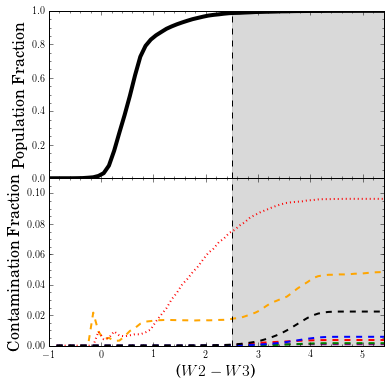

OGLE AGBs retained (%) 90.03 (7611)

Stellar Locus contamination (%) 1.73 (134)
RGB contamination (%) 7.41 (609)
LRG contamination (%) 0.04 (470)
QSO contamination (%) 0.03 (311)
AGN contamination (%) 0.00 (36)
SF Gal contamination (%) 0.05 (613)
SB Gal contamination (%) 0.01 (152)


In [54]:
bins = np.arange(-1, 5.5+0.1, 0.1)
jklim = 1.1
w23hi = 2.5

H_loc, edges = np.histogram(locus_df[locus_df.coljk > jklim].col23, bins=bins)
H_rgb, edges = np.histogram(rgbs_df[rgbs_df.coljk > jklim].col23, bins=bins) # RGBs
H_ow, edges = np.histogram(ogle_wise_df[ogle_wise_df.coljk > jklim].col23, bins=bins)
H_lrg, edges = np.histogram(lrgs_df[lrgs_df.coljk > jklim].col23, bins=bins)
# H_yso, edges = np.histogram(ysos[ysoscut].coljk, bins=bins)
H1, edges = np.histogram(qso_df[qso_df.coljk > jklim].col23, bins=bins) # QSO
H2, edges = np.histogram(agn_df[agn_df.coljk > jklim].col23, bins=bins) # AGN
H3, edges = np.histogram(sfgal_df[sfgal_df.coljk > jklim].col23, bins=bins) # SF
H4, edges = np.histogram(sbgal_df[sbgal_df.coljk > jklim].col23, bins=bins) # SB

dx = (edges[1]-edges[0])/2.

fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(hspace=0)
ax1 = fig.add_subplot(211)
ax1.plot(edges[:-1]+dx, H_ow.cumsum()/float(H_ow.sum()), color="k", linewidth=4)
ax1.plot([w23hi, w23hi], [0,1.0], color='k', linestyle="--")
ax1.fill_between([w23hi, bins[-1]], [0,0], [1.0,1.0], color='k', alpha=0.15)

ax2 = fig.add_subplot(212)
ax2.plot(edges[:-1]+dx, H_loc.cumsum()/(H_loc.cumsum(dtype=float) + H_ow.cumsum()), color="orange", linewidth=2, linestyle="--")
ax2.plot(edges[:-1]+dx, H_rgb.cumsum()/(H_rgb.cumsum(dtype=float) + H_ow.cumsum()), color="r", linewidth=2, linestyle=":")
ax2.plot(edges[:-1]+dx, H_lrg.cumsum()*area_conv/(H_lrg.cumsum(dtype=float)*area_conv + H_ow.cumsum()), color="purple", linewidth=2, linestyle="--")
# ax2.plot(edges[:-1]+dx, H_yso.cumsum()/float(H_yso.sum()), color="r", linestyle=":")
ax2.plot(edges[:-1]+dx, H1.cumsum()*area_conv/(H1.cumsum(dtype=float)*area_conv + H_ow.cumsum()), color="r", linewidth=2, linestyle="--")
ax2.plot(edges[:-1]+dx, H2.cumsum()*area_conv/(H2.cumsum(dtype=float)*area_conv + H_ow.cumsum()), color="g", linewidth=2, linestyle="--")
ax2.plot(edges[:-1]+dx, H4.cumsum()*area_conv/(H4.cumsum(dtype=float)*area_conv + H_ow.cumsum()), color="b", linewidth=2, linestyle="--")
ax2.plot(edges[:-1]+dx, H3.cumsum()*area_conv/(H3.cumsum(dtype=float)*area_conv + H_ow.cumsum()), color="k", linewidth=2, linestyle="--")
ax2.plot([w23hi, w23hi], [0,1.0], color='k', linestyle="--")
ax2.fill_between([w23hi, bins[-1]], [0,0], [1.0,1.0], color='k', alpha=0.15)

# ============ Labels and such

ax1.minorticks_on()
ax1.set_xlim(bins[0], bins[-2])
ax1.set_xticklabels([])
ax1.set_ylabel("Population Fraction", fontsize=16)

ax2.minorticks_on()
ax2.set_xlim(bins[0], bins[-2])
ax2.set_xlabel("($W2-W3$)", fontsize=16)
ax2.set_ylim(0,0.11)
# ax2.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8])
ax2.set_ylabel("Contamination Fraction", fontsize=16)
plt.savefig("../figures/completeness_contamination_w23cut.pdf")
plt.show()

N_ogle = sum((ogle_wise_df.coljk > jklim) & (ogle_wise_df.col23 < w23hi))
N_locus = sum((locus_df.coljk > jklim) & (locus_df.col23 < w23hi))
N_rgbs = sum((rgbs_df.coljk > jklim) & (rgbs_df.col23 < w23hi))
N_lrgs = sum((lrgs_df.coljk > jklim) & (lrgs_df.col23 < w23hi))
N_qso = sum((qso_df.coljk > jklim) & (qso_df.col23 < w23hi))
N_agn = sum((agn_df.coljk > jklim) & (agn_df.col23 < w23hi))
N_sfgal = sum((sfgal_df.coljk > jklim) & (sfgal_df.col23 < w23hi))
N_sbgal = sum((sbgal_df.coljk > jklim) & (sbgal_df.col23 < w23hi))

print "OGLE AGBs retained (%%) %.2f (%g)\n" % (N_ogle * 1.0 / len(ogle_wise_df) * 100, N_ogle)
print "Stellar Locus contamination (%%) %.2f (%g)" % (N_locus * 1.0 / (N_locus + N_ogle) * 100, N_locus)
print "RGB contamination (%%) %.2f (%g)" % (N_rgbs * 1.0 / (N_rgbs + N_ogle) * 100, N_rgbs)
print "LRG contamination (%%) %.2f (%g)" % (N_lrgs * area_conv / (N_lrgs + N_ogle) * 100, N_lrgs)
print "QSO contamination (%%) %.2f (%g)" % (N_qso * area_conv / (N_qso + N_ogle) * 100, N_qso)
print "AGN contamination (%%) %.2f (%g)" % (N_agn * area_conv / (N_agn + N_ogle) * 100, N_agn)
print "SF Gal contamination (%%) %.2f (%g)" % (N_sfgal * area_conv / (N_sfgal + N_ogle) * 100, N_sfgal)
print "SB Gal contamination (%%) %.2f (%g)" % (N_sbgal * area_conv / (N_sbgal + N_ogle) * 100, N_sbgal)


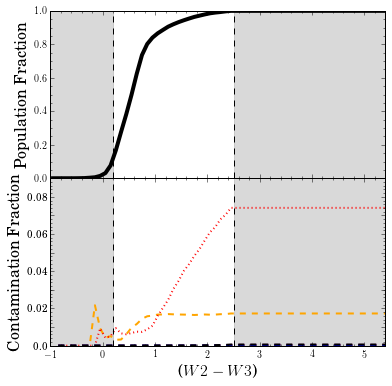

OGLE AGBs retained (%) 83.13 (7028)

Stellar Locus contamination (%) 1.83 (131)
RGB contamination (%) 7.94 (606)
LRG contamination (%) 0.05 (470)
QSO contamination (%) 0.03 (311)
AGN contamination (%) 0.00 (36)
SF Gal contamination (%) 0.06 (613)
SB Gal contamination (%) 0.02 (152)


In [55]:
bins = np.arange(-1, 5.5+0.1, 0.1)
jklim = 1.1
w23hi = 2.5
w23lo = 0.2

H_loc, edges = np.histogram(locus_df[(locus_df.coljk > jklim) & (locus_df.col23 < w23hi)].col23, bins=bins)
H_ow, edges = np.histogram(ogle_wise_df[(ogle_wise_df.coljk > jklim) & (ogle_wise_df.col23 < w23hi)].col23, bins=bins)
H_rgb, edges = np.histogram(rgbs_df[(rgbs_df.coljk > jklim) & (rgbs_df.col23 < w23hi)].col23, bins=bins) # RGBs
H_lrg, edges = np.histogram(lrgs_df[(lrgs_df.coljk > jklim) & (lrgs_df.col23 < w23hi)].col23, bins=bins)
# H_yso, edges = np.histogram(ysos[ysoscut].coljk, bins=bins)
H1, edges = np.histogram(qso_df[(qso_df.coljk > jklim) & (qso_df.col23 < w23hi)].col23, bins=bins) # QSO
H2, edges = np.histogram(agn_df[(agn_df.coljk > jklim) & (agn_df.col23 < w23hi)].col23, bins=bins) # AGN
H3, edges = np.histogram(sfgal_df[(sfgal_df.coljk > jklim) & (sfgal_df.col23 < w23hi)].col23, bins=bins) # SF
H4, edges = np.histogram(sbgal_df[(sbgal_df.coljk > jklim) & (sbgal_df.col23 < w23hi)].col23, bins=bins) # SB

dx = (edges[1]-edges[0])/2.

fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(hspace=0)
ax1 = fig.add_subplot(211)
ax1.plot(edges[:-1]+dx, H_ow.cumsum()/float(H_ow.sum()), color="k", linewidth=4)
ax1.plot([w23hi, w23hi], [0,1.0], color='k', linestyle="--")
ax1.plot([w23lo, w23lo], [0,1.0], color='k', linestyle="--")
ax1.fill_between([w23hi, 10], [0,0], [1.0,1.0], color='k', alpha=0.15)
ax1.fill_between([bins[0], w23lo], [0,0], [1.0,1.0], color='k', alpha=0.15)

ax2 = fig.add_subplot(212)
ax2.plot(edges[:-1]+dx, H_loc.cumsum()/(H_loc.cumsum(dtype=float) + H_ow.cumsum()), color="orange", linewidth=2, linestyle="--")
ax2.plot(edges[:-1]+dx, H_rgb.cumsum()/(H_rgb.cumsum(dtype=float) + H_ow.cumsum()), color="r", linewidth=2, linestyle=":")
ax2.plot(edges[:-1]+dx, H_lrg.cumsum()*area_conv/(H_lrg.cumsum(dtype=float)*area_conv + H_ow.cumsum()), color="purple", linewidth=2, linestyle="--")
# ax2.plot(edges[:-1]+dx, H_yso.cumsum()/float(H_yso.sum()), color="r", linestyle=":")
ax2.plot(edges[:-1]+dx, H1.cumsum()*area_conv/(H1.cumsum(dtype=float)*area_conv + H_ow.cumsum()), color="r", linewidth=2, linestyle="--")
ax2.plot(edges[:-1]+dx, H2.cumsum()*area_conv/(H2.cumsum(dtype=float)*area_conv + H_ow.cumsum()), color="g", linewidth=2, linestyle="--")
ax2.plot(edges[:-1]+dx, H4.cumsum()*area_conv/(H4.cumsum(dtype=float)*area_conv + H_ow.cumsum()), color="b", linewidth=2, linestyle="--")
ax2.plot(edges[:-1]+dx, H3.cumsum()*area_conv/(H3.cumsum(dtype=float)*area_conv + H_ow.cumsum()), color="k", linewidth=2, linestyle="--")
ax2.plot([w23hi, w23hi], [0,1.0], color='k', linestyle="--")
ax2.plot([w23lo, w23lo], [0,1.0], color='k', linestyle="--")
ax2.fill_between([w23hi, 10], [0,0], [1.0,1.0], color='k', alpha=0.15)
ax2.fill_between([bins[0], w23lo], [0,0], [1.0,1.0], color='k', alpha=0.15)

# ============ Labels and such

ax1.minorticks_on()
ax1.set_xlim(bins[0], bins[-2])
ax1.set_xticklabels([])
ax1.set_ylabel("Population Fraction", fontsize=16)

ax2.minorticks_on()
ax2.set_xlim(bins[0], bins[-2])
ax2.set_xlabel("($W2-W3$)", fontsize=16)
ax2.set_ylim(0,0.09)
ax2.set_yticklabels([0.0, "", 0.02, "", 0.04, "", 0.06, "", 0.08, ""])
ax2.set_ylabel("Contamination Fraction", fontsize=16)
plt.savefig("../figures/completeness_contamination_allcuts.pdf")
plt.show()

N_ogle = sum((ogle_wise_df.coljk > jklim) & (ogle_wise_df.col23 < w23hi) & (ogle_wise_df.col23 > w23lo))
N_locus = sum((locus_df.coljk > jklim) & (locus_df.col23 < w23hi) & (locus_df.col23 > w23lo))
N_rgbs = sum((rgbs_df.coljk > jklim) & (rgbs_df.col23 < w23hi) & (rgbs_df.col23 > w23lo))
N_lrgs = sum((lrgs_df.coljk > jklim) & (lrgs_df.col23 < w23hi) & (lrgs_df.col23 > w23lo))
N_qso = sum((qso_df.coljk > jklim) & (qso_df.col23 < w23hi) & (qso_df.col23 > w23lo))
N_agn = sum((agn_df.coljk > jklim) & (agn_df.col23 < w23hi) & (agn_df.col23 > w23lo))
N_sfgal = sum((sfgal_df.coljk > jklim) & (sfgal_df.col23 < w23hi) & (sfgal_df.col23 > w23lo))
N_sbgal = sum((sbgal_df.coljk > jklim) & (sbgal_df.col23 < w23hi) & (sbgal_df.col23 > w23lo))

print "OGLE AGBs retained (%%) %.2f (%g)\n" % (N_ogle * 1.0 / len(ogle_wise_df) * 100, N_ogle)
print "Stellar Locus contamination (%%) %.2f (%g)" % (N_locus * 1.0 / (N_locus + N_ogle) * 100, N_locus)
print "RGB contamination (%%) %.2f (%g)" % (N_rgbs * 1.0 / (N_rgbs + N_ogle) * 100, N_rgbs)
print "LRG contamination (%%) %.2f (%g)" % (N_lrgs * area_conv / (N_lrgs + N_ogle) * 100, N_lrgs)
print "QSO contamination (%%) %.2f (%g)" % (N_qso * area_conv / (N_qso + N_ogle) * 100, N_qso)
print "AGN contamination (%%) %.2f (%g)" % (N_agn * area_conv / (N_agn + N_ogle) * 100, N_agn)
print "SF Gal contamination (%%) %.2f (%g)" % (N_sfgal * area_conv / (N_sfgal + N_ogle) * 100, N_sfgal)
print "SB Gal contamination (%%) %.2f (%g)" % (N_sbgal * area_conv / (N_sbgal + N_ogle) * 100, N_sbgal)


0.2


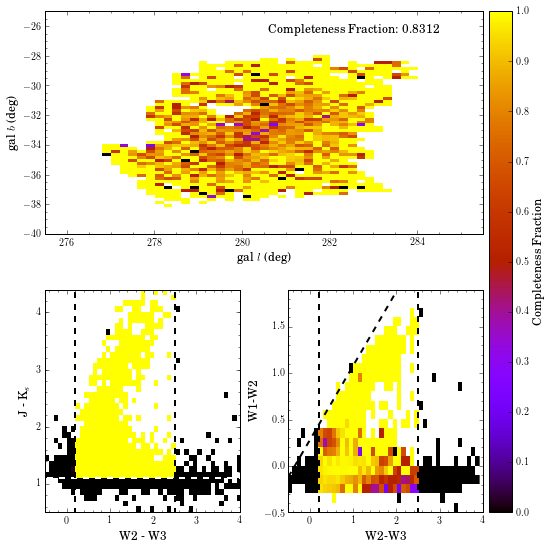

In [56]:
plot_comparison(agb_cuts(ogle_wise_df), ogle_wise_df, binsize=0.2,
                cmap=plt.cm.gnuplot, figsize=(8,8), w23hi=w23hi,
                w23lo=w23lo, jklim=jklim, vmin=0,
                upper=[0.8, 0.28], outfile="../figures/ogle_completeness_map.png")

## Accounting for YSOs using the Taurus Field
[Return to Top](#The-Full-Production-Notebook)

In [57]:
ysos_taurus = pd.read_csv("../contaminants/ysos_taurus_allmags.dat", ",")
ysos_taurus.varflg = ysos_taurus.varflg.astype(str).replace("nan", "nnnn")
ysos_taurus.ccflag = ysos_taurus.ccflag.astype(str).replace("nan", "HHHH")

In [58]:
lmc = pd.read_csv("../contaminants/allwise_lmc_cut.dat", "\t")
lmc = photo_cuts(add_colors(lmc[(lmc.glon < 290) & (lmc.glat > -40)]))

/Users/Nick/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/Nick/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/Nick/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_ne

In [59]:
wise_field1 = photo_cuts(read_gator("../yso_work/wise_field1.tbl"))
wise_field2 = photo_cuts(read_gator("../yso_work/wise_field2.tbl"))
wise_field3 = photo_cuts(read_gator("../yso_work/wise_field3.tbl"))
wise_field4 = photo_cuts(read_gator("../yso_work/wise_field4.tbl"))

taurus_field = read_gator("../yso_work/taurus_field.tbl")

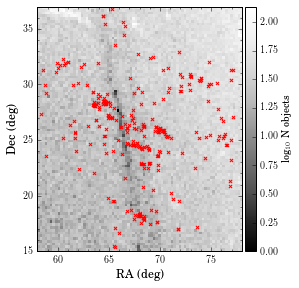

In [60]:
overplot_distr(taurus_field, ysos_taurus, figsize=(4,4),
               colorbar=True, savefig="taurus_field_YSOs.pdf")

In [61]:
ysos_table = single_pop_table(ysos_taurus, "All Taurus Stars from Rebull et al 2011")

In [62]:
ysos_table.add_cut("N=1 matches to 2MASS", ysos_taurus.n2mass == 1)
ysos_table.add_cut("WISE saturation lims", (ysos_taurus.w1 > 2.) & (ysos_taurus.w2 > 1.5) & (ysos_taurus.w3 > -3))
ysos_table.add_cut("WISE saturation w/ K", ysos_taurus.kmag > 8.5)
ysos_table.add_cut("WISE W1 faint limit", ysos_taurus.w1 < 16.83)
ysos_table.add_cut("WISE W2 faint limit", ysos_taurus.w2 < 15.6)
ysos_table.add_cut("WISE W3 faint limit", ysos_taurus.w3 < 11.32)
ysos_table.add_cut("2MASS K faint limit", ysos_taurus.kmag < 15.5)
ysos_table.add_cut("WISE W1/2/3 SNR > 3", (ysos_taurus.w1snr > 3) & (ysos_taurus.w2snr > 3) & (ysos_taurus.w3snr > 3))
ysos_table.add_cut("W1/2/3 CC flag = 0", ysos_taurus.ccflag.map(lambda flag: flag.startswith("000")))
ysos_table.list_compounded_cuts()

All Taurus Stars from Rebull et al 2011
Cut				Count	% Retention
---------------------------------------------------------
Original:			290	100.00
+ N=1 matches to 2MASS:		274	94.4827586207
+ WISE saturation lims:		272	93.7931034483
+ WISE saturation w/ K:		214	73.7931034483
+ WISE W1 faint limit:		214	73.7931034483
+ WISE W2 faint limit:		214	73.7931034483
+ WISE W3 faint limit:		214	73.7931034483
+ 2MASS K faint limit:		213	73.4482758621
+ WISE W1/2/3 SNR > 3:		213	73.4482758621
+ W1/2/3 CC flag = 0:		174	60.0



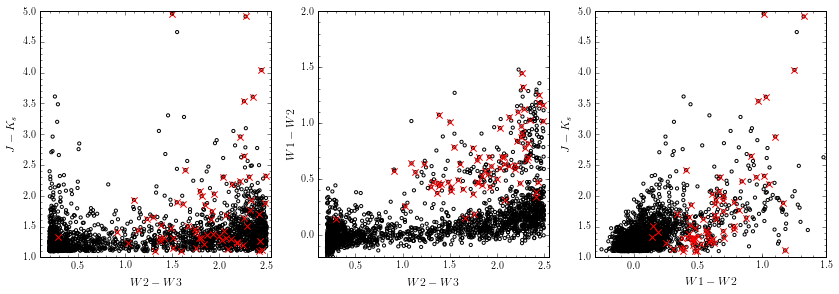

In [63]:
adjust={"left": 0.09, "right":0.87, "top":0.97, "bottom":0.21, "hspace":0.35, "wspace":0.2}
fig = plt.figure(figsize=(14, 4.5))
fig.subplots_adjust(left=adjust["left"], right=adjust["right"], top=adjust["top"], bottom=adjust["bottom"], hspace=adjust["hspace"], wspace=adjust["wspace"])

df1 = agb_cuts(photo_cuts(taurus_field))
df2 = agb_cuts(photo_cuts(ysos_taurus))

x_size = 40

ax = fig.add_subplot(131)
xbounds = [0.1, 2.55]
ybounds = [1.0, 5]
xlim = [xbounds[0], xbounds[1]]
ylim = [ybounds[0], ybounds[1]]

ax.scatter(df1.col23, df1.coljk, s=10, c="None", edgecolor="k", marker="o")
ax.scatter(df2.col23, df2.coljk, s=x_size, c="r", marker="x")

ax.set_xlabel("$W2-W3$")
ax.set_xlim(xlim[0], xlim[1])
ax.set_ylabel("$J-K_s$")
ax.set_ylim(ylim[0], ylim[1])
ax.minorticks_on()

ax = fig.add_subplot(132)
xbounds = [0.1, 2.55]
ybounds = [-0.2, 2]
xlim = [xbounds[0], xbounds[1]]
ylim = [ybounds[0], ybounds[1]]

ax.scatter(df1.col23, df1.col12, s=10, c="None", edgecolor="k", marker="o")
ax.scatter(df2.col23, df2.col12, s=x_size, c="r", marker="x")


ax.set_xlabel("$W2-W3$")
ax.set_xlim(xlim[0], xlim[1])
ax.set_ylabel("$W1-W2$")
ax.set_ylim(ylim[0], ylim[1])
ax.minorticks_on()

ax = fig.add_subplot(133)
xbounds = [-0.3, 1.5]
ybounds = [1.0, 5]
xlim = [xbounds[0], xbounds[1]]
ylim = [ybounds[0], ybounds[1]]

ax.scatter(df1.col12, df1.coljk, s=10, c="None", edgecolor="k", marker="o")
ax.scatter(df2.col12, df2.coljk, s=x_size, c="r", marker="x")


ax.set_xlabel("$W1-W2$")
ax.set_xlim(xlim[0], xlim[1])
ax.set_ylabel("$J-K_s$")
ax.set_ylim(ylim[0], ylim[1])
ax.minorticks_on()

plt.savefig("../figures/ysos_taurus_color.pdf")

plt.show()

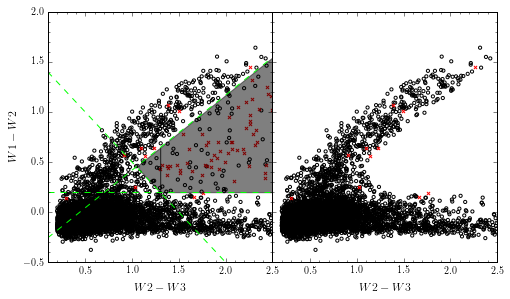

In [64]:
two_cell_comparison(ogle_wise_df, ysos_taurus, "col23", "col12",
                    "$W2-W3$", "$W1-W2$", xlim=[0.1, 2.5], outfile="../figures/remove_ysos.pdf")

In [65]:
print len(agb_cuts(photo_cuts(taurus_field)))

2195


In [66]:
N_ogle = len(photo_cuts(ogle_wise_df))
N_ogle_cut = len(remove_ysos(agb_cuts(photo_cuts(ogle_wise_df))))

N_taurus = len(remove_ysos(agb_cuts(photo_cuts(taurus_field))))
N_ysos = len(remove_ysos(agb_cuts(photo_cuts(ysos_taurus))))

print "OGLE AGBs Completeness w/ YSO cut: %.2f%% (%g)" % ((N_ogle_cut * 1.0/N_ogle * 100), N_ogle_cut)
print "YSO Contamination in Taurus: %.2f%%" % (N_ysos * 1.0/(N_ysos + N_taurus)*100)

OGLE AGBs Completeness w/ YSO cut: 82.34% (6961)
YSO Contamination in Taurus: 0.63%


## Test for RGB stars in JKW1-3 Space
[Return to Top](#The-Full-Production-Notebook)

In [67]:
print len(remove_ysos(agb_cuts(rgbs_df)))

603


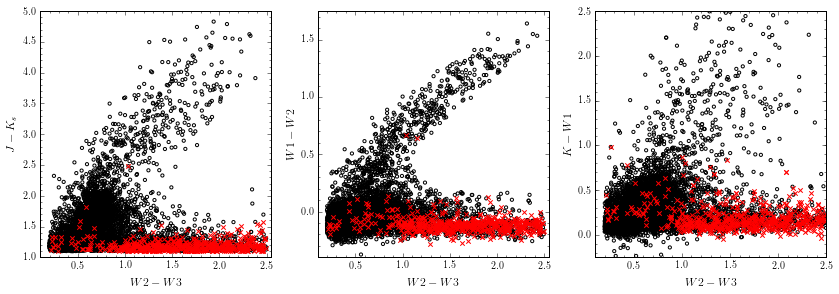

In [68]:
adjust={"left": 0.09, "right":0.87, "top":0.97, "bottom":0.21, "hspace":0.35, "wspace":0.2}
fig = plt.figure(figsize=(14, 4.5))
fig.subplots_adjust(left=adjust["left"], right=adjust["right"], top=adjust["top"], bottom=adjust["bottom"], hspace=adjust["hspace"], wspace=adjust["wspace"])

df1 = remove_ysos(agb_cuts(photo_cuts(ogle_wise_df)))#standardize(ogle_wise_df)
df2 = remove_ysos(agb_cuts(photo_cuts(rgbs_df)))#standardize(rgbs_df)

x_size = 20

ax = fig.add_subplot(131)
xbounds = [0.1, 2.55]
ybounds = [1.0, 5]
xlim = [xbounds[0], xbounds[1]]
ylim = [ybounds[0], ybounds[1]]

ax.scatter(df1.col23, df1.coljk, s=10, c="None", edgecolor="k", marker="o")
ax.scatter(df2.col23, df2.coljk, s=x_size, c="r", marker="x")

ax.set_xlabel("$W2-W3$")
ax.set_xlim(xlim[0], xlim[1])
ax.set_ylabel("$J-K_s$")
ax.set_ylim(ylim[0], ylim[1])
ax.minorticks_on()

ax = fig.add_subplot(132)
xbounds = [0.1, 2.55]
ybounds = [-0.4, 1.75]
xlim = [xbounds[0], xbounds[1]]
ylim = [ybounds[0], ybounds[1]]

ax.scatter(df1.col23, df1.col12, s=10, c="None", edgecolor="k", marker="o")
ax.scatter(df2.col23, df2.col12, s=x_size, c="r", marker="x")


ax.set_xlabel("$W2-W3$")
ax.set_xlim(xlim[0], xlim[1])
ax.set_ylabel("$W1-W2$")
ax.set_ylim(ylim[0], ylim[1])
ax.minorticks_on()

ax = fig.add_subplot(133)
xbounds = [-0.3, 1.5]
ybounds = [1.0, 5]
xlim = [xbounds[0], xbounds[1]]
ylim = [ybounds[0], ybounds[1]]

ax.scatter(df1.col23, df1.colk1, s=10, c="None", edgecolor="k", marker="o")
ax.scatter(df2.col23, df2.colk1, s=x_size, c="r", marker="x")


ax.set_xlim(0.1, 2.5)
ax.set_xlabel("$W2-W3$")
ax.set_ylim(-0.25, 2.5)
ax.set_ylabel("$K-W1$")
ax.minorticks_on()

plt.savefig("../figures/agbs_rgbs_color.pdf")

plt.show()

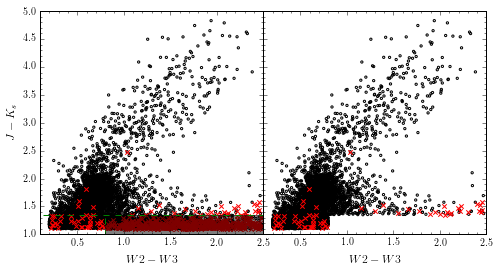

In [69]:
vert = 0.9
xtest = np.linspace(-0.5, 5, 100)
x_size = 20

df1 = remove_ysos(agb_cuts(photo_cuts(ogle_wise_df)))#standardize(ogle_wise_df)
df2 = remove_ysos(agb_cuts(photo_cuts(rgbs_df)))#standardize(rgbs_df)

fig = plt.figure(figsize=(8, 4))
fig.subplots_adjust(wspace=0)
ax = plt.subplot(121)
ax.scatter(df1.col23, df1.coljk, s=5, marker="o", c='None', edgecolor="k")
ax.scatter(df2.col23, df2.coljk, s=x_size, marker='x', c='r')

ax.plot([0,3], [1.35, 1.35], color='g', linestyle="--")
ax.plot([0.8, 0.8], [0, 1.35], color="g", linestyle="--")
ax.fill_between([0.8, 3], [0,0], [1.35, 1.35],
                color='k', alpha=0.5)

ax.set_xlim(0.1, 2.5)
ax.set_xlabel("$W2-W3$")
ax.set_ylim(1.0, 5)
ax.set_ylabel("$J-K_s$")
ax.minorticks_on()

ax = plt.subplot(122)
ax.scatter(remove_rgbs(df1).col23, remove_rgbs(df1).coljk, s=5, marker="o", c='None', edgecolor="k")
ax.scatter(remove_rgbs(df2).col23, remove_rgbs(df2).coljk, s=x_size, marker='x', c='r')

ax.set_xlim(0.1, 2.5)
ax.set_xlabel("$W2-W3$")
ax.set_yticklabels([])
ax.set_ylim(1.0, 5)
# ax.set_ylabel("$K-W1$")
ax.minorticks_on()

plt.savefig("../figures/remove_rgbs.pdf")
plt.show()

In [70]:
N_ogle = len(remove_ysos(agb_cuts(photo_cuts(ogle_wise_df))))
N_rgbs = len(remove_ysos(agb_cuts(photo_cuts(rgbs_df))))

print "OGLE AGBs retained w/out RGB cut (%%) %.2f (%g)" % (N_ogle * 1.0 / len(photo_cuts(ogle_wise_df)) * 100, N_ogle)
print "RGB contamination (%%) %.2f (%g)" % (N_rgbs * 1.0 / (N_rgbs + N_ogle) * 100, N_rgbs)

OGLE AGBs retained w/out RGB cut (%) 82.34 (6961)
RGB contamination (%) 7.97 (603)


In [71]:
# N_ogle = len(standardize(df1, rgbs=True))
# N_rgbs = len(standardize(df2, rgbs=True))
N_ogle = len(remove_rgbs(remove_ysos(agb_cuts(photo_cuts(ogle_wise_df)))))
N_rgbs = len(remove_rgbs(remove_ysos(agb_cuts(photo_cuts(rgbs_df)))))

print "OGLE AGBs retained w/ RGB cut (%%) %.2f (%g)" % (N_ogle * 1.0 / len(photo_cuts(ogle_wise_df)) * 100, N_ogle)
print "RGB contamination (%%) %.2f (%g)" % (N_rgbs * 1.0 / (N_rgbs + N_ogle) * 100, N_rgbs)

OGLE AGBs retained w/ RGB cut (%) 71.14 (6014)
RGB contamination (%) 1.05 (64)


## The Distribution of Galactic AGB candidates
[Return to Top](#The-Full-Production-Notebook)

In [72]:
def count_initial_final_candidates():
    # want to take inventory of candidates before and after the application of the excess removal
    before = 0
    after = 0
    prefix = "../agb_candidates/"
    
    infiles = [prefix + f for f in os.listdir(prefix) if f.startswith("candidates_ra_")]
    for f in infiles:
        df = remove_rgbs(remove_ysos(agb_cuts(photo_cuts(add_colors(pd.read_csv(f))))))
        before += len(df)
        df = remove_excess(df)
        after += len(df)
        
    print "Before: {0} || After: {1}".format(before, after)

In [73]:
count_initial_final_candidates()

Before: 1383366 || After: 306793


/Users/Nick/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:3012: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


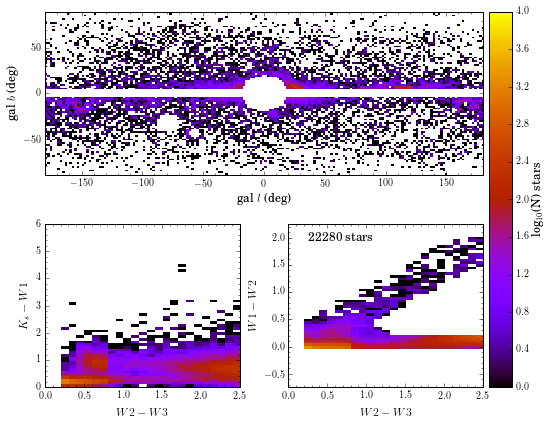

In [74]:
color_and_map_candidates("../agb_candidates/candidates_region_0.dat",
                         xlims_map=[-180, 180], ylims_map=[-90, 90],
                         cmap=plt.cm.gnuplot, figsize=(8,6),
                         vmax=4.0,
                         xlims_color=[[0, 2.5], [0, 2.5]],
                         ylims_color=[[0.0, 6.0], [-0.75, 2.25]],
                        outfile="../figures/color_and_map_candidates_region0.pdf")

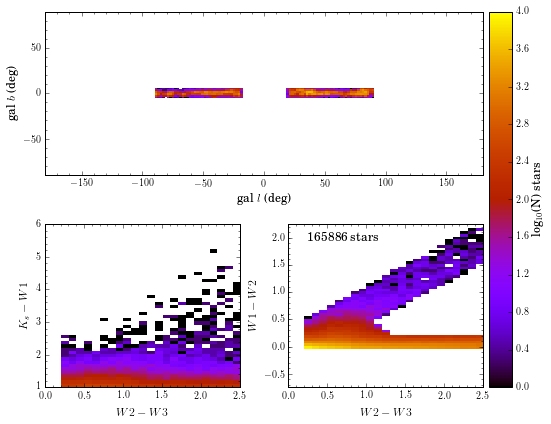

In [75]:
color_and_map_candidates("../agb_candidates/candidates_region_1.dat",
                         xlims_map=[-180, 180], ylims_map=[-90, 90],
                         cmap=plt.cm.gnuplot, figsize=(8,6),
                         vmax=4.0,
                         xlims_color=[[0, 2.5], [0, 2.5]],
                         ylims_color=[[1.0, 6.0], [-0.75, 2.25]],
                        outfile="../figures/color_and_map_candidates_region1.pdf")

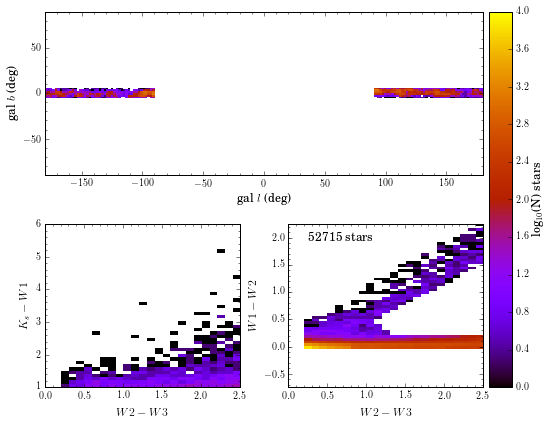

In [76]:
color_and_map_candidates("../agb_candidates/candidates_region_2.dat",
                         xlims_map=[-180, 180], ylims_map=[-90, 90],
                         cmap=plt.cm.gnuplot, figsize=(8,6),
                         vmax=4.0,
                         xlims_color=[[0, 2.5], [0, 2.5]],
                         ylims_color=[[1.0, 6.0], [-0.75, 2.25]],
                        outfile="../figures/color_and_map_candidates_region2.pdf")

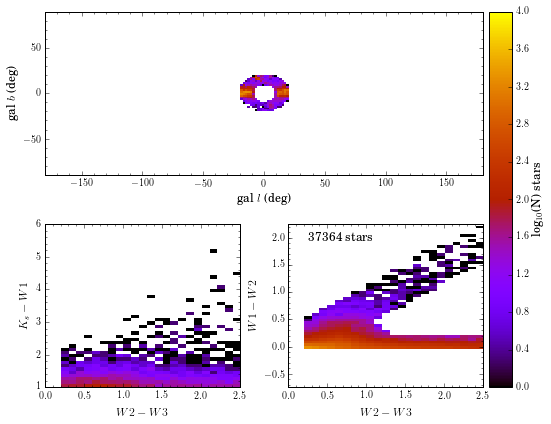

In [77]:
color_and_map_candidates("../agb_candidates/candidates_region_3.dat",
                         xlims_map=[-180, 180], ylims_map=[-90, 90],
                         cmap=plt.cm.gnuplot, figsize=(8,6),
                         vmax=4.0,
                         xlims_color=[[0, 2.5], [0, 2.5]],
                         ylims_color=[[1.0, 6.0], [-0.75, 2.25]],
                        outfile="../figures/color_and_map_candidates_region3.pdf")

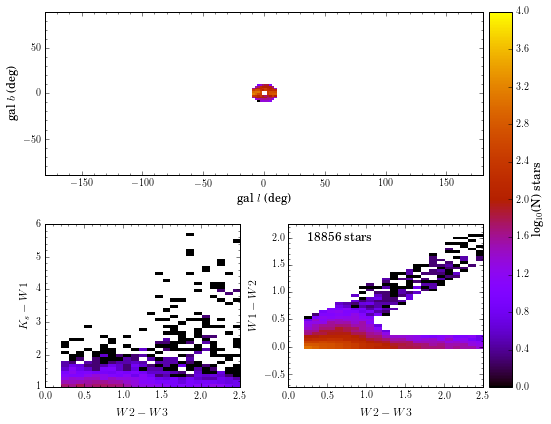

In [78]:
color_and_map_candidates("../agb_candidates/candidates_region_4.dat",
                         xlims_map=[-180, 180], ylims_map=[-90, 90],
                         cmap=plt.cm.gnuplot, figsize=(8,6),
                         vmax=4.0,
                         xlims_color=[[0, 2.5], [0, 2.5]],
                         ylims_color=[[1.0, 6.0], [-0.75, 2.25]],
                        outfile="../figures/color_and_map_candidates_region4.pdf")

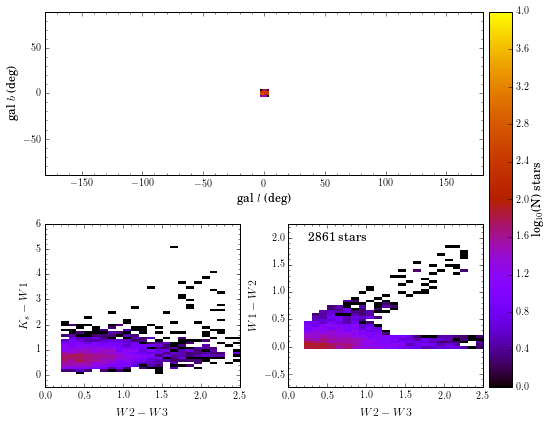

In [79]:
color_and_map_candidates("../agb_candidates/candidates_region_5.dat",
                         xlims_map=[-180, 180], ylims_map=[-90, 90],
                         cmap=plt.cm.gnuplot, figsize=(8,6),
                         vmax=4.0,
                         xlims_color=[[0, 2.5], [0, 2.5]],
                         ylims_color=[[-0.5, 6.0], [-0.75, 2.25]],
                        outfile="../figures/color_and_map_candidates_region5.pdf")

In [80]:
## W1-W2 > -0.2
923523 + 583906 + 78817 + 204875 + 68065 + 4793

1863979

In [81]:
## W1-W2 > -0.1
79291 + 326860 + 76154 + 82106 + 27711 + 3301

595423

In [82]:
## With RGB cuts
print 284160 + 1062423 + 206642 + 493846 + 425935 + 17716
print 101982 + 877454 + 126198 + 334681 + 311780 + 16223

2490722
1768318


In [83]:
## With RGB cuts AND W2-W3 > 0.2
print 69174 + 609225 + 67199 + 229523 + 147599 + 8448

1131168


In [84]:
## With RGB cuts AND W2-W3 > 0.2 AND W1-W2 > -0.04
print 52012 + 162574 + 45302 + 34014 + 17227 + 2828

313957


## Define Boundary Lines for O-rich and C-rich AGB Stars
[Return to Top](#The-Full-Production-Notebook)

In [85]:
clean_agbs = standardize(ogle_wise_df, rgbs=True)

/Users/Nick/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/Nick/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/Nick/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

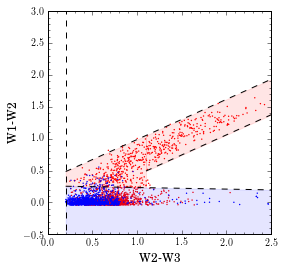

======== O-rich Region: ========
O-rich star count: 972/1074
O-rich completeness (%): 90.5027932961
C-rich contamination (%): 57.1617452622

======== C-rich Region: ========
C-rich star count: 554/1855
C-rich completeness (%): 29.8652291105
O-rich contamination (%): 8.88157894737


In [86]:
x = np.linspace(0.2, 1.1, 100)
x1 = np.linspace(0.2, 2.5, 100)
x2 = np.linspace(1.1, 3, 100)

fig = plt.figure(figsize=(4, 4))
fig.subplots_adjust(wspace=0.3)

slant1 = [-0.025, 0.26]
slant2 = [0.629, 0.359]
slant3 = [0.629, -0.198]

def draw_line(m, x, b):
    return m*np.array(x) + b

ax = plt.subplot(111)
ax.scatter(clean_agbs[clean_agbs.Spectr == "C-rich"].col23, clean_agbs[clean_agbs.Spectr == "C-rich"].col12, s=2, edgecolor="None", c='r')
ax.scatter(clean_agbs[clean_agbs.Spectr == "O-rich"].col23, clean_agbs[clean_agbs.Spectr == "O-rich"].col12, s=2, edgecolor="None", c='b')
ax.plot([0.2, 0.2], [-1, 4], linestyle="--", color='k')
ax.plot([2.5, 2.5], [-1, 0.2], linestyle="--", color='k')

ax.plot([0.2, 2.5], draw_line(slant1[0], np.array([0.2, 2.5]),
                              slant1[1]), color='k', linestyle="--")
ax.plot(x1, draw_line(0.629, x1, 0.359), color='k', linestyle="--")
ax.plot(x2, draw_line(0.629, x2, -0.198), color='k', linestyle="--")

ax.fill_between(x, draw_line(slant1[0], x, slant1[1]),
                draw_line(slant2[0], x, slant2[1]), color='r', alpha=0.1)
ax.fill_between([0.2, 2.5], [-1, -1],
                draw_line(slant1[0], np.array([0.2, 2.5]), slant1[1]),
                color='b', alpha=0.1)
ax.fill_between(x2, draw_line(slant3[0], x2, slant3[1]),
                draw_line(slant2[0], x2, slant2[1]), color='r', alpha=0.1)

ax.minorticks_on()
ax.set_xlim(0,2.5)
ax.set_ylim(-0.5, 3)
ax.set_ylabel("W1-W2")
ax.set_xlabel("W2-W3")

plt.show()

print "======== O-rich Region: ========"
orich = (clean_agbs.col23 > 0.2) & (clean_agbs.col23 < 0.8) & (clean_agbs.col12 < slant1[0]*clean_agbs.col23 + slant1[1]) & (clean_agbs.Spectr == "O-rich")
crich_contam = (clean_agbs.col23 > 0.2) & (clean_agbs.col12 < slant1[0]*clean_agbs.col23 + slant1[1]) & (clean_agbs.Spectr == "C-rich")
print "O-rich star count: {0}/{1}".format(sum(orich), sum(clean_agbs.Spectr=="O-rich"))
print "O-rich completeness (%): {0}".format(sum(orich) / float(sum(clean_agbs.Spectr == "O-rich")) * 100)
print "C-rich contamination (%): {0}".format(sum(crich_contam) / float(sum(crich_contam) + sum(orich)) * 100)

print "\n======== C-rich Region: ========"
crich = (clean_agbs.col12 < slant2[0]*clean_agbs.col23 + slant2[1]) & (clean_agbs.col12 > slant1[0]*clean_agbs.col23 + slant1[1]) & (clean_agbs.Spectr == "C-rich")
orich_contam = (clean_agbs.col12 < slant2[0]*clean_agbs.col23 + slant2[1]) & (clean_agbs.col12 > slant1[0]*clean_agbs.col23 + slant1[1]) & (clean_agbs.Spectr == "O-rich")
print "C-rich star count: {0}/{1}".format(sum(crich), sum(clean_agbs.Spectr=="C-rich"))
print "C-rich completeness (%): {0}".format(sum(crich) / float(sum(clean_agbs.Spectr == "C-rich")) * 100)
print "O-rich contamination (%): {0}".format(sum(orich_contam) / float(sum(crich) + sum(orich_contam)) * 100)



In [87]:
clean_agbs.columns

Index([u'Unnamed: 0', u'# ID', u'Field', u'StarID', u'RA', u'Decl', u'Type',
       u'Evol', u'Spectr', u'I',
       ...
       u'colk1', u'colk2', u'colk3', u'colk4', u'col12', u'col13', u'col14',
       u'col23', u'col24', u'col34'],
      dtype='object', length=102)

In [88]:
# Test a classifier
# from sklearn.svm import SVC
# from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score
from sklearn.cross_validation import train_test_split

# modify data so that O-rich = 1, C-rich = 0
clean_agbs["numerical_class"] = 0
clean_agbs.numerical_class[clean_agbs.Spectr=="O-rich"] = 1
features = clean_agbs[["colk1","colk3","col12","col13","col23"]]
labels = clean_agbs.numerical_class
features_train, features_test, labels_train, labels_test = train_test_split(features, 
                                                                            labels, random_state=4,
                                                                           test_size = 0.5)

# clf = SVC(C=1.0, kernel="linear")
# clf = DecisionTreeClassifier()
neighbors = range(1, 100)
accuracies = []
for n in neighbors:
    clf = KNeighborsClassifier(n_neighbors = n)

    #fit classifier on data
    clf.fit(features_train, labels_train)
    pred = clf.predict(features_test)
    accuracies.append((n, accuracy_score(labels_test, pred)))
    
accuracies = np.array(accuracies).T

/Users/Nick/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


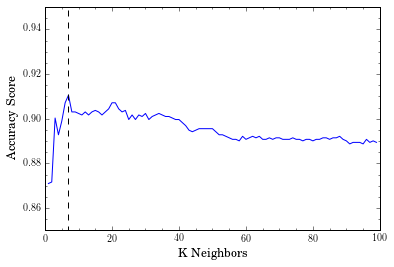

In [89]:
plt.plot(accuracies[0], accuracies[1])
spot = np.argmax(accuracies[1])
plt.plot([accuracies[0][spot], accuracies[0][spot]], [0, 1.0], linestyle="--", color='k')
plt.minorticks_on()
plt.ylim(0.85, 0.950)
plt.xlabel("K Neighbors")
plt.ylabel("Accuracy Score")
plt.show()

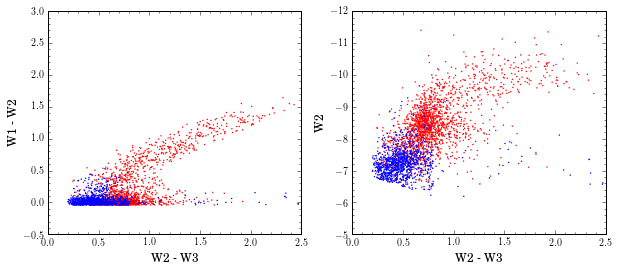

In [90]:
clf = KNeighborsClassifier(n_neighbors=int(accuracies[0, spot]))
clf.fit(features_train, labels_train)
pred = clf.predict(features)
DM_lmc = 18.32

fig = plt.figure(figsize=(10,4))
ax = plt.subplot(121)
ax.scatter(features.col23[pred == 0], features.col12[pred == 0], s=2, edgecolor="None", c='r')
ax.scatter(features.col23[pred == 1], features.col12[pred == 1], s=2, edgecolor="None", c='b')
ax.minorticks_on()
ax.set_xlim(0,2.5)
ax.set_ylim(-0.5, 3)
ax.set_ylabel("W1 - W2")
ax.set_xlabel("W2 - W3")

ax = plt.subplot(122)
ax.scatter(clean_agbs.col23[pred == 0], clean_agbs.w2[pred == 0] - DM_lmc, s=2, edgecolor="None", c='r')
ax.scatter(clean_agbs.col23[pred == 1], clean_agbs.w2[pred == 1] - DM_lmc, s=2, edgecolor="None", c='b')
ax.minorticks_on()
ax.set_xlim(0, 2.5)
ax.invert_yaxis()
ax.set_ylabel("W2")
ax.set_xlabel("W2 - W3")

plt.show()

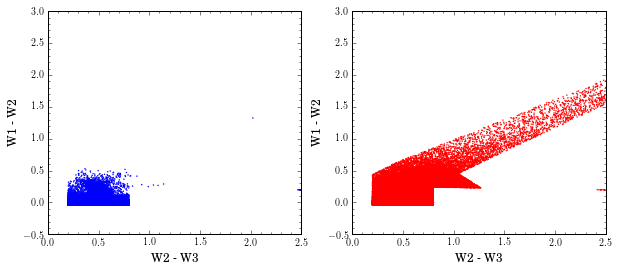

In [91]:
# test how KNeighbors works on label-less data
file_dir = "../agb_candidates/"
unlabeled = pd.read_csv(file_dir + "candidates_absmag_all.dat")
pred = clf.predict(unlabeled[["colk1","colk3","col12","col13","col23"]])

fig = plt.figure(figsize=(10,4))
ax = plt.subplot(121)
ax.scatter(unlabeled.col23[pred == 1.], unlabeled.col12[pred == 1.], s=2, edgecolor="None", c='b')
ax.minorticks_on()
ax.set_xlim(0, 2.5)
ax.set_ylim(-0.5, 3)
ax.set_ylabel("W1 - W2")
ax.set_xlabel("W2 - W3")

ax = plt.subplot(122)
ax.scatter(unlabeled.col23[pred == 0.], unlabeled.col12[pred == 0.], s=2, edgecolor="None", c='r')
ax.minorticks_on()
ax.set_xlim(0, 2.5)
ax.set_ylim(-0.5, 3)
ax.set_ylabel("W1 - W2")
ax.set_xlabel("W2 - W3")

plt.show()

In [92]:
print sum(pred), len(pred)
## This ratio is improper. The misclassification is exacerbated by the C-rich agb stars existing within W1-W2 < 0.5 

41486 159083


## Linear Regression to Estimate Absolute Magnitudes
[Return to Top](#The-Full-Production-Notebook)

In [93]:
from sklearn.linear_model import LinearRegression

In [94]:
clean_agbs["Mw1"] = clean_agbs.w1 - DM_lmc
clean_agbs["Mw2"] = clean_agbs.w2 - DM_lmc
clean_agbs["Mw3"] = clean_agbs.w3 - DM_lmc

In [95]:
fit_cols = [
            ['col12', 'col23'],
            ['coljk', 'colk1', 'col12', 'col23']            
           ]
features1 = clean_agbs[fit_cols[0]][orich]
features2 = clean_agbs[fit_cols[1]][crich]

values1 = clean_agbs.Mw2[orich]
values2 = clean_agbs.Mw2[crich]

model_1 = LinearRegression()
model_1.fit(features1, values1)

model_2 = LinearRegression()
model_2.fit(features2, values2)

predicted_o = model_1.predict(features1)
predicted_c = model_2.predict(features2)

coeffs1 = model_1.coef_
coeffs2 = model_2.coef_

Mw1_01 = model_1.intercept_
Mw1_02 = model_2.intercept_

resid_o = clean_agbs.Mw2[orich] - predicted_o
resid_c = clean_agbs.Mw2[crich] - predicted_c

# M_o = np.matrix([np.ones(sum(orich)), clean_agbs[orich].coljk, clean_agbs[orich].colk1,
#                  clean_agbs[orich].col12, clean_agbs[orich].col23])
# M_c = np.matrix([np.ones(sum(crich)), clean_agbs[crich].coljk, clean_agbs[crich].colk1,
#                  clean_agbs[crich].col12, clean_agbs[crich].col23])
# C_o = np.matrix(np.identity(sum(orich)) * np.array(clean_agbs[orich].w1err**2))
# C_c = np.matrix(np.identity(sum(crich)) * np.array(clean_agbs[crich].w1err**2))
# Y_o = np.matrix(clean_agbs[orich].Mw1)
# Y_c = np.matrix(clean_agbs[crich].Mw1)

# left_o = np.dot(np.dot(M_o, C_o.I), M_o.T).I
# left_c = np.dot(np.dot(M_c, C_c.I), M_c.T).I
# right_o = np.dot(np.dot(M_o, C_o.I), Y_o.T)
# right_c = np.dot(np.dot(M_c, C_c.I), Y_c.T)

# params_o = np.dot(left_o, right_o)
# params_c = np.dot(left_c, right_c)

# predicted_o = params_o[0,0] + params_o[1,0]*clean_agbs[orich].coljk + params_o[2,0]*clean_agbs[orich].colk1 + params_o[3,0]*clean_agbs[orich].col12 + params_o[4,0]*clean_agbs[orich].col23
# predicted_c = params_c[0,0] + params_c[1,0]*clean_agbs[crich].coljk + params_c[2,0]*clean_agbs[crich].colk1 + params_c[3,0]*clean_agbs[crich].col12 + params_c[4,0]*clean_agbs[crich].col23
# resid_o = clean_agbs.Mw1[orich] - predicted_o
# resid_c = clean_agbs.Mw1[crich] - predicted_c

print "C-rich fit interquartile-width: %.2f mag"%(np.percentile(resid_c, 75)-np.percentile(resid_c, 25))
print "C-rich fit stdev: %.2f mag\n"%(np.std(resid_c))
print "O-rich fit interquartile-width: %.2f mag"%(np.percentile(resid_o, 75)-np.percentile(resid_o, 25))
print "O-rich fit stdev: %.2f mag"%(np.std(resid_o))

r_squared_o = sum(resid_o**2) / sum((clean_agbs.Mw2[orich] - np.mean(clean_agbs.Mw2[orich]))**2)
r_squared_c = sum(resid_c**2) / sum((clean_agbs.Mw2[crich] - np.mean(clean_agbs.Mw2[crich]))**2)
print "\nR^2 for O-rich Fit: %.2f" % r_squared_o
print "R^2 for C-rich Fit: %.2f" % r_squared_c


C-rich fit interquartile-width: 0.58 mag
C-rich fit stdev: 0.46 mag

O-rich fit interquartile-width: 0.42 mag
O-rich fit stdev: 0.36 mag

R^2 for O-rich Fit: 0.95
R^2 for C-rich Fit: 0.39


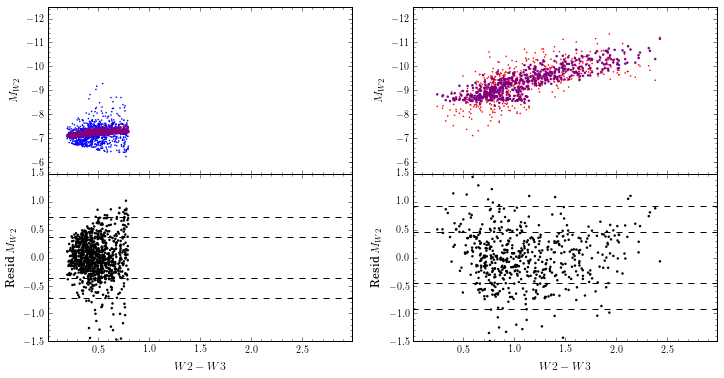

In [96]:
xtest = np.linspace(clean_agbs.col12.min(), clean_agbs.col12.max(), 11)
fig = plt.figure(figsize=(12, 6))
fig.subplots_adjust(hspace=0)

ax = plt.subplot(221)
ax.scatter(clean_agbs.col23[orich], clean_agbs.Mw2[orich], c='b', edgecolor="None", s=2.5)
# ax.scatter(clean_agbs.col23[orich], predicted1, c='purple', edgecolor="None", marker=".", s=25)
ax.scatter(clean_agbs.col23[orich], predicted_o, c='purple', edgecolor="None", marker=".", s=25)
ax.minorticks_on()
ax.set_xlim(0.01, 2.99)
ax.set_xlabel("$W2-W3$")
ax.set_ylim(-5.5, -12.5)
ax.set_ylabel("$M_{W2}$")

ax = plt.subplot(223)
sig_o = np.std(resid_o)
ax.scatter(clean_agbs.col23[orich], resid_o, c='k', edgecolor="None", marker=".", s=25)
ax.plot([0, 3.0], [sig_o, sig_o], linestyle="--", color='k')
ax.plot([0, 3.0], [2*sig_o, 2*sig_o], linestyle="--", color='k')
ax.plot([0, 3.0], [-sig_o, -sig_o], linestyle="--", color='k')
ax.plot([0, 3.0], [-2*sig_o, -2*sig_o], linestyle="--", color='k')
ax.minorticks_on()
ax.set_xlim(0.01, 2.99)
ax.set_xlabel("$W2-W3$")
ax.set_ylim(-1.5, 1.5)
ax.set_ylabel("Resid $M_{W2}$")

ax = plt.subplot(222)
ax.scatter(clean_agbs.col23[crich], clean_agbs.Mw2[crich], c='r', edgecolor="None", s=2.5)
# ax.scatter(clean_agbs.col23[crich], predicted2, c='purple', edgecolor="None", marker=".", s=25)
ax.scatter(clean_agbs.col23[crich], predicted_c, c='purple', edgecolor="None", marker=".", s=25)
ax.minorticks_on()
ax.set_xlim(0.01, 2.99)
ax.set_xlabel("$W2-W3$")
ax.set_ylim(-5.5, -12.5)
ax.set_ylabel("$M_{W2}$")

ax = plt.subplot(224)
sig_c = np.std(resid_c)
ax.scatter(clean_agbs.col23[crich], resid_c, c='k', edgecolor="None", marker=".", s=25)
ax.plot([0, 3.0], [sig_c, sig_c], linestyle="--", color='k')
ax.plot([0, 3.0], [2*sig_c, 2*sig_c], linestyle="--", color='k')
ax.plot([0, 3.0], [-sig_c, -sig_c], linestyle="--", color='k')
ax.plot([0, 3.0], [-2*sig_c, -2*sig_c], linestyle="--", color='k')
ax.minorticks_on()
ax.set_xlim(0.01, 2.99)
ax.set_xlabel("$W2-W3$")
ax.set_ylim(-1.5, 1.5)
ax.set_ylabel("Resid $M_{W2}$")

plt.show()

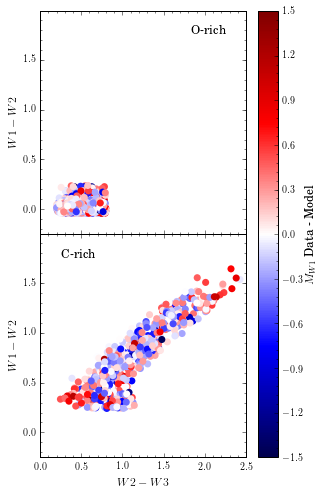

In [97]:
# residuals between model and data

x = np.linspace(0.4,3,100)
x1 = np.linspace(0.4,0.7,100)
x2 = np.linspace(0.7,3,100)
vmin = -1.5
vmax = 1.5

fig = plt.figure(figsize=(4,8))
fig.subplots_adjust(hspace=0, right=0.84)

ax = plt.subplot(211)
imap = ax.scatter(clean_agbs[orich].col23, clean_agbs[orich].col12, edgecolor="None", s=50,c=resid_o, vmin=vmin, vmax=vmax, cmap='seismic')
ax.text(0.9, 0.9, "O-rich", transform=ax.transAxes, horizontalalignment="right")

ax.set_ylabel("$W1-W2$")
ax.set_xlim(0, 2.5)
ax.set_ylim(-0.25, 1.99)
ax.minorticks_on()
ax.set_xticklabels([])

ax = plt.subplot(212)
ax.scatter(clean_agbs[crich].col23, clean_agbs[crich].col12, edgecolor="None", s=50,c=resid_c, vmin=vmin, vmax=vmax, cmap='seismic')
ax.text(0.1, 0.9, "C-rich", transform=ax.transAxes, horizontalalignment="left")

ax.minorticks_on()
ax.set_xlabel("$W2-W3$")
ax.set_ylabel("$W1-W2$")
ax.set_xlim(0, 2.5)
ax.set_ylim(-0.25, 1.99)

cax = fig.add_axes([0.88, 0.125, 0.07, 0.775]) 
cbar = plt.colorbar(imap, cax = cax, ticks=np.linspace(vmin, vmax, 11))
cbar.ax.set_ylabel("$M_{W1}$ Data - Model", fontsize=12)
cbar.ax.minorticks_on()

plt.show()

In [98]:
outstr = "Our params...\n"
outstr += "======== O-rich Stars: ========\n"
# outstr += "\t(J-K): %.2f\n" % coeffs1[0]
# outstr += "\t(K-W1): %.2f\n" % coeffs1[1]
outstr += "\t(W1-W2): %.2f\n" % coeffs1[0]
outstr += "\t(W2-W3): %.2f\n" % coeffs1[1]
# outstr += "\tW1err: %.2f\n" % coeffs1[1]
# outstr += "\tW2err: %.2f\n" % coeffs1[5]
# outstr += "\tW3err: %.2f\n" % coeffs1[6]
outstr += "\tintercept: %.2f\n\n" % Mw1_01
outstr += "======== C-rich Stars: ========\n"
outstr += "\t(J-K): %.2f\n" % coeffs2[0]
outstr += "\t(K-W1): %.2f\n" % coeffs2[1]
outstr += "\t(W1-W2): %.2f\n" % coeffs2[2]
outstr += "\t(W2-W3): %.2f\n" % coeffs2[3]
# outstr += "\tW1err: %.2f\n" % coeffs2[4]
# outstr += "\tW2err: %.2f\n" % coeffs2[5]
# outstr += "\tW3err: %.2f\n" % coeffs2[6]
outstr += "\tintercept: %.2f\n" % Mw1_02

print outstr

# outstr = "Our params...\n"
# outstr += "======== O-rich Stars: ========\n"
# outstr += "\t(J-K): %.2f\n" % params_o[1,0]
# outstr += "\t(K-W1): %.2f\n" % params_o[2,0]
# outstr += "\t(W1-W2): %.2f\n" % params_o[3,0]
# outstr += "\t(W2-W3): %.2f\n" % params_o[4,0]
# outstr += "\tintercept: %.2f\n\n" % params_o[0,0]
# outstr += "======== C-rich Stars: ========\n"
# outstr += "\t(J-K): %.2f\n" % params_c[1,0]
# outstr += "\t(K-W1): %.2f\n" % params_c[2,0]
# outstr += "\t(W1-W2): %.2f\n" % params_c[3,0]
# outstr += "\t(W2-W3): %.2f\n" % params_c[4,0]
# outstr += "\tintercept: %.2f\n" % params_c[0,0]

# print outstr

Our params...
======== O-rich Stars: ========
	(W1-W2): -1.04
	(W2-W3): -0.35
	intercept: -7.00

======== C-rich Stars: ========
	(J-K): -0.16
	(K-W1): -0.25
	(W1-W2): -1.00
	(W2-W3): 0.05
	intercept: -7.91



## Calculate and Save Absolute Magnitudes
[Return to Top](#The-Full-Production-Notebook)

In [99]:
def calc_absolute_and_save(infile, outfile, model_o, model_c, cols, head=True):
    df = standardize(pd.read_csv(infile, sep=","), rgbs=True)
    
    # divide into O and C-rich populations
    slant1 = [-0.025, 0.26]
    slant2 = [0.629, 0.359]
    slant3 = [0.629, -0.198]

    orich = df[(df.col23 > 0.2) & (df.col23 < 0.8) & (df.col12 < slant1[0]*df.col23 + slant1[1])]
    crich = df[(df.col12 < slant2[0]*df.col23 + slant2[1]) & (df.col12 > slant1[0]*df.col23 + slant1[1])]

    ## calculate absolute magnitude for w1
#     print df[orich]
    feats_o = orich[cols[0]]
    feats_c = crich[cols[1]]
    
    orich["Mw1"] = model_o.predict(feats_o)
    orich["chem"] = "O-rich"

    crich["Mw1"] = model_c.predict(feats_c)
    crich["chem"] = "C-rich"
    
#     orich["Mw1"] = orich.coljk*theta_o['coljk'] + orich.colk1*theta_o['colk1'] + orich.col12*theta_o['col12'] + orich.col23*theta_o['col23'] + theta_o["intercept"]
#     crich["Mw1"] = crich.coljk*theta_c['coljk'] + crich.colk1*theta_c['colk1'] + crich.col12*theta_c['col12'] + crich.col23*theta_c['col23'] + theta_c["intercept"]    
    
    out_df = pd.concat((orich, crich))
    out_df.to_csv(outfile, sep=",", index=False, header=head)

In [100]:
file_dir = "../agb_candidates/"

for ii in range(6):
    in_name = file_dir + "candidates_region_{0}.dat".format(ii)
    out_name = file_dir + "candidates_absmag_region_{0}.dat".format(ii)
    
    if ii == 0:
        calc_absolute_and_save(in_name, out_name, model_1, model_2, cols=fit_cols)
    else:
        calc_absolute_and_save(in_name, out_name, model_1, model_2, cols=fit_cols, head=False)

/Users/Nick/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Nick/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Nick/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/in

In [101]:
file_dir = "../agb_candidates/"
a = pd.read_csv(file_dir + "candidates_absmag_all.dat")

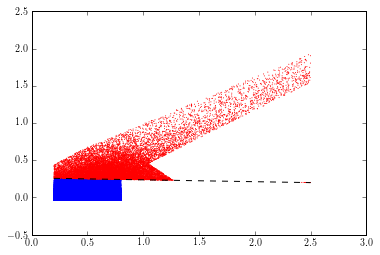

In [102]:
# slant1 = [-0.025, 0.26]

ax = plt.subplot(111)
ax.scatter(a.col23[a.chem=="O-rich"], a.col12[a.chem=="O-rich"], s=1, edgecolor="None", c='b')
ax.scatter(a.col23[a.chem=="C-rich"], a.col12[a.chem=="C-rich"], s=1, edgecolor="None", c='r')
# H, xed, yed = np.histogram2d(a.col23, a.col12, bins=(np.arange(0, 3.0, 0.05), np.arange(-0.5, 2.5, 0.05)))
# extent=[xed[0], xed[-1], yed[0], yed[-1]]
# ax.imshow(np.log10(H.T), origin="lower", interpolation="nearest", aspect="auto", extent=extent, cmap=plt.cm.gnuplot2)
ax.plot([0.2, 2.5], draw_line(slant1[0], np.array([0.2, 2.5]),
                              slant1[1]), color='k', linestyle="--")

plt.show()

Write it all up. Choose figures. Then calculate distances

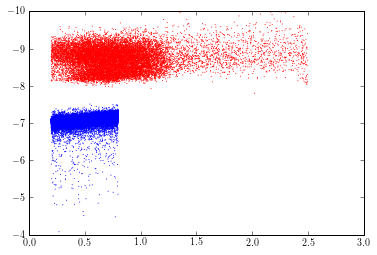

In [103]:
ax = plt.subplot(111)
ax.scatter(a.col23[a.chem=="O-rich"], a.Mw1[a.chem=="O-rich"], s=1, edgecolor="None", c='b')
ax.scatter(a.col23[a.chem=="C-rich"], a.Mw1[a.chem=="C-rich"], s=1, edgecolor="None", c='r')
ax.invert_yaxis()
ax.set_ylim(-4,-10)
plt.show()

In [104]:
print sum(a.chem == "O-rich")
print sum(a.chem == "C-rich")

143373
15710


Try running a version with the other, completely arbitrary fit including w1, w2, and w3err.

## The Results of the Dust Extinction Calculation
[Return to Top](#The-Full-Production-Notebook)

In [105]:
infile = "../dust_extinction/candidate_outs/candidates_extinction_all.dat"
candidates = pd.read_csv(infile, sep=",")

In [106]:
def add_distances(df):
    extinction_coeffs = {"Av":3.1, "Ar":2.751,
                         "Aj": 0.34, "Ah": 0.21, "Ak": 0.15,
                         "Aw1": 0.11, "Aw2": 0.09, "Aw3": 0.13}
    df["DM"] = df.w1 - df.Mw1 - extinction_coeffs["Aw1"] * extinction_coeffs["Ar"] * df.ebvs  
    df["dist"] = 10**((df.DM + 5.)/5.)/1E3
    
    dbulge = 8.0 #kpc
    conv = np.pi/180.
    df["X"] = dbulge - df.dist * np.cos(df.glon * conv) * np.cos(df.glat * conv)
    df["Y"] = -df.dist * np.sin(df.glon * conv) * np.cos(df.glat * conv)
    df["Z"] = df.dist * np.sin(df.glat * conv)
    df["R"] = np.sqrt(df.X**2 + df.Y**2)
    return df

In [107]:
candidates = add_distances(candidates)

In [193]:
def plot_xy(df, dbulge=8.0, title=None, scatter=False, outfile=None, contours=False,
            y_guides=True, circles=[5., 10., 15., 20.], **ellipse_kwargs):
    the_sun = {"X": dbulge, "Y": 0, "Z": 0, "R": dbulge}
    fig = plt.figure(figsize=(6, 6))
    fig.subplots_adjust(wspace=0, hspace=0, right = 0.84)
    if title:
        plt.suptitle(title)
    
    if scatter == False:
        dh = 1.25
        xbins = np.arange(-200, 200+dh, dh)
        ybins = np.arange(-200, 200+dh, dh)
        zbins = np.arange(-200, 200+dh, dh)
        H, xed, yed = np.histogram2d(df.X, df.Y, bins=(xbins, ybins))
        extent = [xed[0], xed[-1], yed[0], yed[-1]]
    
    ax = plt.subplot(111)
    if scatter:
        ax.scatter(df.X, df.Y, s=1, edgecolor="None", c='k')
        
    else:
        imap = ax.imshow(np.log10(H.T), extent=extent, aspect="auto", interpolation="nearest",
                  origin="lower", cmap=plt.cm.cubehelix_r, vmax=3.5)
    
    # marking x=0 and y=0
    ax.plot([0, 0], [-30, 30], linestyle=":", color="gray", alpha=0.5)
    ax.plot([-30, 30], [0, 0], linestyle=":", color="gray", alpha=0.5)
    
    
    if y_guides:
        ax.plot([-30, 30],[5, 5], linestyle="--", color='k')
        ax.plot([-30, 30],[-5, -5], linestyle="--", color='k')
            
    for radius in circles:
        add_ellipse(ax, [0, 0], radius, radius, **ellipse_kwargs)
        
    ax.text(0.05, 0.95, "N stars: %g" % len(df), 
            transform=ax.transAxes, horizontalalignment="left",
           verticalalignment="top")
    
    ax.set_xlim(-30, 30)
    ax.set_ylim(-30, 30)
    ax.set_xlabel("X (kpc)")
    ax.set_ylabel("Y (kpc)")
    ax.minorticks_on()

    if scatter == False:
        cax = fig.add_axes([0.86, 0.1, 0.04, 0.87]) 
        cbar = plt.colorbar(imap, cax = cax)
        cbar.ax.set_ylabel("log$_{10}$ N stars", fontsize=12)
        cbar.ax.minorticks_on()

    if outfile:
        plt.savefig(outfile)
    plt.show()
    

In [194]:
def plot_xyz(df, dbulge=8.0, title=None, scatter=False, outfile=None, contours=False,
            x_restrict=None, y_restrict=None, z_restrict=None,
            circles=[10., 20., 30.], **ellipse_kwargs):
    the_sun = {"X": dbulge, "Y": 0, "Z": 0, "R": dbulge}

    fig = plt.figure(figsize=(8, 8))
    fig.subplots_adjust(wspace=0, hspace=0, right = 0.84)
    if title:
        plt.suptitle(title)
    
    if scatter == False:
        dh = 1.25
        xbins = np.arange(-200, 200+dh, dh)
        ybins = np.arange(-200, 200+dh, dh)
        zbins = np.arange(-200, 200+dh, dh)
    
    ax = plt.subplot(221)
    if scatter:
        ax.scatter(df.X, df.Z, s=1, edgecolor="None", c='k')
        
    else:
        H, xed, yed = np.histogram2d(df.X, df.Z, bins=(xbins, ybins))
        extent = [xed[0], xed[-1], yed[0], yed[-1]]

        ax.imshow(np.log10(H.T), extent=extent, aspect="auto", interpolation="nearest",
                  origin="lower", cmap=plt.cm.cubehelix_r, vmax=3.5)
    
    ax.text(0.05, 0.95, "N stars: %g" % len(df), 
            transform=ax.transAxes, horizontalalignment="left",
           verticalalignment="top")

    if z_restrict:
        ax.plot([-30, 30],[z_restrict, z_restrict], linestyle="--", color='k')
        ax.plot([-30, 30],[-z_restrict, -z_restrict], linestyle="--", color='k')
        
    ax.set_xlim(-30, 30)
    ax.set_ylim(-30, 30)
    ax.set_xlabel("X (kpc)")
    ax.set_ylabel("Z (kpc)")
    ax.minorticks_on()

    ax = plt.subplot(224)
    if scatter:
        ax.scatter(df.Z, df.Y, s=1, edgecolor="None", c='k')
        
    else:
        H, xed, yed = np.histogram2d(df.Z, df.Y, bins=(xbins, ybins))
        extent = [xed[0], xed[-1], yed[0], yed[-1]]

        ax.imshow(np.log10(H.T), extent=extent, aspect="auto", interpolation="nearest",
                  origin="lower", cmap=plt.cm.cubehelix_r, vmax=3.5)
    
    if z_restrict:
        ax.plot([z_restrict, z_restrict], [-30, 30],linestyle="--", color='k')
        ax.plot([-z_restrict, -z_restrict], [-30, 30], linestyle="--", color='k')

    ax.set_xlim(-30, 30)
    ax.set_ylim(-30, 30)
    ax.set_xlabel("Z (kpc)")
    ax.set_ylabel("Y (kpc)")
    ax.minorticks_on()
    
    ax = plt.subplot(223)
    if scatter:
        ax.scatter(df.X, df.Y, s=1, edgecolor="None", c='k')
        
    else:
        H, xed, yed = np.histogram2d(df.X, df.Y, bins=(xbins, ybins))
        extent = [xed[0], xed[-1], yed[0], yed[-1]]

        imap = ax.imshow(np.log10(H.T), extent=extent, aspect="auto", interpolation="nearest",
                  origin="lower", cmap=plt.cm.cubehelix_r, vmax=3.5)
    
    if y_restrict:
        ax.plot([-30, 30],[y_restrict, y_restrict], linestyle="--", color='k')
        ax.plot([-30, 30],[-y_restrict, -y_restrict], linestyle="--", color='k')
    
    for radius in circles:
        add_ellipse(ax, [0., 0.], radius, radius,
                   **ellipse_kwargs)
    ax.set_xlim(-30, 30)
    ax.set_ylim(-30, 30)
    ax.set_xlabel("X (kpc)")
    ax.set_ylabel("Y (kpc)")
    ax.minorticks_on()

    if scatter == False:
        cax = fig.add_axes([0.86, 0.1, 0.04, 0.87]) 
        cbar = plt.colorbar(imap, cax = cax)
        cbar.ax.set_ylabel("log$_{10}$ N stars", fontsize=12)
        cbar.ax.minorticks_on()

    if outfile:
        plt.savefig(outfile)
    plt.show()


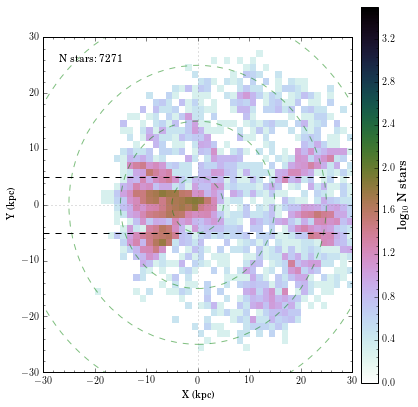

In [195]:
# plot_xy(candidates[candidates.chem == "O-rich"])
plot_xy(candidates[candidates.chem == "O-rich"][abs(candidates.Z) > 2],
        circles=[5., 15., 25., 35.],
        **{"edgecolor":"g", "fill":False, "linestyle":"--", "alpha":0.5})


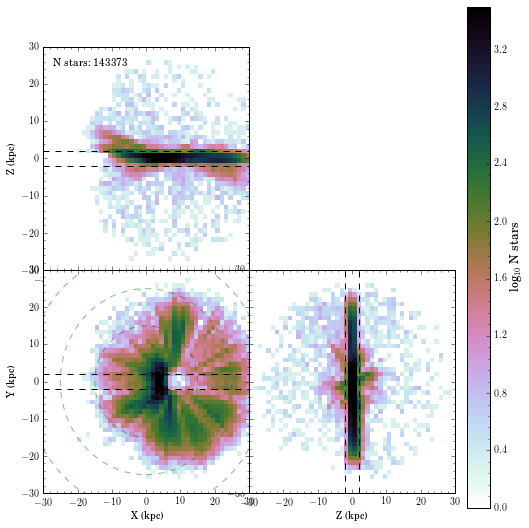

In [196]:
plot_xyz(candidates[candidates.chem == "O-rich"], 
         z_restrict = 2, y_restrict = 2, 
         outfile="../figures/orich_candidates_galactic.pdf",
        circles=[5., 15., 25., 35.],
        **{"edgecolor":"g", "fill":False, "linestyle":"--", "alpha":0.5})

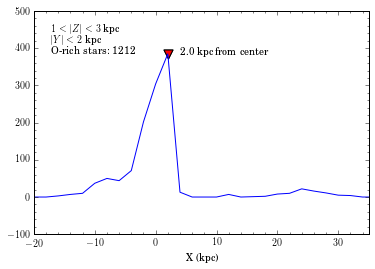

In [188]:
vec = candidates[candidates.chem == "O-rich"][(abs(candidates.Z) < 3) & 
                                              (abs(candidates.Z > 1)) &
                                              (abs(candidates.Y) < 2)].X

H, edges = np.histogram(vec, bins=np.linspace(-100, 100, 101))
ax = plt.subplot(111)
ax.plot(edges[:-1], H)
spot = np.argmax(H)
ax.scatter([edges[spot], edges[spot]], [H[spot], H[spot]], s=80, c='r', marker="v")
ax.text(edges[spot] + 2, H[spot], 
        "%.1f kpc from center" % edges[spot], 
        horizontalalignment="left")
ax.text(0.05, 0.95, "$1<|Z|<3$ kpc\n$|Y|<2$ kpc\nO-rich stars: %g" % sum(H), transform=ax.transAxes,
       horizontalalignment="left", verticalalignment="top")
ax.set_xlim(-20, 35)
ax.set_xlabel("X (kpc)")
ax.minorticks_on()
# plt.savefig("../figures/")
plt.show()

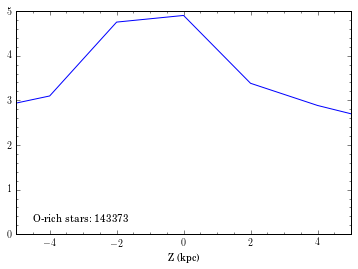

In [197]:
vec = candidates[candidates.chem == "O-rich"].Z

H, edges = np.histogram(vec, bins=np.linspace(-100, 100, 101))
ax = plt.subplot(111)
ax.plot(edges[:-1], np.log10(H))
ax.set_xlim(-5, 5)
ax.set_xlabel("Z (kpc)")
ax.text(0.05, 0.05, "O-rich stars: %g" % sum(H), transform=ax.transAxes,
       horizontalalignment="left", verticalalignment="bottom")
ax.minorticks_on()
plt.show()

In [114]:
sum(abs(candidates[candidates.chem == "O-rich"].Y) < 3)

52383

## Plot out Z histograms binned in R and vice versa
[Return to Top](#The-Full-Production-Notebook)

In [115]:
orich_agbs = candidates[candidates.chem == "O-rich"]

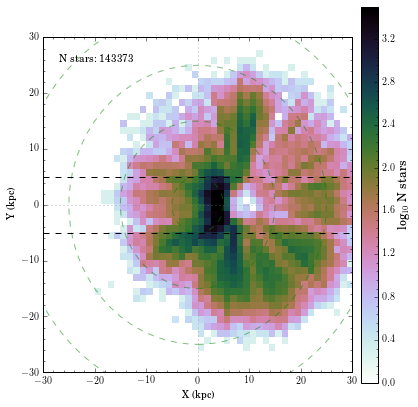

In [198]:
## The planned selections
savedir = "../figures/"
plot_xy(candidates[candidates.chem == "O-rich"], 
        outfile="../figures/orich_candidates_galactic_xy.pdf",
        circles=[5., 15., 25., 35.],
        **{"edgecolor":"g", "fill":False, "linestyle":"--", "alpha":0.5})

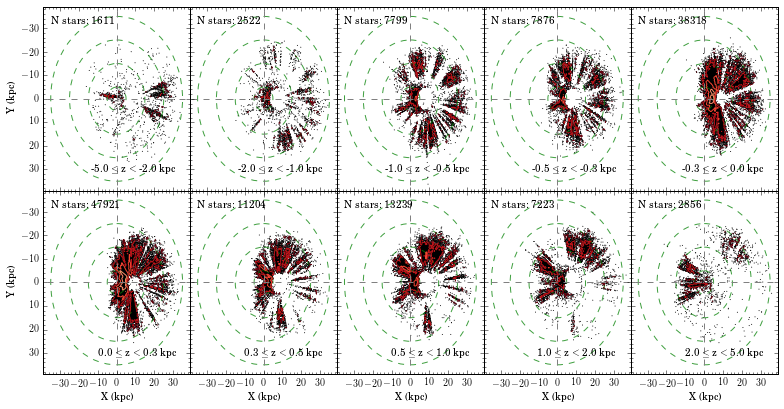

In [200]:
#pieces of Z:
# 0->0.3, 0.3->0.5, 0.5->1.0, 1.0->2.0, 2.0->5.0
dlev = 0.75
levs = np.arange(0,3.5+dlev,dlev)
zarray = [-5.0,-2.0,-1.0,-0.5,-0.3,0.0,0.3,0.5,1.0,2.0,5.0]
dh = 401
xbins = np.linspace(-100, 100, dh)
ybins = np.linspace(-100, 100, dh)

fig = plt.figure(figsize=(12,6))
fig.subplots_adjust(hspace=0, wspace=0, top=0.95, left=0.05, right=0.9, bottom=0.1)
circles = [5., 15., 25., 35.]

for ii in range(len(zarray)-1):
    zhi = zarray[ii+1]
    zlo = zarray[ii]
    select = (orich_agbs.Z < zhi) & (orich_agbs.Z >= zlo)
    
    ax = plt.subplot(2,5,ii+1)
    H, xedges, yedges = np.histogram2d(orich_agbs.X[select], orich_agbs.Y[select],
                                       bins=(xbins,ybins))
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    ## sample
    ax.scatter(orich_agbs.X[select], orich_agbs.Y[select],
               s=1, edgecolor='None', c='k')
    
    ## plot circles
    for radius in circles:
        add_ellipse(ax, [0, 0], radius, radius,
                   **{"edgecolor":"g", "fill":False, 
                      "linestyle":"--", "alpha":0.75})
        
    ## contours
    im = ax.contour(np.log10(H.T), extent=extent, cmap=plt.cm.Reds_r, levels=levs)
    
    ## crosshairs on (0,0)
    ax.plot([-1E5,1E5],[0,0],linestyle='--', color='grey'); plt.plot([0,0],[-1E5,1E5],linestyle='--', color='grey')
    ax.text(0.9,0.1,'%.1f $\le$ z $<$ %.1f kpc' % (zlo, zhi), horizontalalignment='right', transform=ax.transAxes)    
    ax.text(0.05, 0.95, "N stars: %g" % sum(select), transform=ax.transAxes, 
            horizontalalignment="left", verticalalignment="top")
    
    ax.set_xlim(-39,39)
    ## Flip the Y-axis
    ax.set_ylim(39,-39)
    if ii > 4:
        ax.set_xlabel('X (kpc)')
    if ii in [0,5]:
        ax.set_ylabel('Y (kpc)')
    else:
        ax.yaxis.set_major_formatter(NullFormatter())
    ax.minorticks_on()

plt.savefig(savedir+'orich_candidates_zslices.pdf')
    
plt.show()

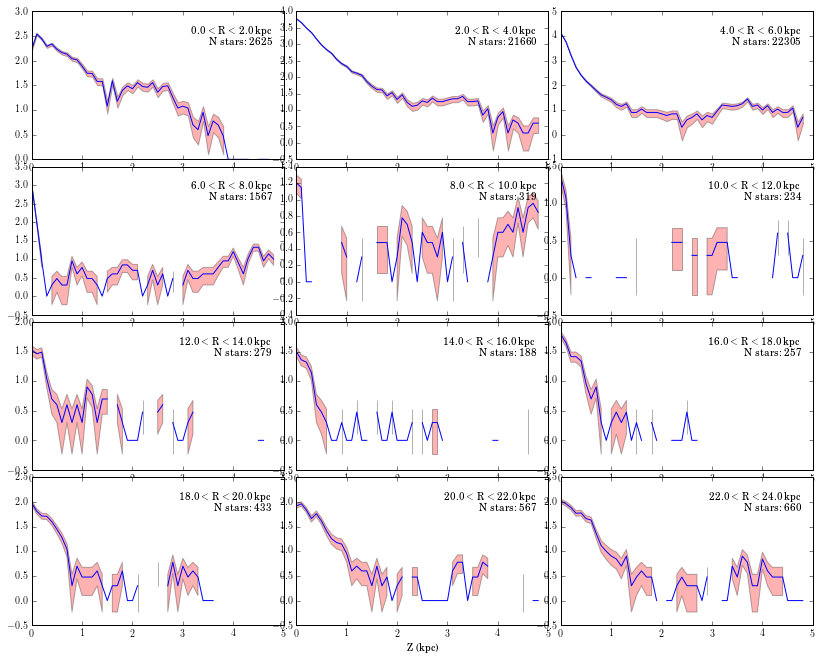

In [201]:
indx = 0
dr = 2.0
radii = np.arange(0, 24 + dr, dr)
z_bins = np.arange(0, 5, 0.1)

fig = plt.figure(figsize = (14, 11))
fig.subplots_adjust(hspace=0.05, wspace=0.05)
for rad in radii[:-1]:
    indx += 1
    #note y < 3 as that creates somewhat consistent area slices of rings
    restrict = (orich_agbs.R > rad) & (orich_agbs.R < rad + dr) & (abs(orich_agbs.Y) < 3) & orich_agbs.X > 0
    H, edges = np.histogram(abs(orich_agbs[restrict].Z), bins=z_bins)
    unc = np.sqrt(H)
    
    ax = plt.subplot(4, 3, indx)
    ax.plot(edges[:-1], np.log10(H), color="b")
    ax.fill_between(edges[:-1], np.log10(H - unc), np.log10(H + unc), facecolor="red",
                   alpha=0.3)
    
    ax.set_xlim(0, 5)
    ax.text(0.95, 0.9, "%.1f $<$ R $<$ %.1f kpc\nN stars: %g" % (rad, rad + dr, sum(restrict)),
            horizontalalignment="right", verticalalignment="top",
            transform = ax.transAxes)
    if indx == 11:
        ax.set_xlabel("Z (kpc)")
    
    
plt.show()

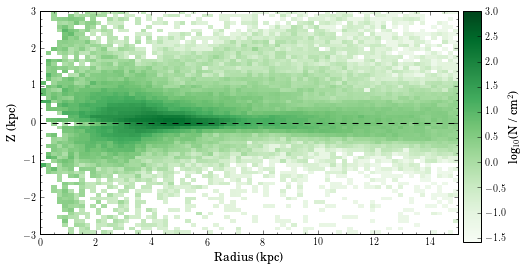

In [119]:
dr = 0.2 # steps of 0.1 kpc or 100 pc in galactocentric radius
dz = 0.1 # steps of 0.05 kpc or 50 pc in height
vmax = 3.0

radbins = np.arange(0, 30 + dr, dr)
zbins = np.arange(-20, 20 + dz, dz)

H, xedges, yedges = np.histogram2d(orich_agbs.R, orich_agbs.Z, bins=(radbins, zbins))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

#want number density, not just number
areas = np.pi * (radbins[1:]**2 - radbins[:-1]**2)
H = np.array([H[ii] / areas[ii] for ii in range(len(areas))])

fig = plt.figure(figsize=(8, 4))
fig.subplots_adjust(hspace=0, right=0.85)
ax = plt.subplot(111)
im = ax.imshow(np.log10(H.T), extent=extent, origin='lower',
               aspect='auto',interpolation='nearest', cmap=plt.cm.Greens, vmax=vmax)
ax.minorticks_on()

ax.plot([0, 15], [0, 0], color='k', linestyle='--')
ax.set_xlabel('Radius (kpc)')
ax.set_ylabel('Z (kpc)')
ax.set_xlim(0, 15)
ax.set_ylim(-3, 3)

cax = fig.add_axes([0.86, 0.1, 0.03, 0.8])
cbar = fig.colorbar(im, cax=cax)
cbar.ax.set_ylabel('log$_{10}$(N / cm$^2$)')
ax.minorticks_on()

plt.savefig(savedir + "orich_candidates_galactic_rz.pdf")
plt.show()

## Calculate the Scale Heights of given R bins
[Return to Top](#The-Full-Production-Notebook)

In [120]:
def func(x, a, b):
    return a * np.exp(-x / b)

def func_double(x, a, b, c, d):
#     return a*np.exp(-x/b) + (c/a)*np.exp(-x/d)
    return a*np.exp(-x/b) + np.exp(-x/d)

def linear_func(x,a,b):
    ## Takes the linear coefficients 
    ## from the fit below and puts them 
    ## into an exponential function
    return np.exp(a*x + b)

def scale_height(zvals, zcut=0.5):
    zvals = abs(zvals)
    
    ## Declare the z value to cut at, then declare two different populations of sources
    zabove = zvals > zcut
    zbelow = zvals <= zcut
    
    ## Histogram for objects above 0.5 kpc from the plane
    zbins = np.linspace(0.5, 3.0, 11)
    H1, ed1 = np.histogram(zvals[zabove], bins=zbins)
    dx1 = (ed1[1] - ed1[0]) / 2.
    mask = np.where(H1 != 0)
    
    if zcut == 0.5:
        the_first_fit = np.polyfit(ed1[:-1][mask] + dx1, np.log(H1[mask] / 4.), deg=1)
        
    else:
        the_first_fit = np.polyfit(ed1[:-1][mask] + dx1, np.log(H1[mask]), deg=1)

    
    ## Histogram for objects below 0.5 kpc from the plane
    zbins = np.linspace(0,0.5,6)
    H2, ed2 = np.histogram(zvals[zbelow], bins=zbins) 
    dx2 = (ed2[1] - ed2[0]) / 2.
    mask = np.where(H2 != 0)
    
    if zcut == 0.5:
        the_second_fit = np.polyfit(ed2[:-1][mask] + dx2, np.log(H2[mask] / 2.), deg=1)
        
    else:
        the_second_fit = np.polyfit(ed2[:-1][mask] + dx2, np.log(H2[mask]), deg=1)
    
    coeffs = [the_first_fit[0], the_first_fit[1], the_second_fit[0], the_second_fit[1]]
    
    ## Note, the coefficients returned are NOT scale height and normalization
    ## The coefficients are related, but aren't directly those values.
    ## scale heights are -1/coeffs[0] and -1/coeffs[2]
    ## normalizations are np.exp(coeffs[1]) and np.exp(coeffs[3])
    return coeffs

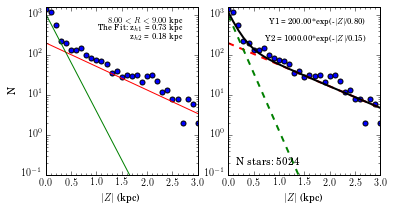

In [202]:
## Calculate vertical exponential fit for each radius bin and plot it up
## Can't do uniform bins for this sample because the sample size is just too small.
## Need to do separate fits for Z < 0.5 and Z > 0.5
dr = 1
radbins = np.arange(0, 30 + dr, dr)

## testing on one radius bin. This should be 8 < R < 9 kpc
ii = 8
radius_bin = (orich_agbs.R > radbins[ii]) & (orich_agbs.R < radbins[ii + 1])

## select stars of interest in radius bin
zvals = orich_agbs.Z[radius_bin]
rvals = orich_agbs.R[radius_bin]

## we're histogramming in Z, so chop up by dz
dz = 0.1
zbins = np.arange(0, 5 + dz, dz)
H, ed = np.histogram(abs(zvals), bins=zbins)

## if we're outside the 9 kpc radius, fit a double exponential
## profile broken at z = 1 kpc instead of 0.5 kpc
if ii >= 9:
    coeffs = scale_height(zvals, zcut=1.0)
    
else:
    coeffs = scale_height(zvals)
    
fig = plt.figure(figsize=(6, 3))
ax = plt.subplot(121)
ax.scatter(zbins[:-1], H, marker='o', s=25)
ax.plot(zbins[:-1], linear_func(zbins[:-1], coeffs[0], coeffs[1]), color='r')
ax.plot(zbins[:-1], linear_func(zbins[:-1], coeffs[2], coeffs[3]), color='g')

ax.text(0.9, 0.8,
        '$%.2f < R < %.2f$ kpc\nThe Fit: z$_{h1}$ = %.2f kpc\nz$_{h2}$ = %.2f kpc' % (radbins[ii], radbins[ii + 1], abs(1 / coeffs[0]), abs(1 / coeffs[2])), 
        transform=ax.transAxes, horizontalalignment='right', fontsize=8)

ax.set_xlim(0, 3)
ax.set_ylim(1.0E-1)
ax.set_yscale('log')
ax.set_xlabel('$|Z|$ (kpc)')
ax.set_ylabel('N')
ax.minorticks_on()

eyeheight = [0.8, 0.15]
eyenorm = [200, 1000]
eyefunc1 = eyenorm[0] * np.exp(-(zbins[:-1]) / eyeheight[0])
eyefunc2 = eyenorm[1] * np.exp(-(zbins[:-1]) / eyeheight[1])
eyefunc = eyefunc1 + eyefunc2

ax = plt.subplot(122)
ax.scatter(zbins[:-1], H, marker='o', s=25)
ax.plot(zbins[:-1], eyefunc1, color='r', linestyle='--', linewidth=2) ## 300 pc scale height...
ax.plot(zbins[:-1], eyefunc2, color='g', linestyle='--', linewidth=2)
ax.plot(zbins[:-1], eyefunc, color='k', linewidth=2)
ax.text(0.9, 0.9, 'Y1 = %.2f*exp(-$|Z|$/%.2f)' % (eyenorm[0], eyeheight[0]), 
        horizontalalignment='right', transform=ax.transAxes, fontsize=8)
ax.text(0.9, 0.8, 'Y2 = %.2f*exp(-$|Z|$/%.2f)' % (eyenorm[1], eyeheight[1]), 
        horizontalalignment='right', transform=ax.transAxes, fontsize=8)
ax.text(0.05, 0.05, "N stars: %g" % (sum(radius_bin)), transform=ax.transAxes,
       horizontalalignment="left", verticalalignment="bottom")
ax.set_xlim(0, 3)
ax.set_ylim(1.0E-1)
ax.set_xlabel('$|Z|$ (kpc)')
ax.set_yscale('log')
ax.minorticks_on()

plt.savefig(savedir+'vertical_fit.pdf')

plt.show()

### Addressing Zeljko Comments

• Make an XY plot for 1 < |Z| < 3kpc

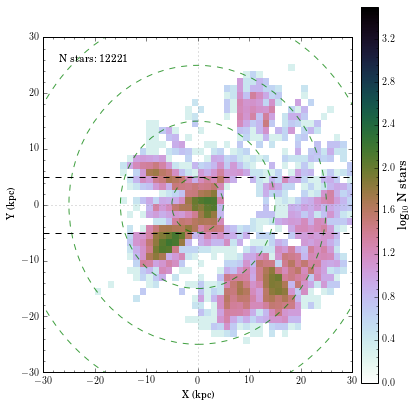

In [203]:
plot_xy(candidates[candidates.chem == "O-rich"][(abs(candidates.Z) > 1) & 
                                                (abs(candidates.Z) < 3)],
       circles=[5., 15., 25., 35.],
       **{"edgecolor":"g", "fill":False, "linestyle":"--", "alpha":0.75})


• Change grid of vertical slices to include 1-3 & 3-5 kpc instead of 1-2 & 2-5 kpc.

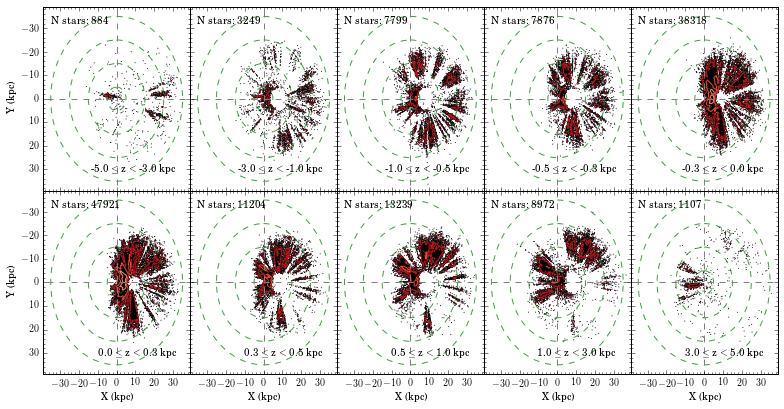

In [204]:
#pieces of Z:
dlev = 0.75
levs = np.arange(0, 3.5+dlev, dlev)
zarray = [-5.0, -3.0, -1.0, -0.5, -0.3, 
          0.0, 0.3, 0.5, 1.0, 3.0, 5.0]
dh = 401
xbins = np.linspace(-100, 100, dh)
ybins = np.linspace(-100, 100, dh)

fig = plt.figure(figsize=(12, 6))
fig.subplots_adjust(hspace=0, wspace=0, top=0.95, left=0.05, right=0.9, bottom=0.1)

circles = [5., 15., 25., 35.]

for ii in range(len(zarray)-1):
    zhi = zarray[ii+1]
    zlo = zarray[ii]
    select = (orich_agbs.Z < zhi) & (orich_agbs.Z >= zlo)
    
    ax = plt.subplot(2, 5, ii+1)
    H, xedges, yedges = np.histogram2d(orich_agbs.X[select], orich_agbs.Y[select],
                                       bins=(xbins,ybins))
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    ## sample
    ax.scatter(orich_agbs.X[select], orich_agbs.Y[select],
               s=1, edgecolor='None', c='k')
    
    ## circles
    for radius in circles:
        add_ellipse(ax, [0, 0], radius, radius,
                   **{"edgecolor":"g", "fill":False, 
                      "linestyle":"--", "alpha":0.75})
    
    ## contours
    im = ax.contour(np.log10(H.T), extent=extent, cmap=plt.cm.Reds_r, levels=levs)
    
    ## crosshairs on (0,0)
    ax.plot([-1E5, 1E5], [0, 0], linestyle='--', color='grey')
    ax.plot([0, 0],[-1E5, 1E5], linestyle='--', color='grey')
    ax.text(0.9, 0.1, '%.1f $\le$ z $<$ %.1f kpc' % (zlo, zhi), 
            horizontalalignment='right', transform=ax.transAxes)
    ax.text(0.05, 0.95, "N stars: %g" % (sum(select)), horizontalalignment="left",
           verticalalignment="top", transform=ax.transAxes)
    
    ax.set_xlim(-39, 39)
    ## Flip the Y-axis
    ax.set_ylim(39, -39)
    if ii > 4:
        ax.set_xlabel('X (kpc)')
    if ii in [0, 5]:
        ax.set_ylabel('Y (kpc)')
    else:
        ax.yaxis.set_major_formatter(NullFormatter())
        
    ax.minorticks_on()

plt.show()

• Make R histograms for different Z cuts

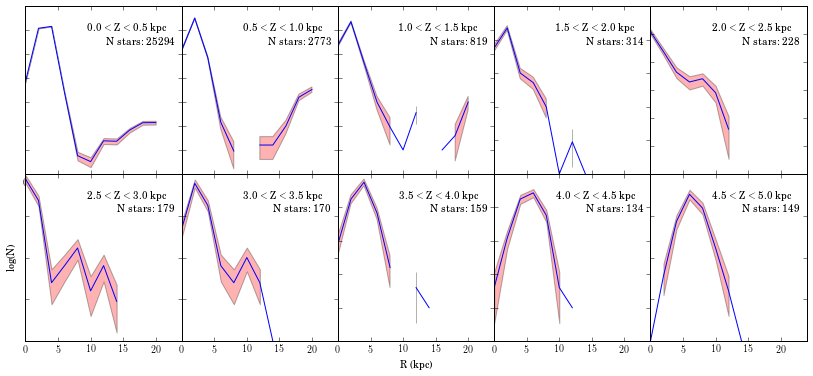

In [206]:
indx = 0
# dr = 2.0
# radii = np.arange(0, 24 + dr, dr)
# z_bins = np.arange(0, 5, 0.1)
dh = 0.5
heights = np.arange(0, 5 + dh, dh)
r_bins = np.arange(0, 24, 2.0)

fig = plt.figure(figsize = (14, 6))
fig.subplots_adjust(hspace=0.0, wspace=0.0)

for h in heights[:-1]:
    indx += 1
    #note y < 3 as that creates somewhat consistent area slices of rings
    restrict = (orich_agbs.Z > h) & (orich_agbs.Z < h + dh) & (abs(orich_agbs.Y) < 3) & orich_agbs.X > 0
    H, edges = np.histogram(abs(orich_agbs[restrict].R), bins=r_bins)
    unc = np.sqrt(H)
    
    ax = plt.subplot(2, 5, indx)
    ax.plot(edges[:-1], np.log10(H), color="b")
    ax.fill_between(edges[:-1], np.log10(H - unc), np.log10(H + unc), facecolor="red",
                   alpha=0.3)
    
    ax.set_xlim(0, 24)
    ax.text(0.9, 0.9, "%.1f $<$ Z $<$ %.1f kpc" % (h, h + dh),
            horizontalalignment="right", verticalalignment="top",
            transform = ax.transAxes)
    ax.text(0.95, 0.82, "N stars: %g" % (sum(restrict)),
            horizontalalignment="right", verticalalignment="top",
            transform = ax.transAxes)
    
    if indx == 8:
        ax.set_xlabel("R (kpc)")
    ax.yaxis.set_major_formatter(NullFormatter())
    if indx == 6:
        ax.set_ylabel("log(N)")
    
    
plt.show()

In [219]:
## Calculate vertical exponential fit for each radius bin and plot it up
## Can't do uniform bins for this sample because the sample size is just too small.
## Need to do separate fits for Z < 0.5 and Z > 0.5
def plot_vertical_fits(data_df):
    dr = 2.0
    radbins = np.arange(0, 24 + dr, dr)

    fig = plt.figure(figsize=(16, 20))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    for ii in range(len(radbins) - 1):
        # for ii in range(3):
        radbin = (data_df.R > radbins[ii]) & (data_df.R < radbins[ii + 1])

        ## select stars of interest in radius bin
        zvals = data_df.Z[radbin]
        rvals = data_df.R[radbin]

        ## we're histogramming in Z, so chop up by dz
        dz = 0.1
        zbins = np.arange(0, 5 + dz, dz)
        H, ed = np.histogram(abs(zvals), bins=zbins)

        ## if we're outside the 9 kpc radius, fit a double exponential
        ## profile broken at z = 1 kpc instead of 0.5 kpc
        if ii >= 9:
            coeffs = scale_height(zvals, zcut=1.0)

        else:
            coeffs = scale_height(zvals)

        line1 = linear_func(zbins[:-1] + dz/2, coeffs[0], coeffs[1])
        line2 = linear_func(zbins[:-1] + dz/2, coeffs[2], coeffs[3])
        total = line1 + line2
        
        ax = plt.subplot(4, 3, ii+1)
        ax.errorbar(zbins[:-1] + dz/2, H, np.sqrt(H), marker='o', linewidth=0,
                    elinewidth=1)
        ax.plot(zbins[:-1] + dz/2, line1, color='r')
        ax.plot(zbins[:-1] + dz/2, line2, color='g')
        ax.plot(zbins[:-1] + dz/2, total, color='k', linewidth=2)
        
        std = np.sqrt(1./len(H) * np.sum((H - total)**2.))
       
        fitstr = "$%.2f < R < %.2f$ kpc"
        fitstr += "\nThe Fit:\tz$_{h1}$ = %.2f kpc"
        fitstr += "\n\t\tz$_{h2}$ = %.2f kpc"
        fitstr += "\n\t\t$\sigma$ = %.2f"
        fitstr += "\nN stars: %g"
        
        ax.text(0.07, 0.07,
                fitstr % (radbins[ii], radbins[ii + 1], abs(1 / coeffs[0]), 
                          abs(1 / coeffs[2]), std, sum(radbin)), 
                transform=ax.transAxes, horizontalalignment='left', 
                verticalalignment="bottom", fontsize=14)
     
        ax.set_xlim(0, 3)
        ax.set_ylim(1.0)
        ax.set_yscale('log')
        
        if ii >= 9:
            ax.set_xlabel('$|Z|$ (kpc)')
        
        if ii in [0, 3, 6, 12]:
            ax.set_ylabel('N')
        ax.minorticks_on()

    plt.show()

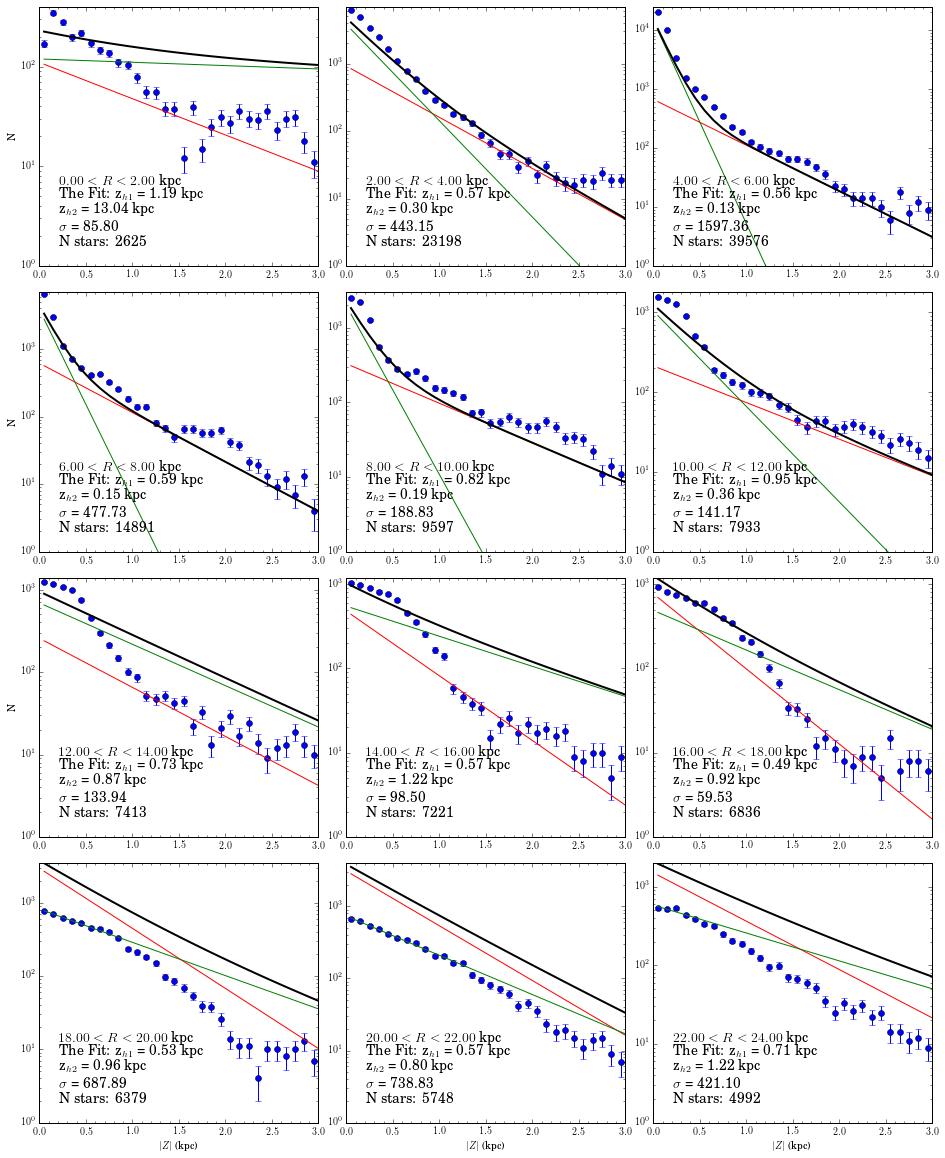

In [220]:
plot_vertical_fits(orich_agbs)

• Check if faint/saturation limits are influencing distance limits

```sat = {"w1":2.0, "w2":1.5, "w3":-3.0, "k":8.5}
fnt = {"w1":16.83, "w2":15.6, "w3":11.32, "k":15.5}```

First, check to see what the limits on the data are, after all the cutting

In [127]:
print orich_agbs[["w1","w2","w3","kmag"]].max()
print orich_agbs[["w1","w2","w3","kmag"]].min()


w1      12.317
w2      12.114
w3      11.319
kmag    14.657
dtype: float64
w1      6.568
w2      6.399
w3      5.734
kmag    8.501
dtype: float64


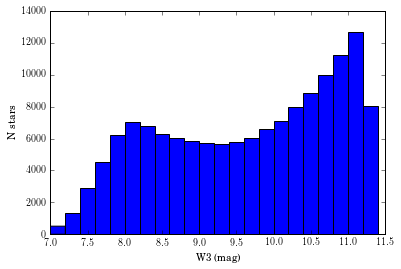

In [209]:
plt.hist(orich_agbs.w3, bins=np.arange(7, 11.6, 0.2))
plt.xlabel("W3 (mag)")
plt.ylabel("N stars")
plt.show()

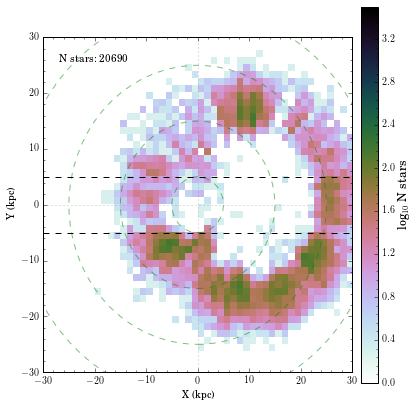

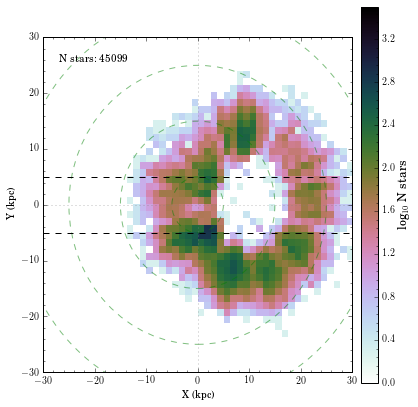

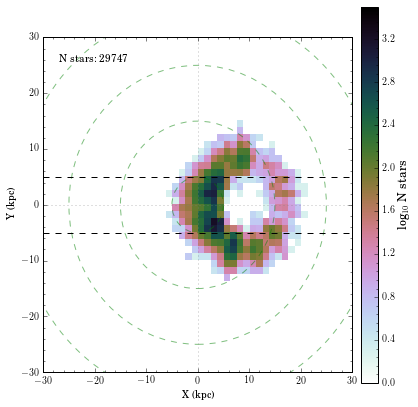

In [210]:
# The closest to being a faint limiter is W3
plot_xy(orich_agbs[orich_agbs.w3 > 11],
       circles=[5., 15., 25., 35.,],
       **{"edgecolor":"g", "fill":False, 
          "linestyle":"--", "alpha":0.5})
plot_xy(orich_agbs[(orich_agbs.w3 < 11) & (orich_agbs.w3 > 10)],
       circles=[5., 15., 25., 35.,],
       **{"edgecolor":"g", "fill":False, 
          "linestyle":"--", "alpha":0.5})
plot_xy(orich_agbs[(orich_agbs.w3 < 10) & (orich_agbs.w3 > 9)],
       circles=[5., 15., 25., 35.,],
       **{"edgecolor":"g", "fill":False, 
          "linestyle":"--", "alpha":0.5})


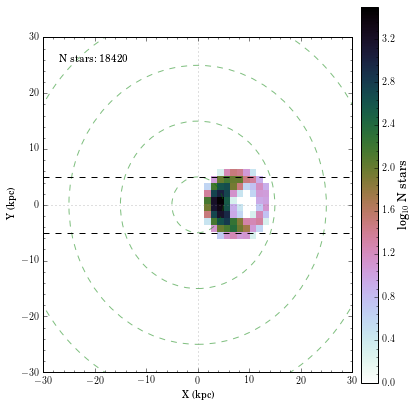

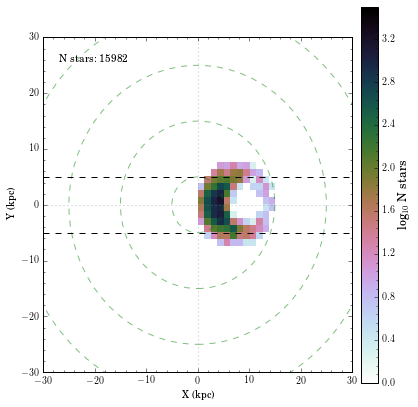

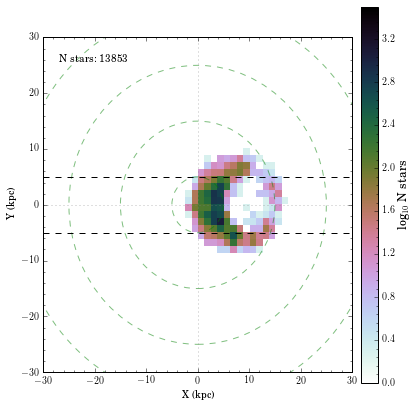

In [211]:
# The closest to being a saturation limiter is k-magnitude actually
plot_xy(orich_agbs[(orich_agbs.kmag < 9) & (orich_agbs.kmag > 8.5)],
       circles=[5., 15., 25., 35.,],
       **{"edgecolor":"g", "fill":False, 
          "linestyle":"--", "alpha":0.5})
plot_xy(orich_agbs[(orich_agbs.kmag < 9.5) & (orich_agbs.kmag > 9)],
       circles=[5., 15., 25., 35.,],
       **{"edgecolor":"g", "fill":False, 
          "linestyle":"--", "alpha":0.5})
plot_xy(orich_agbs[(orich_agbs.kmag < 10) & (orich_agbs.kmag > 9.5)],
       circles=[5., 15., 25., 35.,],
       **{"edgecolor":"g", "fill":False, 
          "linestyle":"--", "alpha":0.5})


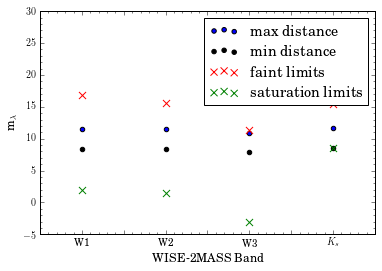

In [131]:
far = orich_agbs.dist.argmax()
near = orich_agbs.dist.argmin()

mags_far = [orich_agbs.w1[far], orich_agbs.w2[far], orich_agbs.w3[far], orich_agbs.kmag[far]]
mags_near = [orich_agbs.w1[near], orich_agbs.w2[near], orich_agbs.w3[near], orich_agbs.kmag[near]]
fnt_lims = [16.83, 15.6, 11.32, 15.5]
sat_lims = [2.0, 1.5, -3.0, 8.5]
fig = plt.figure()
ax = plt.subplot(111)
ax.scatter(range(4), mags_far, label="max distance")
ax.scatter(range(4), mags_near, color="k", label="min distance")
ax.scatter(range(4), fnt_lims, marker="x", s=50, color="r", label="faint limits")
ax.scatter(range(4), sat_lims, marker="x", s=50, color="g", label="saturation limits")
ax.minorticks_on()
ax.set_ylabel("m$_\lambda$")
ax.set_ylim(-5, 30)
ax.set_xticklabels(["","W1", "", "W2", "","W3", "","$K_s$"])
ax.set_xlabel("WISE-2MASS Band")
ax.legend(loc="best")

plt.show()

• Check for holes in the map of extinction values for these stars. Show as RA-Dec plots binned in distance

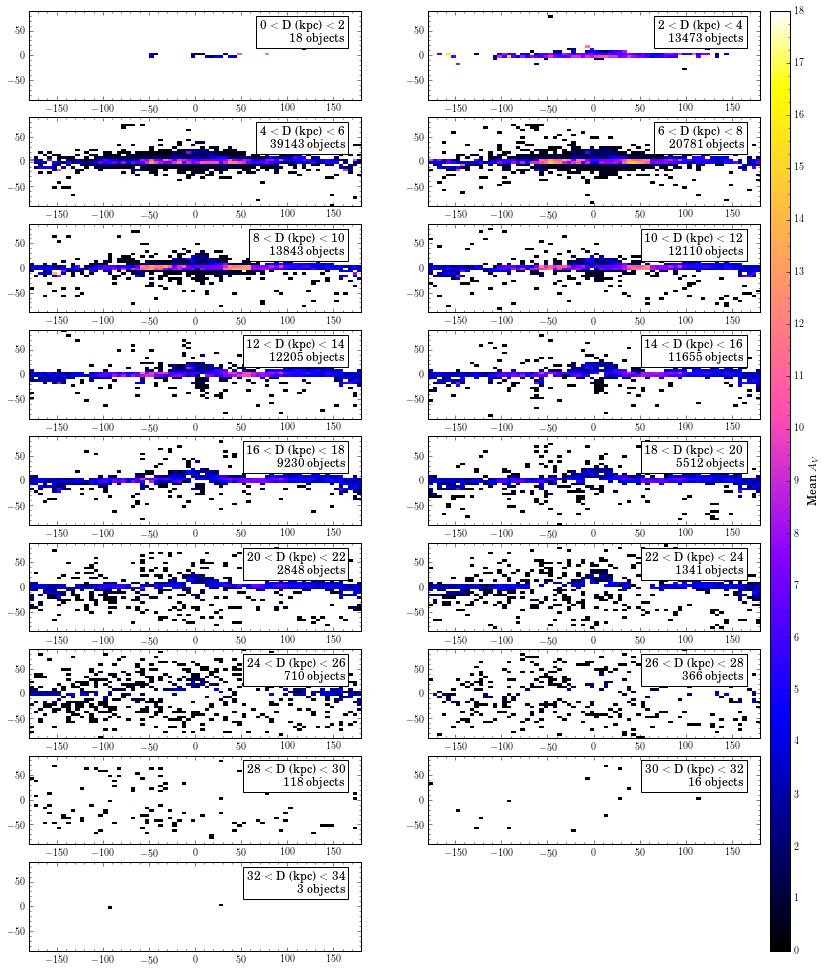

In [132]:
xbins = np.arange(-180, 185, 5.0)
ybins = np.arange(-90, 95, 5.0)
distances = np.arange(0, 36, 2.0)
vmin=0.
vmax=18.

fig = plt.figure(figsize=(14, 15))
fig.subplots_adjust(right=0.85, bottom=0.1, top=0.97)

for ii in range(len(distances)-1):
    the_set = (orich_agbs.dist > distances[ii]) & (orich_agbs.dist < distances[ii+1])
    H, xed, yed, q = binned_statistic_2d(orich_agbs[the_set].glon, orich_agbs[the_set].glat, 
                                         3.1 * orich_agbs[the_set].ebvs, statistic="mean", bins = (xbins, ybins))
    extent = [xed[0], xed[-1], yed[0], yed[-1]]

    ax = plt.subplot(9, 2, ii + 1)
    imap = ax.imshow(H.T, extent=extent, aspect="auto", interpolation="nearest", origin="lower",
                                        cmap=plt.cm.gnuplot2, vmin=vmin, vmax=vmax)
    dist_str = "%.0f $<$ D (kpc) $<$ %.0f\n %g objects"
    
    props = dict(facecolor="white")
    ax.text(0.95, 0.9, dist_str % (distances[ii], distances[ii+1], sum(the_set)), horizontalalignment="right", 
            verticalalignment="top", transform=ax.transAxes, bbox=props)
    
    ax.minorticks_on()
cax = fig.add_axes([0.86, 0.1, 0.02, 0.87]) 
cbar = plt.colorbar(imap, cax = cax, ticks=np.linspace(vmin, vmax, 19))

cbar.ax.set_ylabel("Mean $A_V$", fontsize=12)
cbar.ax.minorticks_on()
plt.show()

For shits and giggles let's do the same shit for C-rich stars (though there shouldn't be many)

In [133]:
crich_agbs = candidates[candidates.chem == "C-rich"]

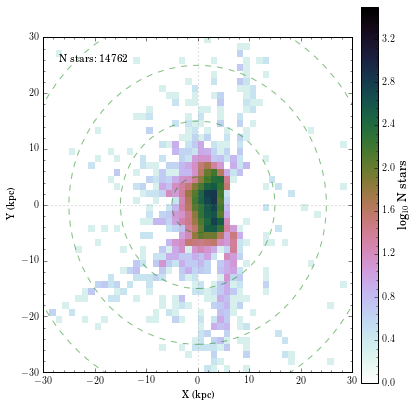

In [212]:
plot_xy(crich_agbs[(abs(crich_agbs.Z) > 0) & (abs(crich_agbs.Z) < 3)], 
        y_guides=None, circles=[5., 15., 25., 35.,],
       **{"edgecolor":"g", "fill":False, 
          "linestyle":"--", "alpha":0.5})

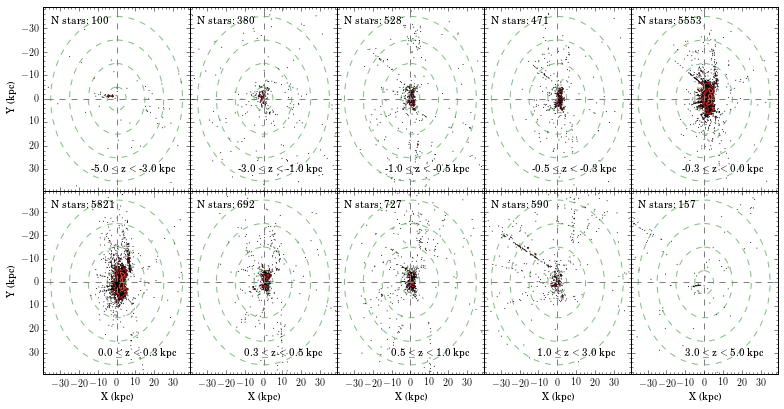

In [213]:
#pieces of Z:
dlev = 0.75
levs = np.arange(0, 3.5+dlev, dlev)
zarray = [-5.0, -3.0, -1.0, -0.5, -0.3, 
          0.0, 0.3, 0.5, 1.0, 3.0, 5.0]
dh = 401
xbins = np.linspace(-100, 100, dh)
ybins = np.linspace(-100, 100, dh)

fig = plt.figure(figsize=(12, 6))
fig.subplots_adjust(hspace=0, wspace=0, top=0.95, left=0.05, right=0.9, bottom=0.1)

circles = [5., 15., 25., 35.]

for ii in range(len(zarray)-1):
    zhi = zarray[ii+1]
    zlo = zarray[ii]
    select = (crich_agbs.Z < zhi) & (crich_agbs.Z >= zlo)
    
    ax = plt.subplot(2, 5, ii+1)
    H, xedges, yedges = np.histogram2d(crich_agbs.X[select], crich_agbs.Y[select],
                                       bins=(xbins,ybins))
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    ## sample
    ax.scatter(crich_agbs.X[select], crich_agbs.Y[select],
               s=1, edgecolor='None', c='k')
    
    ## circles
    for radius in circles:
        add_ellipse(ax, [0, 0], radius, radius, 
                    **{"edgecolor":"g", "fill":False, 
                       "linestyle":"--", "alpha":0.5})
    
    ## contours
    im = ax.contour(np.log10(H.T), extent=extent, cmap=plt.cm.Reds_r, levels=levs)
    
    ## crosshairs on (0,0)
    ax.plot([-1E5, 1E5], [0, 0], linestyle='--', color='grey')
    ax.plot([0, 0],[-1E5, 1E5], linestyle='--', color='grey')
    ax.text(0.9, 0.1, '%.1f $\le$ z $<$ %.1f kpc' % (zlo, zhi), 
            horizontalalignment='right', transform=ax.transAxes)
    ax.text(0.05, 0.95, "N stars: %g" % (sum(select)), horizontalalignment="left",
           verticalalignment="top", transform=ax.transAxes)
    
    ax.set_xlim(-39, 39)
    ## Flip the Y-axis
    ax.set_ylim(39, -39)
    if ii > 4:
        ax.set_xlabel('X (kpc)')
    if ii in [0, 5]:
        ax.set_ylabel('Y (kpc)')
    else:
        ax.yaxis.set_major_formatter(NullFormatter())
        
    ax.minorticks_on()

plt.show()

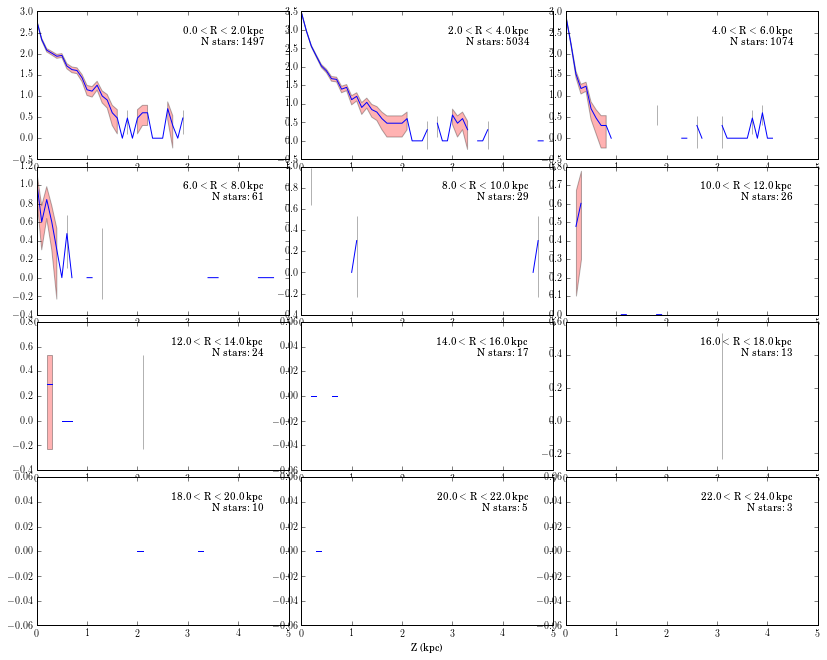

In [214]:
indx = 0
dr = 2.0
radii = np.arange(0, 24 + dr, dr)
z_bins = np.arange(0, 5, 0.1)

fig = plt.figure(figsize = (14, 11))
fig.subplots_adjust(hspace=0.05, wspace=0.05)
for rad in radii[:-1]:
    indx += 1
    #note y < 3 as that creates somewhat consistent area slices of rings
    restrict = (crich_agbs.R > rad) & (crich_agbs.R < rad + dr) & (abs(crich_agbs.Y) < 3) & crich_agbs.X > 0
    H, edges = np.histogram(abs(crich_agbs[restrict].Z), bins=z_bins)
    unc = np.sqrt(H)
    
    ax = plt.subplot(4, 3, indx)
    ax.plot(edges[:-1], np.log10(H), color="b")
    ax.fill_between(edges[:-1], np.log10(H - unc), np.log10(H + unc), facecolor="red",
                   alpha=0.3)
    
    ax.set_xlim(0, 5)

    text_str = "%.1f $<$ R $<$ %.1f kpc\nN stars: %g"    
    ax.text(0.9, 0.9, text_str % (rad, rad + dr, sum(restrict)),
            horizontalalignment="right", verticalalignment="top",
            transform = ax.transAxes)
    if indx == 11:
        ax.set_xlabel("Z (kpc)")
    
    
plt.show()

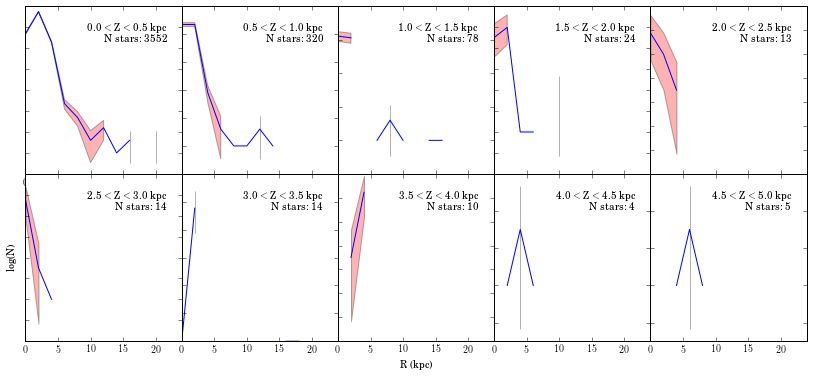

In [215]:
indx = 0
# dr = 2.0
# radii = np.arange(0, 24 + dr, dr)
# z_bins = np.arange(0, 5, 0.1)
dh = 0.5
heights = np.arange(0, 5 + dh, dh)
r_bins = np.arange(0, 24, 2.0)

fig = plt.figure(figsize = (14, 6))
fig.subplots_adjust(hspace=0.0, wspace=0.0)

for h in heights[:-1]:
    indx += 1
    #note y < 3 as that creates somewhat consistent area slices of rings
    restrict = (crich_agbs.Z > h) & (crich_agbs.Z < h + dh) & (abs(crich_agbs.Y) < 3) & crich_agbs.X > 0
    H, edges = np.histogram(abs(crich_agbs[restrict].R), bins=r_bins)
    unc = np.sqrt(H)
    
    ax = plt.subplot(2, 5, indx)
    ax.plot(edges[:-1], np.log10(H), color="b")
    ax.fill_between(edges[:-1], np.log10(H - unc), np.log10(H + unc), facecolor="red",
                   alpha=0.3)
    
    ax.set_xlim(0, 24)
    text_str = "%.1f $<$ Z $<$ %.1f kpc\nN stars: %g"    
    ax.text(0.9, 0.9, text_str % (h, h + dh, sum(restrict)),
            horizontalalignment="right", verticalalignment="top",
            transform = ax.transAxes)
    
    if indx == 8:
        ax.set_xlabel("R (kpc)")
    ax.yaxis.set_major_formatter(NullFormatter())
    if indx == 6:
        ax.set_ylabel("log(N)")
    
    
plt.show()

In [230]:
## Calculate vertical exponential fit for each radius bin and plot it up
## Can't do uniform bins for this sample because the sample size is just too small.
## Need to do separate fits for Z < 0.5 and Z > 0.5
def plot_horizontal_fits(data_df):
    dz = 0.1
    zbins = np.arange(0, 5 + dz, dz)

    fig = plt.figure(figsize=(16, 20))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    for ii in range(len(zbins) - 1):
        zbin = (data_df.Z > zbins[ii]) & (data_df.Z < zbins[ii + 1])

        ## select stars of interest in zbin
        zvals = data_df.Z[zbin]
        rvals = data_df.R[zbin]

        dr = 2.0
        radbins = np.arange(0, 24 + dr, dr)
        H, ed = np.histogram(abs(rvals), bins=radbins)

        coeffs = scale_length(rvals)
            
        line1 = linear_func(radbins[:-1] + dr/2, coeffs[0], coeffs[1])
        line2 = linear_func(radbins[:-1] + dr/2, coeffs[2], coeffs[3])
        total = line1 + line2
        
        ax = plt.subplot(4, 3, ii+1)
        ax.errorbar(radbins[:-1] + dr/2, H, np.sqrt(H), marker='o', linewidth=0,
                    elinewidth=1)
        ax.plot(radbins[:-1] + dr/2, line1, color='r')
        ax.plot(radbins[:-1] + dr/2, line2, color='g')
        ax.plot(radbins[:-1] + dr/2, total, color='k', linewidth=2)
        
        std = np.sqrt(1./len(H) * np.sum((H - total)**2.))
       
        fitstr = "$%.2f < Z < %.2f$ kpc"
        fitstr += "\nThe Fit:\tR$_{h1}$ = %.2f kpc"
        fitstr += "\n\t\tR$_{h2}$ = %.2f kpc"
        fitstr += "\n\t\t$\sigma$ = %.2f"
        fitstr += "\nN stars: %g"
        
        ax.text(0.07, 0.07,
                fitstr % (zbins[ii], zbins[ii + 1], abs(1 / coeffs[0]), 
                          abs(1 / coeffs[2]), std, sum(zbin)), 
                transform=ax.transAxes, horizontalalignment='left', 
                verticalalignment="bottom", fontsize=14)
     
        ax.set_xlim(0, 3)
        ax.set_ylim(1.0)
        ax.set_yscale('log')
        
        if ii >= 9:
            ax.set_xlabel('$|R|$ (kpc)')
        
        if ii in [0, 3, 6, 12]:
            ax.set_ylabel('N')
        ax.minorticks_on()

    plt.show()

In [235]:
def scale_length(rvals, rcut=0.5):
    rvals = abs(rvals)
    
    ## Declare the z value to cut at, then declare two different populations of sources
    rabove = rvals > rcut
    rbelow = rvals <= rcut
    
    ## Histogram for objects above 0.5 kpc from the plane
    rbins = np.linspace(5, 26, 11)
    H1, ed1 = np.histogram(rvals[rabove], bins=rbins)
    dx1 = (ed1[1] - ed1[0]) / 2.
    mask = np.where(H1 != 0)
    
    if rcut == 5:
        the_first_fit = np.polyfit(ed1[:-1][mask] + dx1, np.log(H1[mask] / 4.), deg=1)
        
    else:
        the_first_fit = np.polyfit(ed1[:-1][mask] + dx1, np.log(H1[mask]), deg=1)

    
    ## Histogram for objects below 0.5 kpc from the plane
    rbins = np.linspace(0, 5, 6)
    H2, ed2 = np.histogram(rvals[rbelow], bins=rbins) 
    dx2 = (ed2[1] - ed2[0]) / 2.
    mask = np.where(H2 != 0)
    
    if rcut == 5:
        the_second_fit = np.polyfit(ed2[:-1][mask] + dx2, np.log(H2[mask] / 2.), deg=1)
        
    else:
        the_second_fit = np.polyfit(ed2[:-1][mask] + dx2, np.log(H2[mask]), deg=1)
    
    coeffs = [the_first_fit[0], the_first_fit[1], the_second_fit[0], the_second_fit[1]]
    
    ## Note, the coefficients returned are NOT scale height and normalization
    ## The coefficients are related, but aren't directly those values.
    ## scale heights are -1/coeffs[0] and -1/coeffs[2]
    ## normalizations are np.exp(coeffs[1]) and np.exp(coeffs[3])
    return coeffs

/Users/Nick/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:594: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


TypeError: expected non-empty vector for x

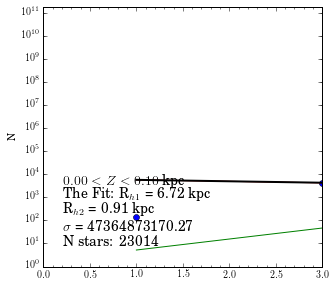

In [236]:
plot_horizontal_fits(orich_agbs)